In [1]:
!pip install torchsummary

In [2]:
import torch
import torchvision

In [3]:
import os
import time
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

### Скачиваем датасет

In [4]:
# !wget https://figshare.com/ndownloader/files/34792480 -O Confirmed_fronts.zip

In [5]:
# !unzip -q Confirmed_fronts.zip

### Парсим каталог с изображениями

In [6]:
!if [ -d dataset/ ]; then rm -r dataset/; fi

In [7]:
import glob
import re

map = {}
max_len = 6095
for filename in glob.iglob('./confirmed_fronts/*/*/*[jpg]', recursive=True):
    x = re.search("([^$]+)\\$\\$([^$]+)\\$\\$([^$]+)\\$\\$([^$]+)\\$\\$([^$]+)\\$\\$([^$]+)\\$\\$i([^$]+)", filename)
    if x:
        color = x.group(4).lower()
        if color not in map:
            map[color] = []

        if len(map[color]) < max_len:
            map[color].append(filename)

print(map.keys())

dict_keys(['black', 'beige', 'red', 'blue', 'silver', 'grey', 'white', 'multicolour', 'purple', 'brown', 'green', 'unlisted', 'gold', 'yellow', 'bronze', 'orange', 'maroon', 'burgundy', 'pink', 'turquoise', 'navy', 'magenta', 'indigo'])


### Удаляем категории в которых мало изображений

In [8]:
min_len = 1000

for cls in list(map.keys()):
    cls_len = len(map[cls])
    if cls_len < max_len:
        del map[cls]
        continue

# Удалил silver и grey так как они трудно-отличимы друг от друга и от black
del map['silver']
del map['grey']
print(map.keys())

dict_keys(['black', 'red', 'blue', 'white'])


### Выравниваем классы по количеству изображений

In [9]:
min_cls_len = 10e10
for cls in list(map.keys()):
    if len(map[cls]) < min_cls_len:
        min_cls_len = len(map[cls])

print(f"min_cls_len: {min_cls_len}")

for cls in list(map.keys()):
    map[cls] = map[cls][0:min_cls_len]

min_cls_len: 6095


### Делим датасет на test и train и составляем список классов в labels.csv

In [10]:
import os
import shutil
import random
import numpy as np

classes = list(map.keys())
counter = 0
test_ratio = 0.05
labels = [('id', 'cls')]
test_images = []
train_images = []

for cls in classes:
    filenames = map[cls]
    num = len(filenames)
    test_size = int(num * test_ratio)
    test_files = random.sample(filenames, test_size)

    for fn in filenames:
        counter += 1
        id = f"{cls}_{counter}"
        new_fn = f"{id}.jpg"
        labels.append((id, cls))
        if fn in test_files:
            dest_path = f"./dataset/test/{new_fn}"
            test_images.append(dest_path)
        else:
            dest_path = f"./dataset/train/{new_fn}"
            train_images.append(dest_path)
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        shutil.copy(fn, dest_path)

np.savetxt('./dataset/labels.csv', labels, delimiter=',', fmt='%s')

In [11]:
import pandas as pd

dataset_root = './dataset'

labels = pd.read_csv(f'{dataset_root}/labels.csv')
labels.head()

id    cls
0  black_1  black
1  black_2  black
2  black_3  black
3  black_4  black
4  black_5  black

In [12]:
img_name_to_label = labels.set_index('id')['cls'].to_dict()
list(img_name_to_label.items())[:10]

[('black_1', 'black'),
 ('black_2', 'black'),
 ('black_3', 'black'),
 ('black_4', 'black'),
 ('black_5', 'black'),
 ('black_6', 'black'),
 ('black_7', 'black'),
 ('black_8', 'black'),
 ('black_9', 'black'),
 ('black_10', 'black')]

In [13]:
classes = sorted(labels['cls'].unique())
classes

['black', 'blue', 'red', 'white']

./dataset/train/black_1.jpg


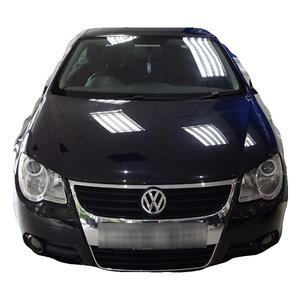

In [14]:
import cv2
from PIL import Image

print(train_images[0])
Image.open(train_images[0])

In [15]:
from sklearn.model_selection import train_test_split
import numpy as np

img_names = sorted(os.listdir(f'{dataset_root}/train'))
total_imgs = len(img_names)
targets = [img_name_to_label[img_name.replace('.jpg', '')] for img_name in img_names]
train_set_inds, test_set_inds = train_test_split(np.arange(total_imgs), test_size=0.1, random_state=42,
                                                 stratify=targets)

In [16]:
train_img_names = [img_names[ind] for ind in train_set_inds]
test_img_names = [img_names[ind] for ind in test_set_inds]

In [17]:
from torchvision import transforms as T

# ресайзим изображения до 224 (размер нашего входа)
img_sz = 224

# преобразуем в тензор и нормализуем
# стандартные значения нормализации вычисленные математически
normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_data_transforms = T.Compose([
    T.Resize((img_sz, img_sz)),
    T.ToTensor(),
    normalize
])
test_data_transforms = T.Compose([
    T.Resize((img_sz, img_sz)),
    T.ToTensor(),
    normalize
])

### Инициализируем ImageDataset'ы для доступа к данным

In [18]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd


class ImageDataset(Dataset):
    def __init__(self, dataset_root, classes, img_name_to_label,
                 img_names, transform):
        self.dataset_root = dataset_root
        self.img_names = img_names
        self.img_name_to_label = img_name_to_label
        self.label_to_idx = {val: idx for idx, val in enumerate(classes)}
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        img_name = self.img_names[index]
        img_path = f'{self.dataset_root}/{img_name}'
        label = self.img_name_to_label[img_name.replace('.jpg', '')]
        image = Image.open(img_path).convert('RGB')

        image_tensor = self.transform(image)
        image.close()
        return image_tensor, self.label_to_idx[label]

In [19]:
image_datasets = dict()
image_datasets['train'] = ImageDataset(dataset_root=f"{dataset_root}/train",
                                       classes=classes,
                                       img_name_to_label=img_name_to_label,
                                       img_names=train_img_names,
                                       transform=train_data_transforms)

image_datasets['test'] = ImageDataset(dataset_root=f"{dataset_root}/train",
                                      classes=classes,
                                      img_name_to_label=img_name_to_label,
                                      img_names=test_img_names,
                                      transform=test_data_transforms)

## Инициализируем DataLoader'ы

In [20]:
from torch.utils.data import DataLoader

batch_size = 256
num_workers = 16

dataloaders = dict()
dataloaders['train'] = DataLoader(image_datasets['train'],
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=True,
                                  drop_last=True)
dataloaders['test'] = DataLoader(image_datasets['test'],
                                 batch_size=batch_size,
                                 shuffle=False,
                                 num_workers=num_workers,
                                 pin_memory=True)

### Для обучения будем использовать 3 предобученные модели:
  - ResNet50
  - AlexNet
  - VGG19

(выбор пал на них, т.к. их мне лучше всего удалось дообучить)

### ResNet50

In [21]:
from torchvision import models
from torch import nn
import torch


def get_resnet(num_classes):
    net_features = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    # net_features = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

    net_features.requires_grad_(False)
    net_features.fc = nn.Sequential(
        nn.Linear(2048, 1024),
        nn.Dropout(0.1),
        nn.ReLU(),
        nn.Linear(1024, 256),
        nn.Dropout(0.1),
        nn.ReLU(),
        nn.Linear(256, num_classes)
    )
    return net_features

### AlexNet

In [22]:
from torchvision import models
from torch import nn
import torch


def get_alexnet(num_classes):
    net_features = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
    net_features.requires_grad_(False)

    dropout = 0.5

    net_features.classifier = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=dropout),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, num_classes),
    )
    return net_features

### VGG

In [23]:
from torchvision import models
from torch import nn
import torch


def get_vgg(num_classes):
    net_features = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
    net_features.requires_grad_(False)

    dropout = 0.5
    net_features.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(True),
        nn.Dropout(p=dropout),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(p=dropout),
        nn.Linear(4096, num_classes),
    )

    return net_features

### Инициализируем модели

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net_models = {}
net_models['resnet'] = get_resnet(num_classes=len(classes)).to(device)
net_models['alexnet'] = get_alexnet(num_classes=len(classes)).to(device)
net_models['vgg'] = get_vgg(num_classes=len(classes)).to(device)

### Выводим полученные архитектуры нейронных сетей

In [25]:
from torchsummary import summary

for name in list(net_models.keys()):
    print(name)
    summary(net_models[name], input_size=(3, 224, 224))

resnet
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-

### Обучение

In [26]:
from sklearn import metrics


def run_epoch(phase, dataloader):
    if phase == 'train':
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    running_corrects = 0
    y_test = []
    y_pred = []
    all_elems_count = 0
    cur_tqdm = tqdm(dataloader)
    for inputs, labels in cur_tqdm:
        bz = inputs.shape[0]
        all_elems_count += bz

        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        if phase == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        _, preds = torch.max(outputs, 1)
        y_test.extend(labels.detach().cpu().numpy())
        y_pred.extend(preds.detach().cpu().numpy())
        running_loss += loss.item() * bz
        corrects_cnt = torch.sum(preds == labels.detach())
        running_corrects += corrects_cnt
        show_dict = {'Loss': f'{loss.item():.6f}',
                     'Corrects': f'{corrects_cnt.item()}/{bz}',
                     'Accuracy': f'{(corrects_cnt * 100 / bz).item():.3f}%'}
        cur_tqdm.set_postfix(show_dict)

    conf_matrix = metrics.confusion_matrix(y_test, y_pred)

    print("Calculating metrics...")
    f05_macro = metrics.fbeta_score(y_test, y_pred, average="macro", beta=0.5)
    f1_macro = metrics.f1_score(y_test, y_pred, average="macro")
    epoch_loss = running_loss / all_elems_count
    epoch_acc = running_corrects.float().item() / all_elems_count
    return epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix


def test_epoch(dataloader):
    with torch.inference_mode():
        return run_epoch('test', dataloader)


def train_epoch(dataloader):
    return run_epoch('train', dataloader)

In [27]:
import time
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

log_folder = 'logs'
os.makedirs(log_folder, exist_ok=True)

results = {}


def train_model(name, dataloaders, num_epochs=5):
    print(f"Training model with params:")
    print(f"Optim: {optimizer}")
    print(f"Criterion: {criterion}")

    phases = ['train', 'test']
    for phase in dataloaders:
        if phase not in phases:
            phases.append(phase)

    results[name] = {'train': (), 'test': ()}

    saved_epoch_losses = {phase: [] for phase in phases}
    saved_epoch_accuracies = {phase: [] for phase in phases}
    saved_epoch_f1_macros = {phase: [] for phase in phases}

    for epoch in range(1, num_epochs + 1):
        start_time = time.time()

        print("=" * 100)
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            print("--- Cur phase:", phase)
            epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix = \
                train_epoch(dataloaders[phase]) if phase == 'train' \
                    else test_epoch(dataloaders[phase])
            saved_epoch_losses[phase].append(epoch_loss)
            saved_epoch_accuracies[phase].append(epoch_acc)
            saved_epoch_f1_macros[phase].append(f1_macro)
            print(f'{phase} loss: {epoch_loss:.6f}, '
                  f'acc: {epoch_acc:.6f}, '
                  f'f05_macro: {f05_macro:.6f}, '
                  f'f1_macro: {f1_macro:.6f}')
            print("Confusion matrix:")
            print(conf_matrix)

            results[name][phase] = epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix

        model.eval()
        if epoch > 1:
            plt.title(f'Losses during training. Epoch {epoch}/{num_epochs}.')
            plt.plot(range(1, epoch + 1), saved_epoch_losses['train'], label='Train Loss')
            plt.plot(range(1, epoch + 1), saved_epoch_losses['test'], label='Test Loss')
            plt.xlabel('Epochs')
            plt.ylabel(criterion.__class__.__name__)
            plt.legend(loc="upper left")
            plt.savefig(f'{log_folder}/loss_graph_{name}_epoch{epoch + 1}.png')
            plt.show()
            plt.close('all')

            plt.title(f'Accuracies during training. Epoch {epoch}/{num_epochs}.')
            plt.plot(range(1, epoch + 1), saved_epoch_accuracies['train'], label='Train Acc')
            plt.plot(range(1, epoch + 1), saved_epoch_accuracies['test'], label='Test Acc')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc="upper left")
            plt.savefig(f'{log_folder}/acc_graph_{name}_epoch{epoch + 1}.png')
            plt.show()
            plt.close('all')

            plt.title(f'F1-macros during training. Epoch {epoch}/{num_epochs}.')
            plt.plot(range(1, epoch + 1), saved_epoch_f1_macros['train'], label='Train F1')
            plt.plot(range(1, epoch + 1), saved_epoch_f1_macros['test'], label='Test F1')
            plt.xlabel('Epochs')
            plt.ylabel('F1')
            plt.legend(loc="upper left")
            plt.savefig(f'{log_folder}/f1_graph_{name}_epoch{epoch + 1}.png')
            plt.show()
            plt.close('all')

        end_time = time.time()
        epoch_time = end_time - start_time
        print("-" * 10)
        print(f"Epoch Time: {math.floor(epoch_time // 60)}:{math.floor(epoch_time % 60):02d}")

    print("*** Training Completed ***")

    return saved_epoch_losses, saved_epoch_accuracies, saved_epoch_f1_macros

### Инициализируем гиперпараметры и запускаем обучение

Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:19<00:00,  4.06it/s, Loss=0.184428, Corrects=236/256, Accuracy=92.188%]


Calculating metrics...
train loss: 0.358329, acc: 0.866271, f05_macro: 0.865771, f1_macro: 0.865633
Confusion matrix:
[[4152  851   37  138]
 [1155 3801   26  201]
 [  62   38 5010   73]
 [  65  116   11 5000]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.79it/s, Loss=0.081488, Corrects=13/13, Accuracy=100.000%]


Calculating metrics...
test loss: 0.212644, acc: 0.917134, f05_macro: 0.917702, f1_macro: 0.916808
Confusion matrix:
[[521  52   1   5]
 [109 460   2   8]
 [  5   2 573   0]
 [  2   5   1 571]]
----------
Epoch Time: 0:22
Epoch 2/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:18<00:00,  4.43it/s, Loss=0.202237, Corrects=238/256, Accuracy=92.969%]


Calculating metrics...
train loss: 0.211470, acc: 0.919174, f05_macro: 0.919476, f1_macro: 0.919005
Confusion matrix:
[[4626  506   19   37]
 [ 878 4211   13   83]
 [  39   16 5113    7]
 [  24   52    2 5110]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.77it/s, Loss=0.061590, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.203236, acc: 0.918861, f05_macro: 0.918424, f1_macro: 0.918524
Confusion matrix:
[[489  82   1   7]
 [ 71 493   2  13]
 [  5   2 572   1]
 [  0   4   0 575]]


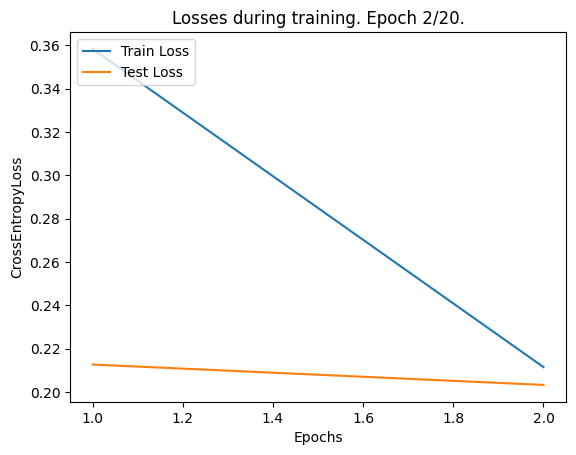

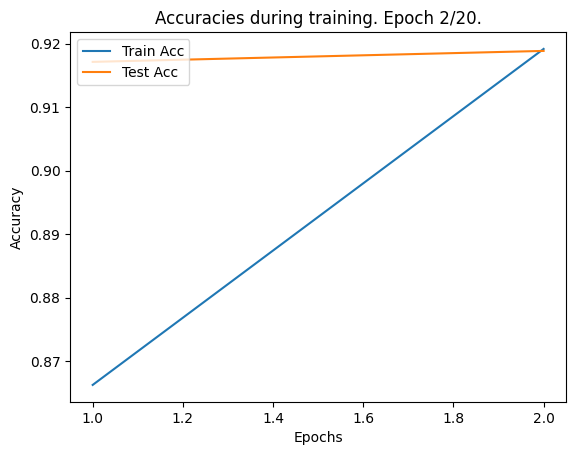

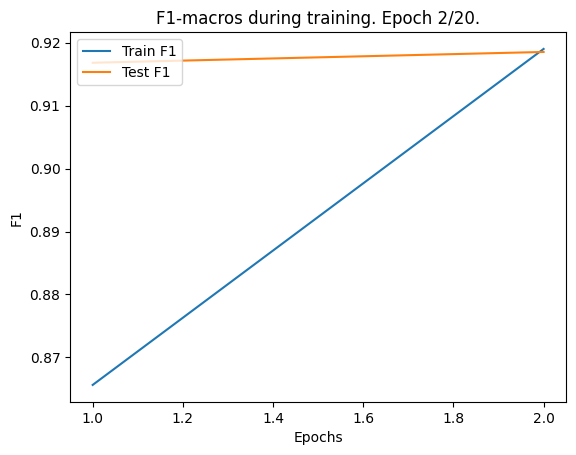

----------
Epoch Time: 0:21
Epoch 3/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:18<00:00,  4.39it/s, Loss=0.149687, Corrects=233/256, Accuracy=91.016%]


Calculating metrics...
train loss: 0.177689, acc: 0.932774, f05_macro: 0.933100, f1_macro: 0.932699
Confusion matrix:
[[4727  408   20   27]
 [ 731 4379   12   68]
 [  36   11 5127    7]
 [  28   45    1 5109]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.64it/s, Loss=0.040978, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.186285, acc: 0.923177, f05_macro: 0.924737, f1_macro: 0.923086
Confusion matrix:
[[537  38   1   3]
 [109 463   1   6]
 [  6   2 571   1]
 [  5   6   0 568]]


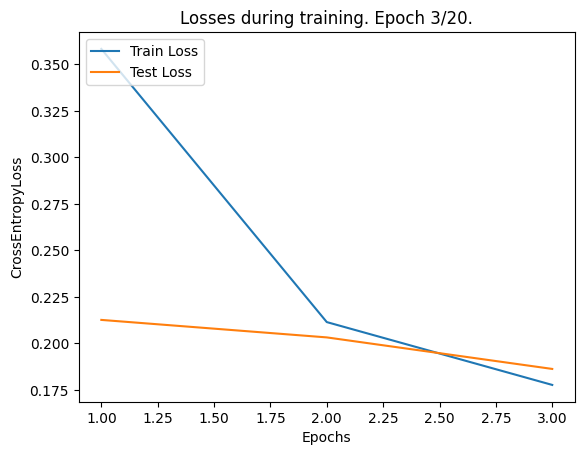

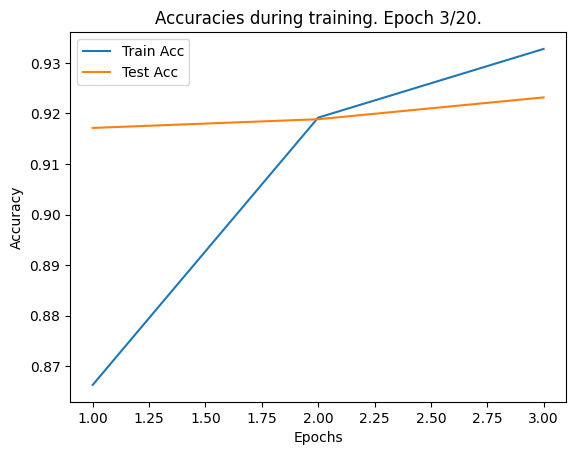

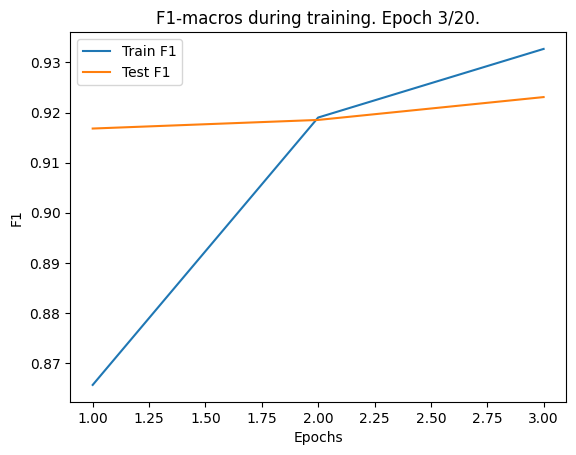

----------
Epoch Time: 0:21
Epoch 4/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:18<00:00,  4.37it/s, Loss=0.116723, Corrects=244/256, Accuracy=95.312%]


Calculating metrics...
train loss: 0.156922, acc: 0.939091, f05_macro: 0.939329, f1_macro: 0.939089
Confusion matrix:
[[4731  421   12   18]
 [ 663 4475    8   46]
 [  32    8 5134    5]
 [  16   30    4 5133]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.50it/s, Loss=0.028773, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.180920, acc: 0.926198, f05_macro: 0.927005, f1_macro: 0.926067
Confusion matrix:
[[532  43   1   3]
 [ 96 474   2   7]
 [  5   2 570   3]
 [  4   5   0 570]]


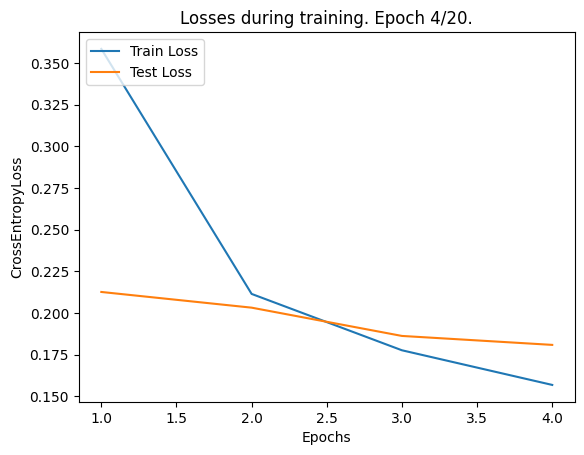

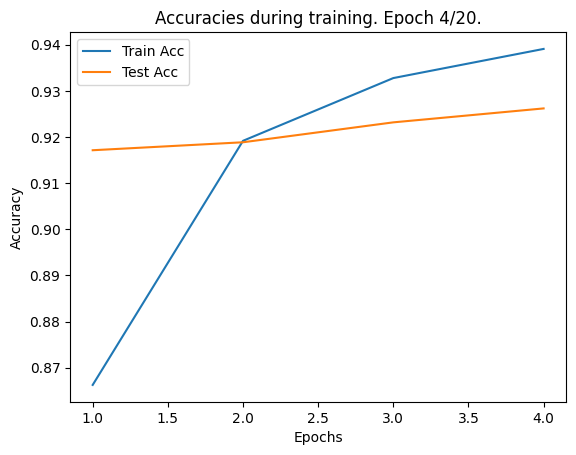

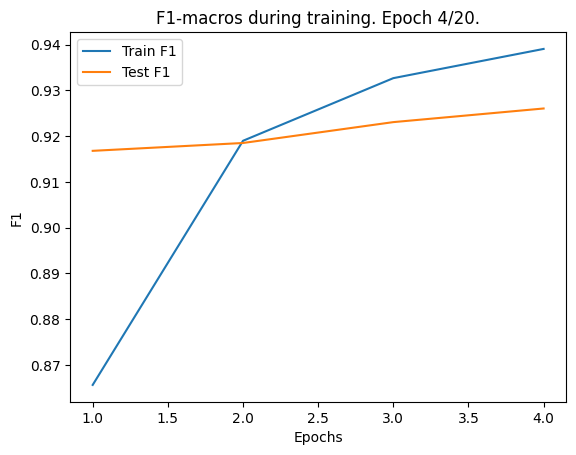

----------
Epoch Time: 0:21
Epoch 5/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:18<00:00,  4.41it/s, Loss=0.116908, Corrects=246/256, Accuracy=96.094%]


Calculating metrics...
train loss: 0.131083, acc: 0.948447, f05_macro: 0.948674, f1_macro: 0.948443
Confusion matrix:
[[4807  353   15   12]
 [ 589 4564    6   26]
 [  23    8 5153    4]
 [  13   16    4 5143]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.66it/s, Loss=0.052038, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.205643, acc: 0.917566, f05_macro: 0.919065, f1_macro: 0.917863
Confusion matrix:
[[470 106   0   3]
 [ 52 520   0   7]
 [  5   6 568   1]
 [  1  10   0 568]]


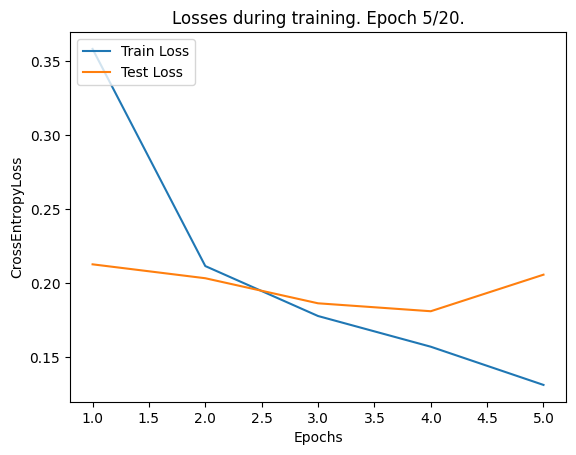

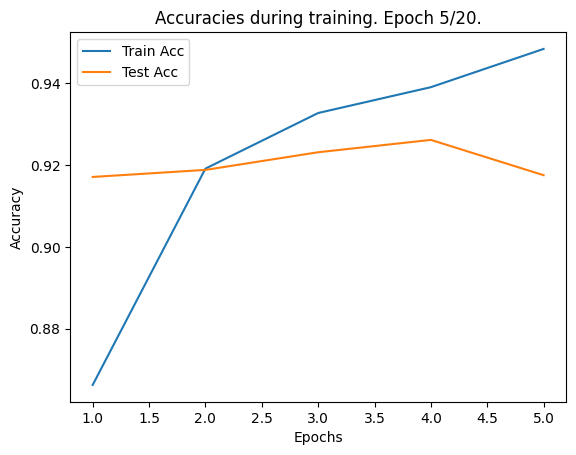

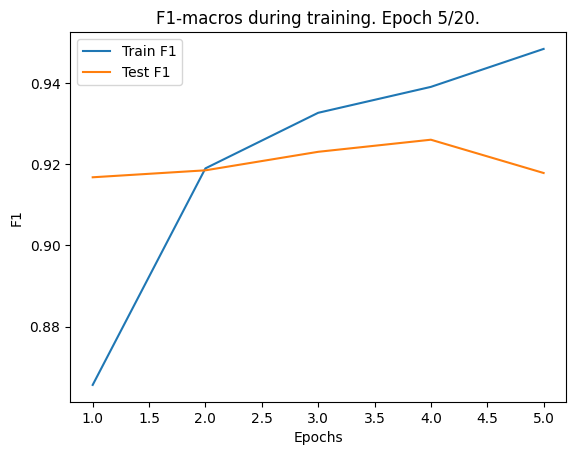

----------
Epoch Time: 0:21
Epoch 6/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:18<00:00,  4.38it/s, Loss=0.104926, Corrects=244/256, Accuracy=95.312%]


Calculating metrics...
train loss: 0.125874, acc: 0.951389, f05_macro: 0.951475, f1_macro: 0.951337
Confusion matrix:
[[4828  331    7   21]
 [ 524 4606    7   41]
 [   7    6 5159    6]
 [  22   35    1 5135]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.48it/s, Loss=0.013187, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.204934, acc: 0.921450, f05_macro: 0.923089, f1_macro: 0.921729
Confusion matrix:
[[536  40   0   3]
 [103 471   0   5]
 [  5   4 571   0]
 [  7  15   0 557]]


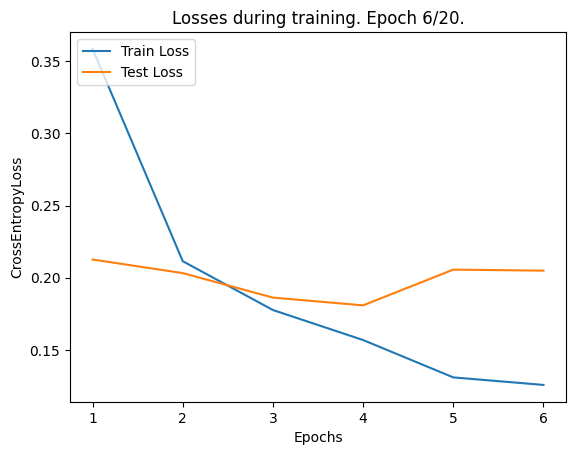

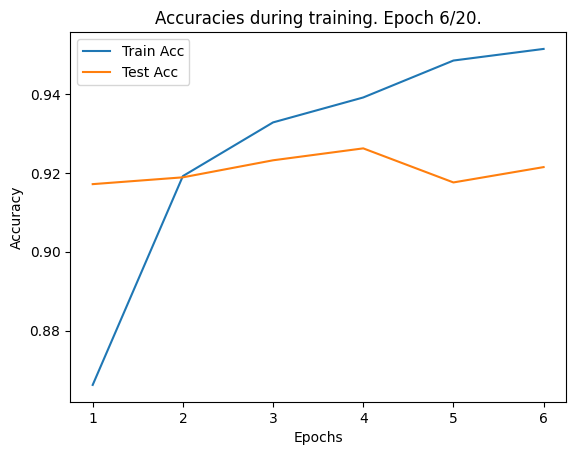

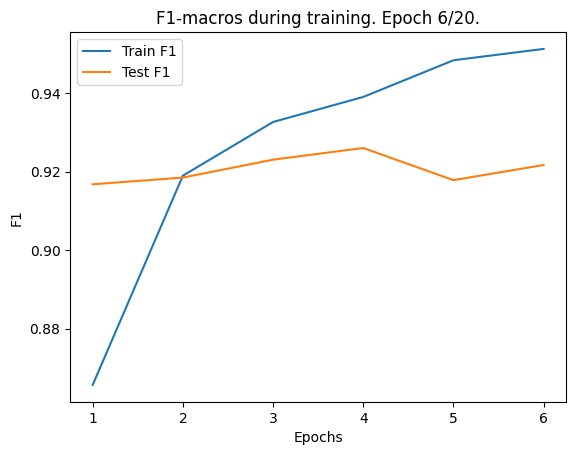

----------
Epoch Time: 0:21
Epoch 7/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:18<00:00,  4.41it/s, Loss=0.129731, Corrects=245/256, Accuracy=95.703%]


Calculating metrics...
train loss: 0.093917, acc: 0.965615, f05_macro: 0.965730, f1_macro: 0.965617
Confusion matrix:
[[4940  227    8   17]
 [ 393 4766    2   19]
 [  12    3 5163    2]
 [  10   19    1 5154]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.64it/s, Loss=0.018198, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.218294, acc: 0.924040, f05_macro: 0.923309, f1_macro: 0.923445
Confusion matrix:
[[496  71   2  10]
 [ 61 495   1  22]
 [  3   3 574   0]
 [  1   2   0 576]]


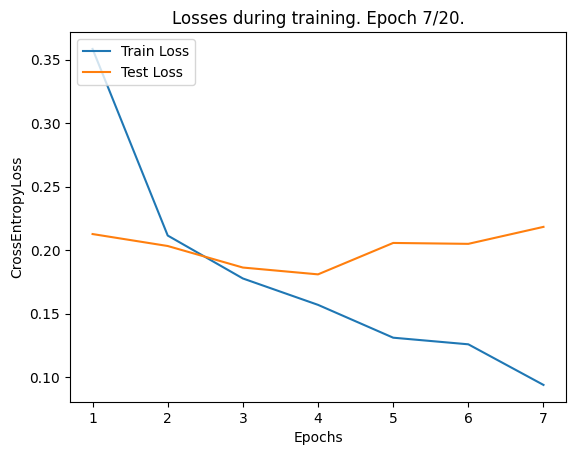

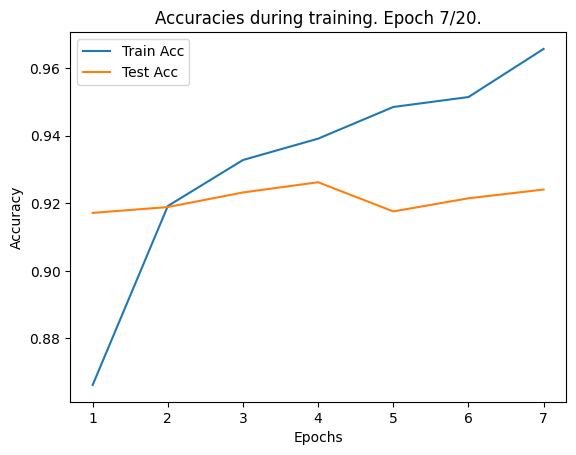

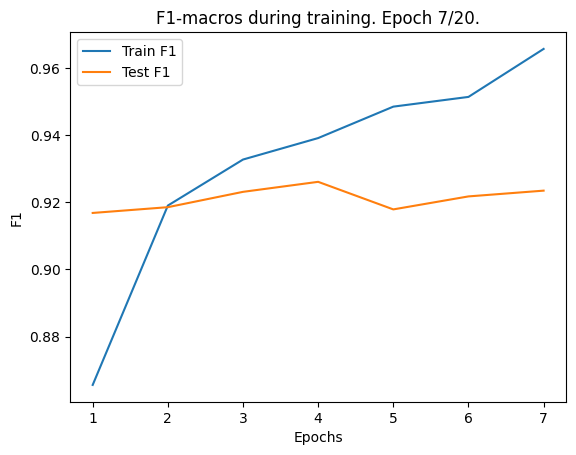

----------
Epoch Time: 0:21
Epoch 8/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:18<00:00,  4.36it/s, Loss=0.062788, Corrects=253/256, Accuracy=98.828%]


Calculating metrics...
train loss: 0.071805, acc: 0.973090, f05_macro: 0.973138, f1_macro: 0.973089
Confusion matrix:
[[4984  188    8    7]
 [ 295 4868    7   14]
 [  10    6 5162    2]
 [   7   10    4 5164]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.65it/s, Loss=0.015612, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.223749, acc: 0.921450, f05_macro: 0.921474, f1_macro: 0.921299
Confusion matrix:
[[484  88   3   4]
 [ 60 507   2  10]
 [  3   4 572   1]
 [  2   5   0 572]]


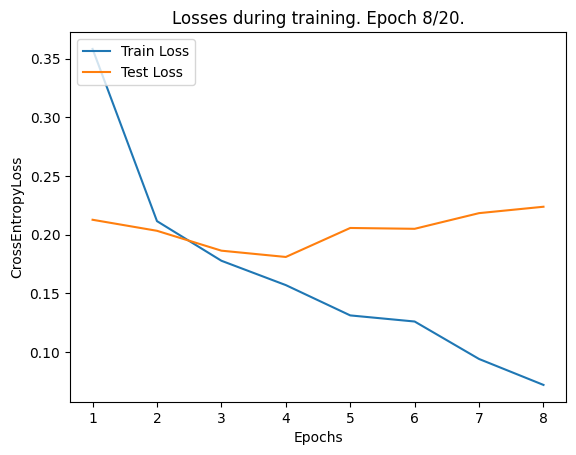

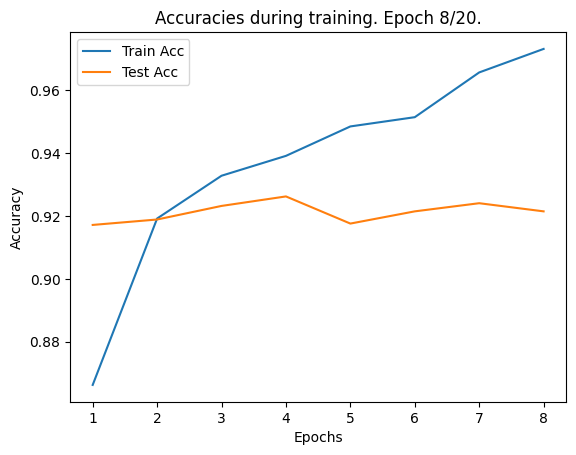

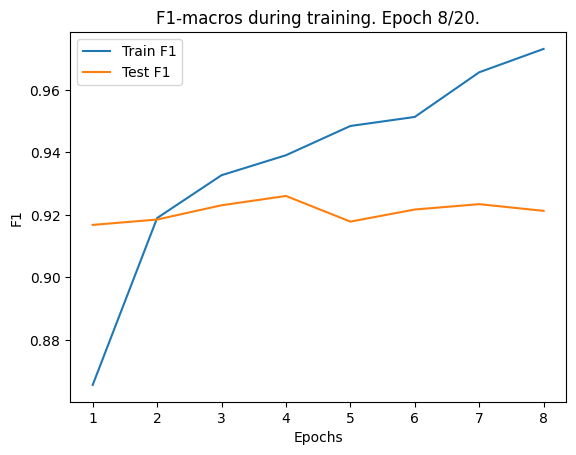

----------
Epoch Time: 0:21
Epoch 9/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:18<00:00,  4.38it/s, Loss=0.072116, Corrects=249/256, Accuracy=97.266%]


Calculating metrics...
train loss: 0.066091, acc: 0.975887, f05_macro: 0.975920, f1_macro: 0.975892
Confusion matrix:
[[5001  176    5    8]
 [ 259 4906    4   16]
 [   6    3 5165    3]
 [   8    9    3 5164]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.60it/s, Loss=0.002341, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.246876, acc: 0.925334, f05_macro: 0.926246, f1_macro: 0.924558
Confusion matrix:
[[541  31   2   5]
 [107 456   2  14]
 [  4   1 575   0]
 [  2   4   1 572]]


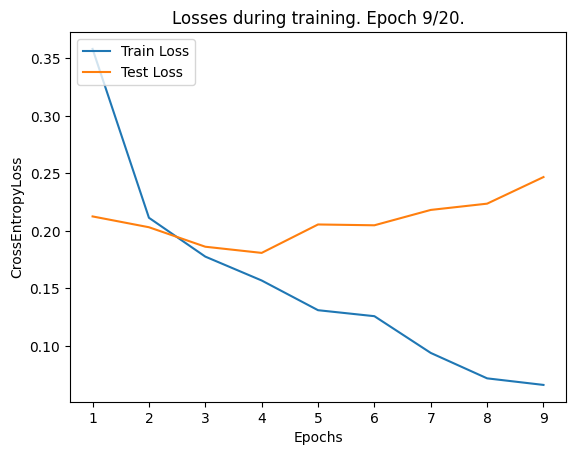

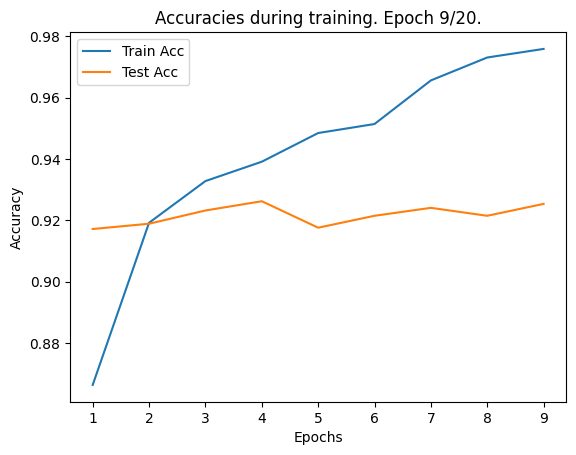

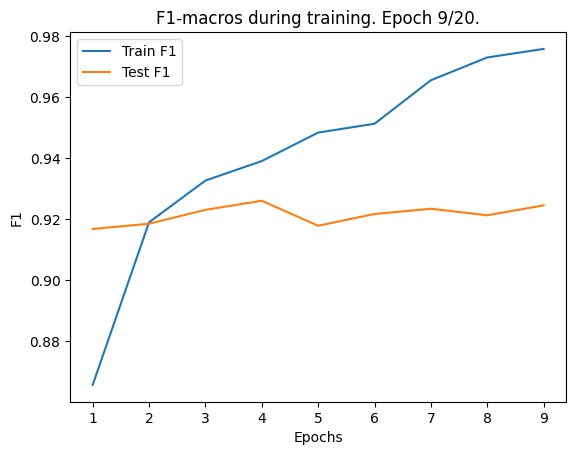

----------
Epoch Time: 0:21
Epoch 10/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:18<00:00,  4.37it/s, Loss=0.048417, Corrects=251/256, Accuracy=98.047%]


Calculating metrics...
train loss: 0.052443, acc: 0.981385, f05_macro: 0.981412, f1_macro: 0.981402
Confusion matrix:
[[5051  106   23    9]
 [ 150 5014   11   16]
 [  26   14 5133    4]
 [   7   18    2 5152]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.70it/s, Loss=0.004439, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.262346, acc: 0.919724, f05_macro: 0.921141, f1_macro: 0.920053
Confusion matrix:
[[528  47   2   2]
 [ 97 475   0   7]
 [  5   4 571   0]
 [ 11  11   0 557]]


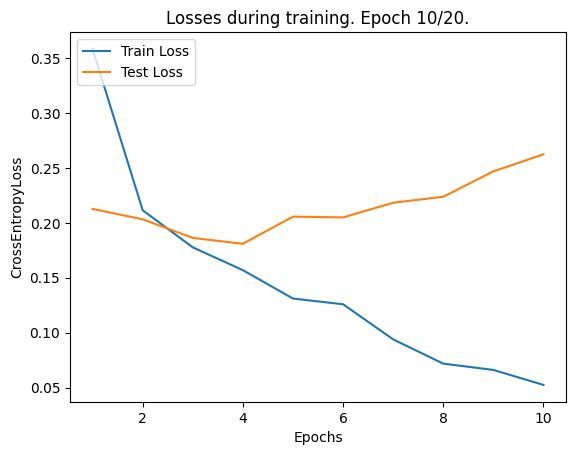

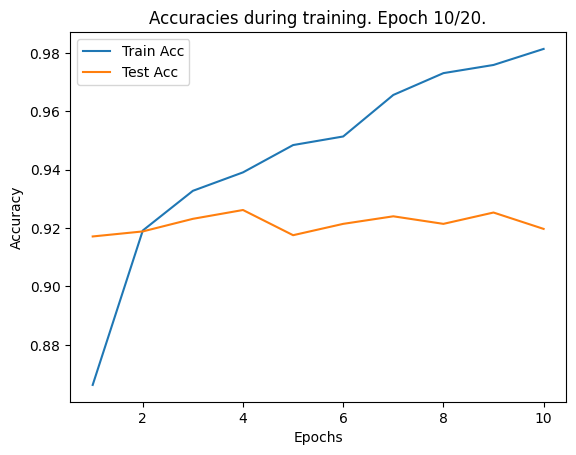

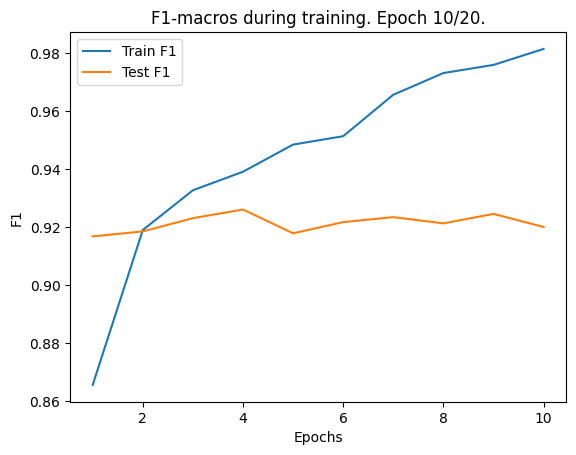

----------
Epoch Time: 0:21
Epoch 11/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:18<00:00,  4.26it/s, Loss=0.057023, Corrects=250/256, Accuracy=97.656%]


Calculating metrics...
train loss: 0.036469, acc: 0.986593, f05_macro: 0.986592, f1_macro: 0.986590
Confusion matrix:
[[5075   96    3    7]
 [ 120 5046    6   15]
 [   5    3 5175    4]
 [   9    8    2 5162]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.71it/s, Loss=0.014517, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.261949, acc: 0.920155, f05_macro: 0.921032, f1_macro: 0.920556
Confusion matrix:
[[492  83   2   2]
 [ 63 508   0   8]
 [  5   7 568   0]
 [  1  13   1 564]]


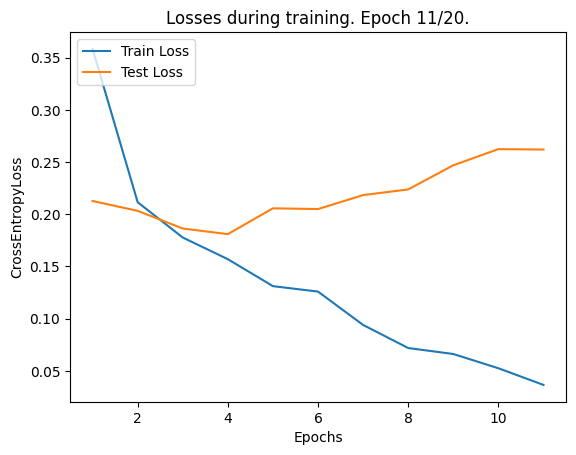

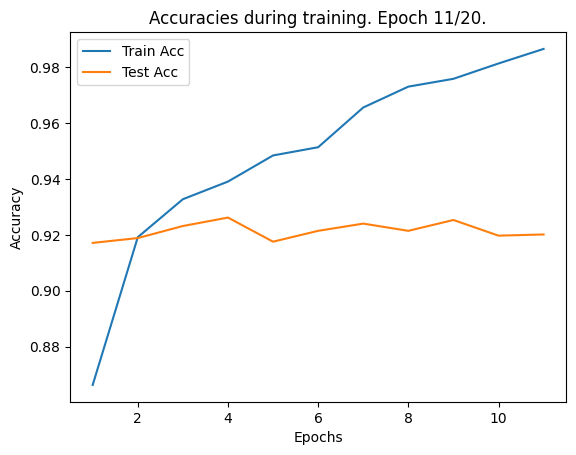

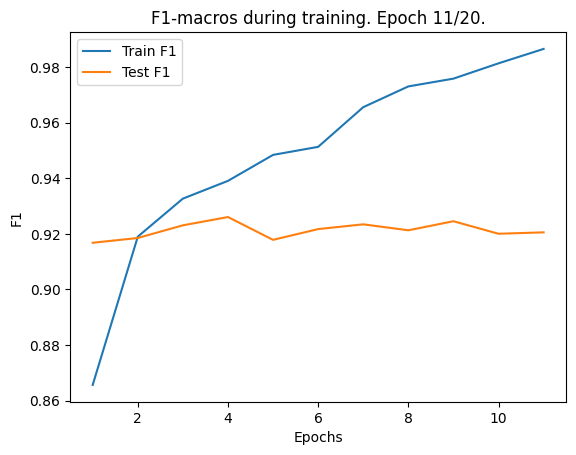

----------
Epoch Time: 0:22
Epoch 12/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:18<00:00,  4.40it/s, Loss=0.044642, Corrects=252/256, Accuracy=98.438%]


Calculating metrics...
train loss: 0.032864, acc: 0.988329, f05_macro: 0.988326, f1_macro: 0.988326
Confusion matrix:
[[5100   77    4    6]
 [  92 5063    3   23]
 [   4    3 5180    3]
 [   5   21    1 5151]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.40it/s, Loss=0.011377, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.311544, acc: 0.921882, f05_macro: 0.923491, f1_macro: 0.922164
Confusion matrix:
[[534  42   1   2]
 [ 99 473   0   7]
 [  6   4 570   0]
 [ 10  10   0 559]]


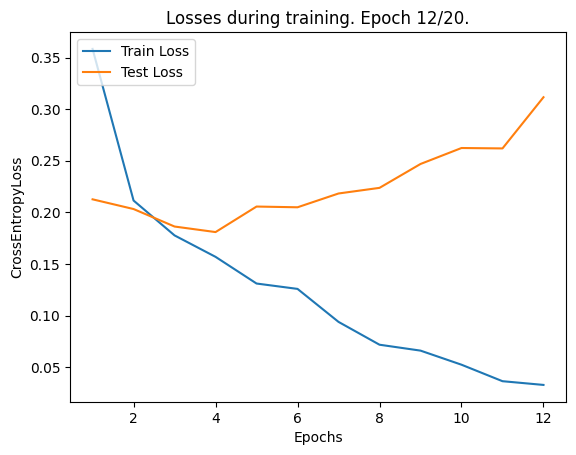

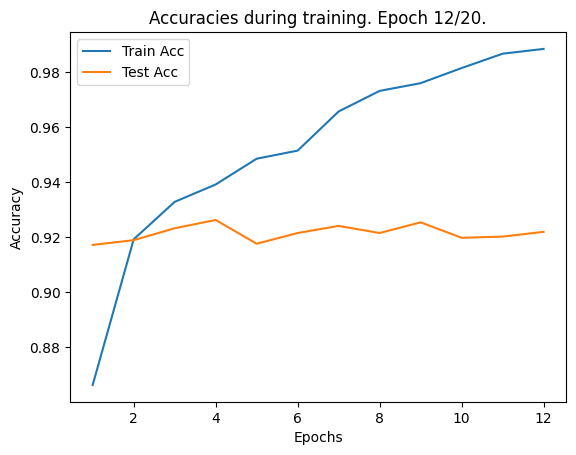

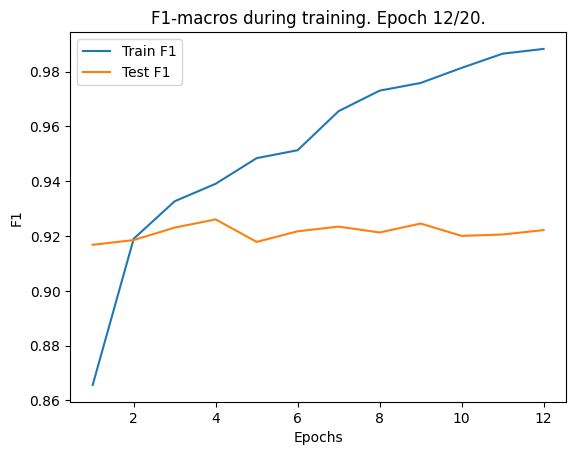

----------
Epoch Time: 0:21
Epoch 13/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:18<00:00,  4.28it/s, Loss=0.061284, Corrects=251/256, Accuracy=98.047%]


Calculating metrics...
train loss: 0.026016, acc: 0.990114, f05_macro: 0.990105, f1_macro: 0.990105
Confusion matrix:
[[5097   67    6    5]
 [  87 5081    3   14]
 [   6    3 5174    4]
 [   4    5    1 5179]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.69it/s, Loss=0.001366, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.285994, acc: 0.924903, f05_macro: 0.925428, f1_macro: 0.924555
Confusion matrix:
[[532  40   3   4]
 [101 468   3   7]
 [  3   3 574   0]
 [  1   9   0 569]]


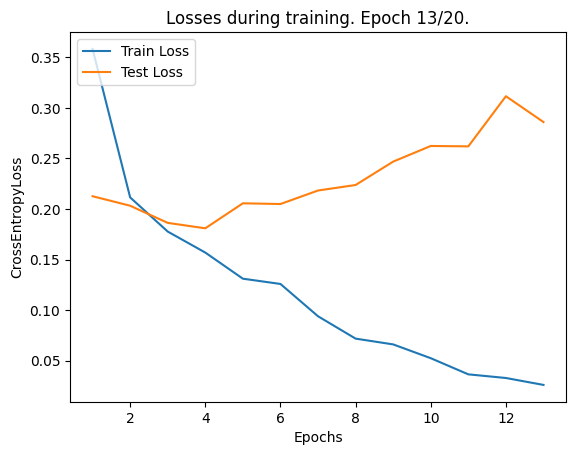

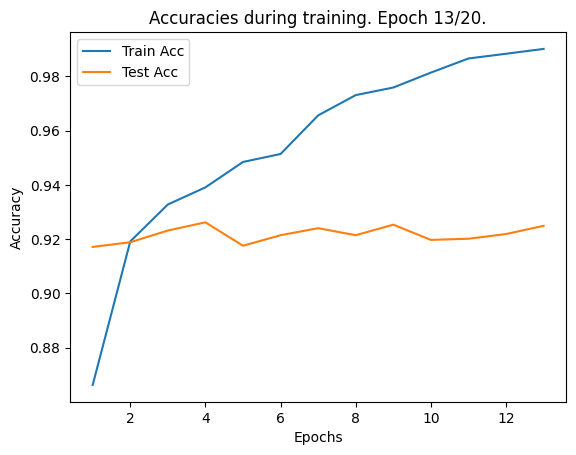

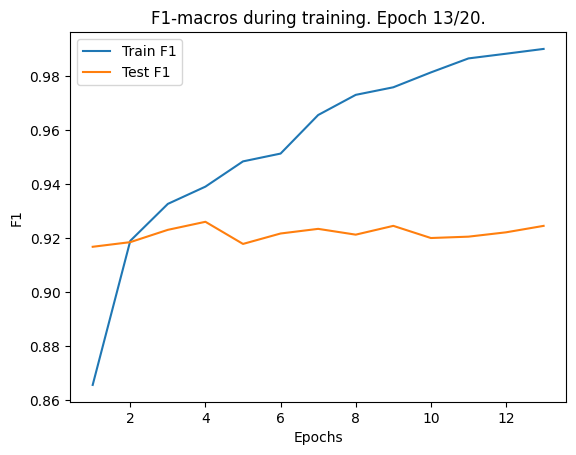

----------
Epoch Time: 0:21
Epoch 14/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:17<00:00,  4.51it/s, Loss=0.012430, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.024337, acc: 0.990789, f05_macro: 0.990785, f1_macro: 0.990785
Confusion matrix:
[[5093   74    5    2]
 [  83 5097    2    6]
 [   3    2 5176    3]
 [   3    8    0 5179]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.47it/s, Loss=0.053111, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.383195, acc: 0.905050, f05_macro: 0.908696, f1_macro: 0.905186
Confusion matrix:
[[434 141   2   2]
 [ 41 533   1   4]
 [  2   6 572   0]
 [  4  15   2 558]]


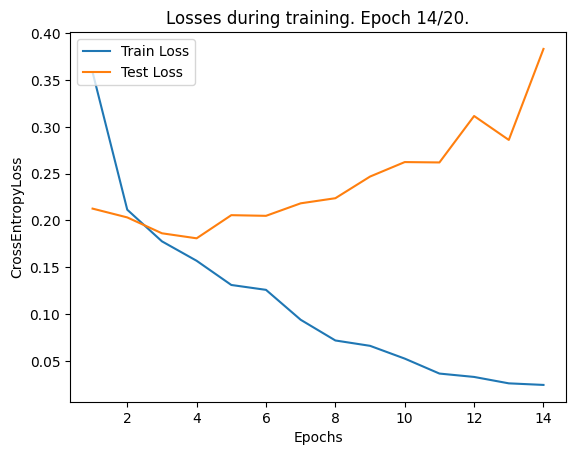

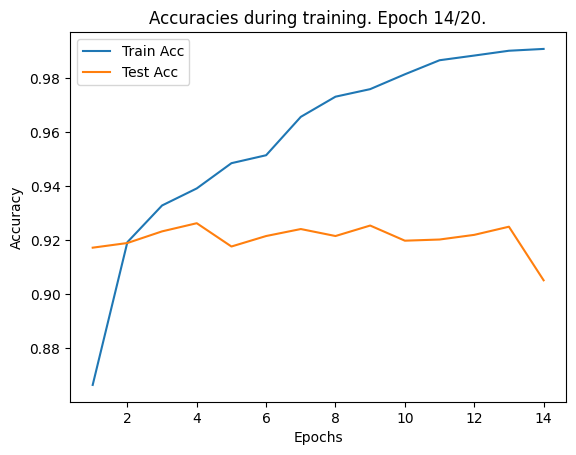

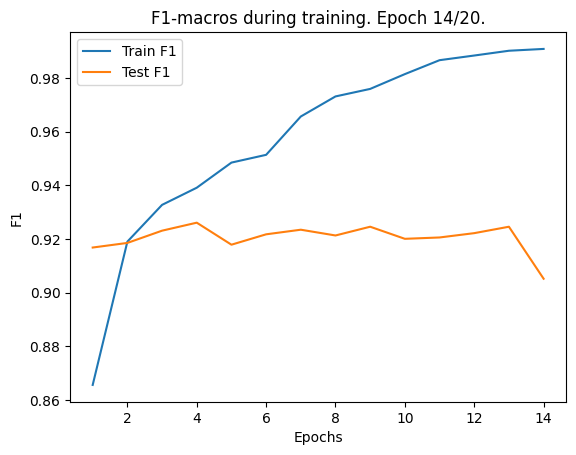

----------
Epoch Time: 0:21
Epoch 15/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:18<00:00,  4.29it/s, Loss=0.036757, Corrects=252/256, Accuracy=98.438%]


Calculating metrics...
train loss: 0.021807, acc: 0.992091, f05_macro: 0.992090, f1_macro: 0.992089
Confusion matrix:
[[5119   61    1    5]
 [  65 5102    0   11]
 [   2    2 5178    3]
 [   7    7    0 5173]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.37it/s, Loss=0.003655, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.314361, acc: 0.927924, f05_macro: 0.928517, f1_macro: 0.927788
Confusion matrix:
[[531  44   1   3]
 [ 92 477   2   8]
 [  5   2 573   0]
 [  3   7   0 569]]


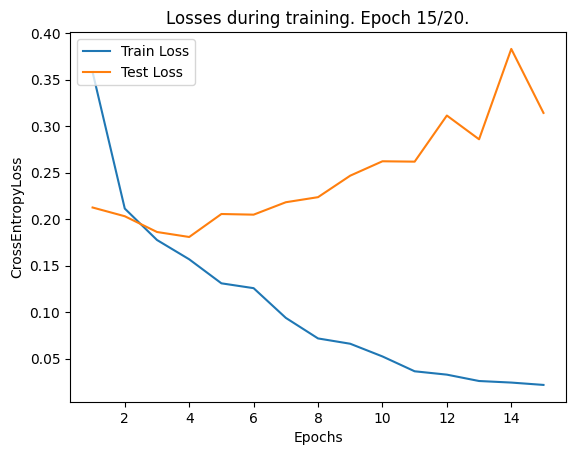

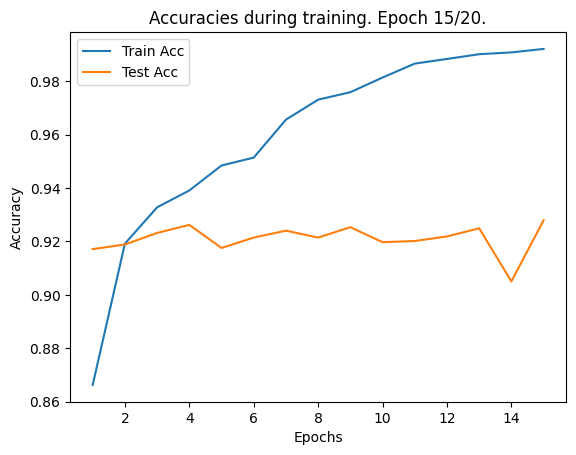

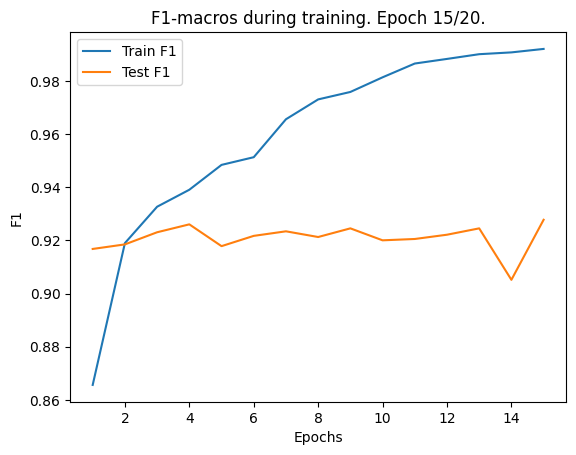

----------
Epoch Time: 0:22
Epoch 16/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:18<00:00,  4.37it/s, Loss=0.016073, Corrects=255/256, Accuracy=99.609%]


Calculating metrics...
train loss: 0.014383, acc: 0.995033, f05_macro: 0.995032, f1_macro: 0.995032
Confusion matrix:
[[5141   31    1    3]
 [  37 5141    0   14]
 [   2    1 5182    2]
 [   5    6    1 5169]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.55it/s, Loss=0.011825, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.313970, acc: 0.925334, f05_macro: 0.925097, f1_macro: 0.925030
Confusion matrix:
[[489  82   2   6]
 [ 55 509   3  12]
 [  4   2 572   2]
 [  1   4   0 574]]


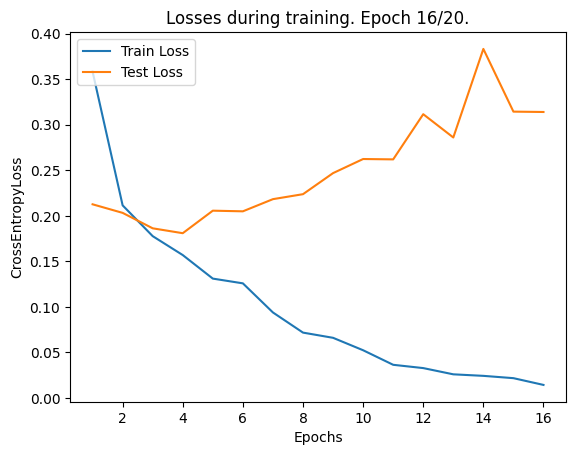

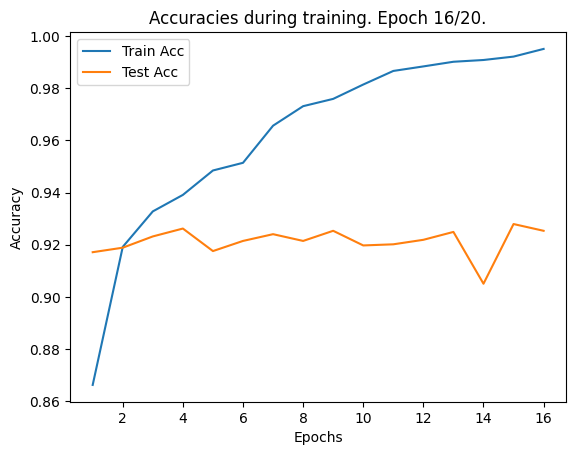

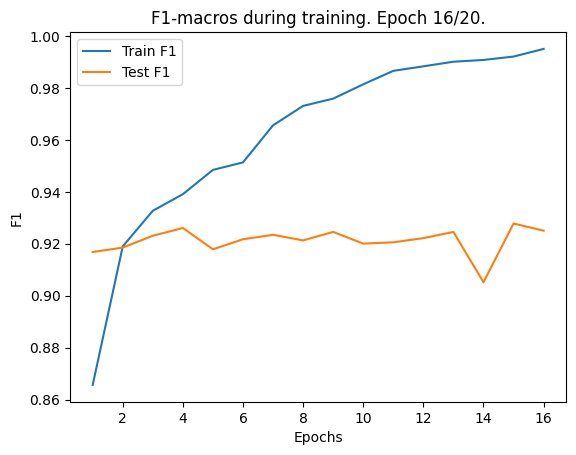

----------
Epoch Time: 0:21
Epoch 17/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:19<00:00,  4.21it/s, Loss=0.022552, Corrects=255/256, Accuracy=99.609%]


Calculating metrics...
train loss: 0.019081, acc: 0.993104, f05_macro: 0.993105, f1_macro: 0.993105
Confusion matrix:
[[5129   50    3    6]
 [  49 5122    2   10]
 [   2    3 5177    1]
 [   4   11    2 5165]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.66it/s, Loss=0.007281, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.300191, acc: 0.928356, f05_macro: 0.928530, f1_macro: 0.928409
Confusion matrix:
[[515  61   0   3]
 [ 72 496   0  11]
 [  5   5 569   1]
 [  1   7   0 571]]


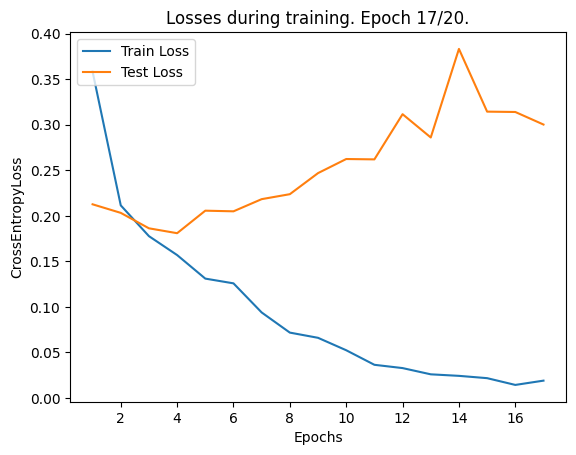

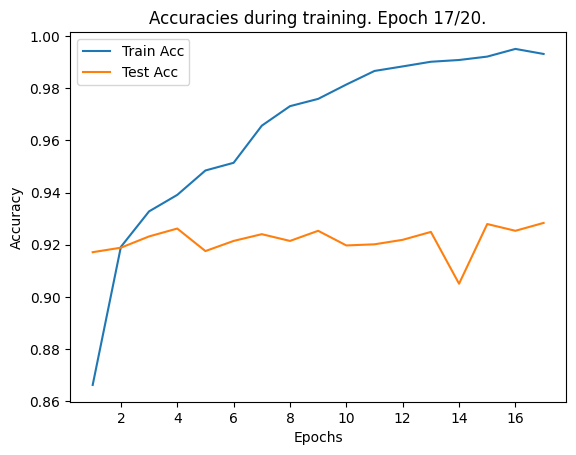

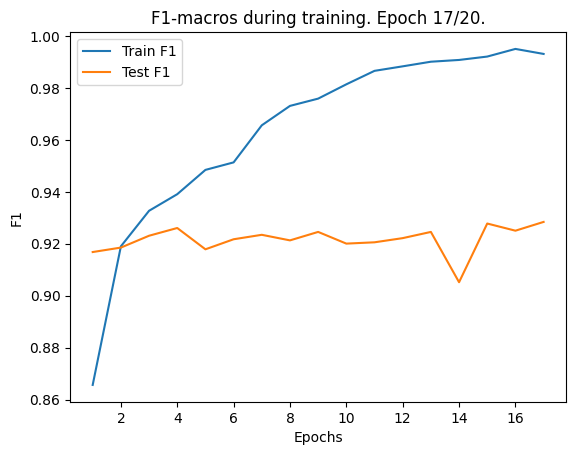

----------
Epoch Time: 0:22
Epoch 18/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:19<00:00,  4.22it/s, Loss=0.029511, Corrects=255/256, Accuracy=99.609%]


Calculating metrics...
train loss: 0.011242, acc: 0.996094, f05_macro: 0.996093, f1_macro: 0.996093
Confusion matrix:
[[5147   33    3    3]
 [  21 5152    0    9]
 [   1    1 5181    2]
 [   4    4    0 5175]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.58it/s, Loss=0.001992, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.365051, acc: 0.931808, f05_macro: 0.932345, f1_macro: 0.931743
Confusion matrix:
[[534  41   0   4]
 [ 85 485   2   7]
 [  5   2 572   1]
 [  2   9   0 568]]


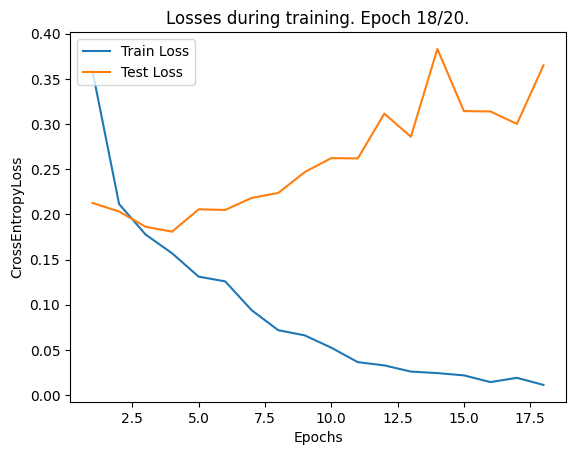

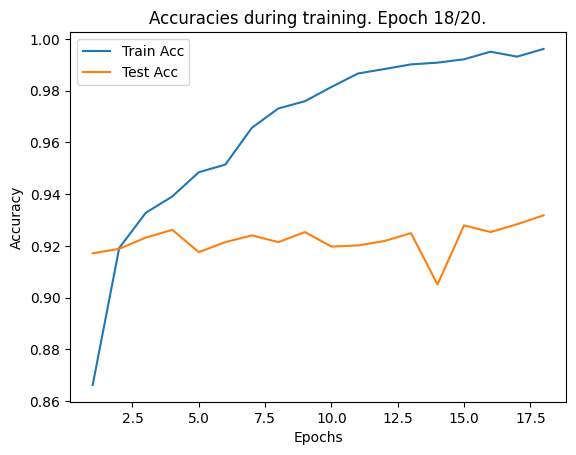

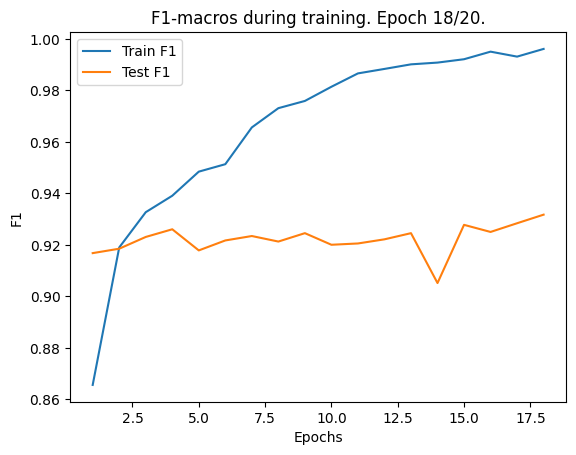

----------
Epoch Time: 0:22
Epoch 19/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:18<00:00,  4.31it/s, Loss=0.025785, Corrects=255/256, Accuracy=99.609%]


Calculating metrics...
train loss: 0.010295, acc: 0.996142, f05_macro: 0.996141, f1_macro: 0.996140
Confusion matrix:
[[5158   24    2    4]
 [  27 5138    1    7]
 [   0    2 5179    4]
 [   5    4    0 5181]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.43it/s, Loss=0.008010, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.368368, acc: 0.924471, f05_macro: 0.924824, f1_macro: 0.924616
Confusion matrix:
[[497  77   1   4]
 [ 62 507   0  10]
 [  5   5 569   1]
 [  1   9   0 569]]


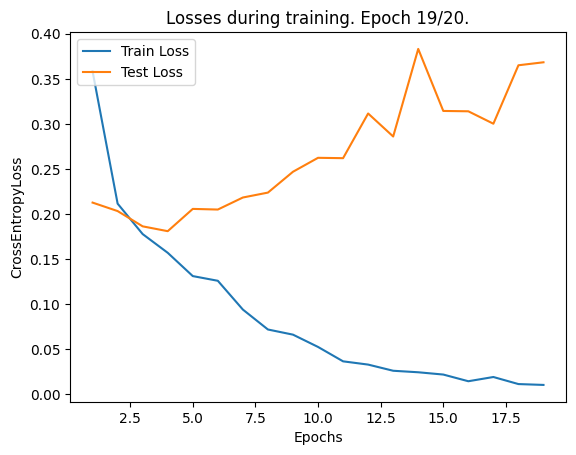

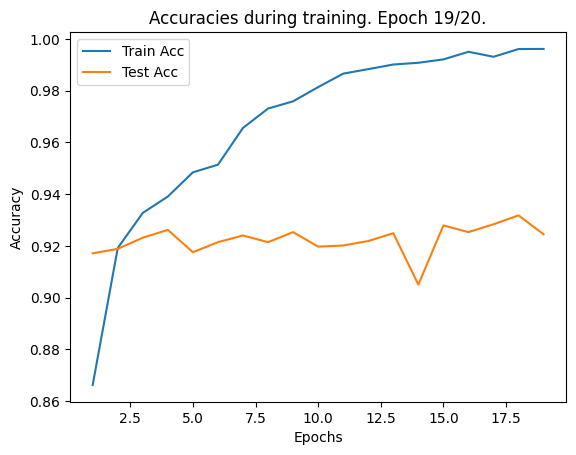

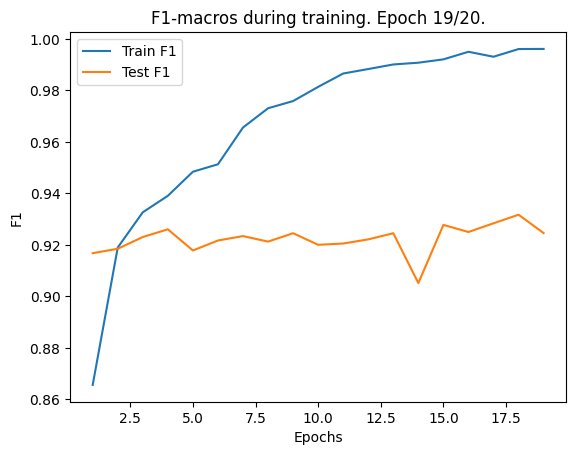

----------
Epoch Time: 0:22
Epoch 20/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:18<00:00,  4.42it/s, Loss=0.128146, Corrects=248/256, Accuracy=96.875%]


Calculating metrics...
train loss: 0.021276, acc: 0.992959, f05_macro: 0.992960, f1_macro: 0.992960
Confusion matrix:
[[5138   29    5   10]
 [  33 5128    3   26]
 [   7    2 5170    2]
 [   8   20    1 5154]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.48it/s, Loss=0.004559, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.388810, acc: 0.904618, f05_macro: 0.907485, f1_macro: 0.905855
Confusion matrix:
[[508  67   2   2]
 [ 76 499   2   2]
 [  5   4 571   0]
 [ 21  39   1 518]]


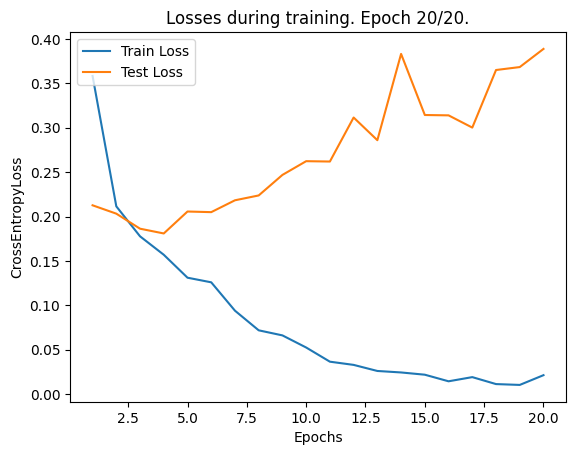

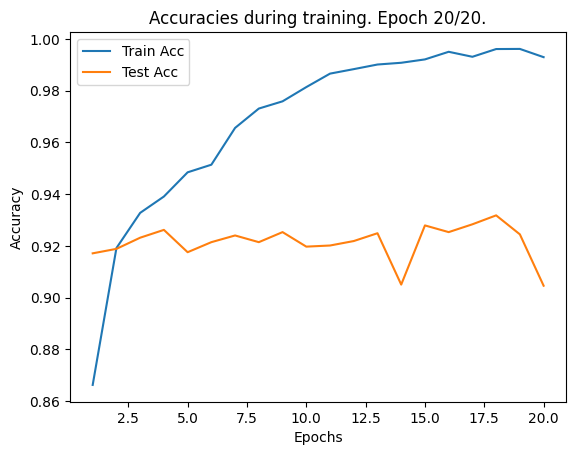

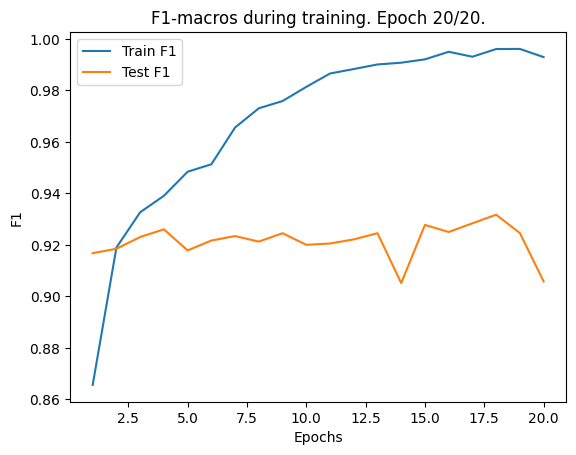

----------
Epoch Time: 0:21
*** Training Completed ***
Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  6.88it/s, Loss=0.201638, Corrects=235/256, Accuracy=91.797%]


Calculating metrics...
train loss: 1.902684, acc: 0.814091, f05_macro: 0.811786, f1_macro: 0.812535
Confusion matrix:
[[3616 1128  215  229]
 [1155 3625  165  233]
 [ 119  145 4829   83]
 [ 137  132  114 4811]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.07it/s, Loss=0.196452, Corrects=13/13, Accuracy=100.000%]


Calculating metrics...
test loss: 0.215709, acc: 0.914545, f05_macro: 0.914623, f1_macro: 0.914536
Confusion matrix:
[[484  89   1   5]
 [ 77 493   0   9]
 [  4   5 570   1]
 [  1   5   1 572]]
----------
Epoch Time: 0:13
Epoch 2/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  6.85it/s, Loss=0.211965, Corrects=239/256, Accuracy=93.359%]


Calculating metrics...
train loss: 0.243140, acc: 0.908999, f05_macro: 0.909386, f1_macro: 0.908912
Confusion matrix:
[[4526  601   21   35]
 [ 961 4129   16   87]
 [  57   30 5094    4]
 [  26   44    5 5100]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.21it/s, Loss=0.192047, Corrects=12/13, Accuracy=92.308%]


Calculating metrics...
test loss: 0.212857, acc: 0.915408, f05_macro: 0.915928, f1_macro: 0.915463
Confusion matrix:
[[472 101   0   6]
 [ 68 506   0   5]
 [  5   4 570   1]
 [  0   6   0 573]]


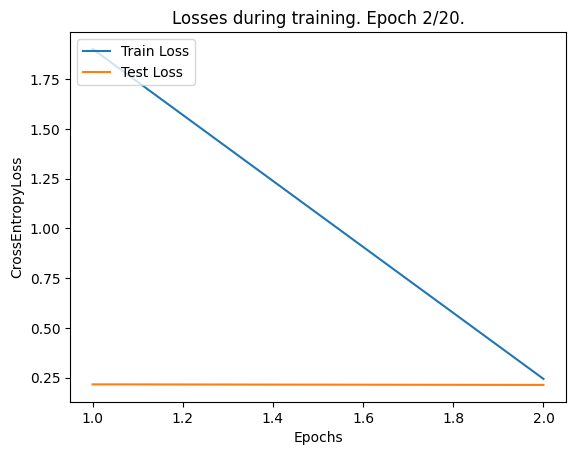

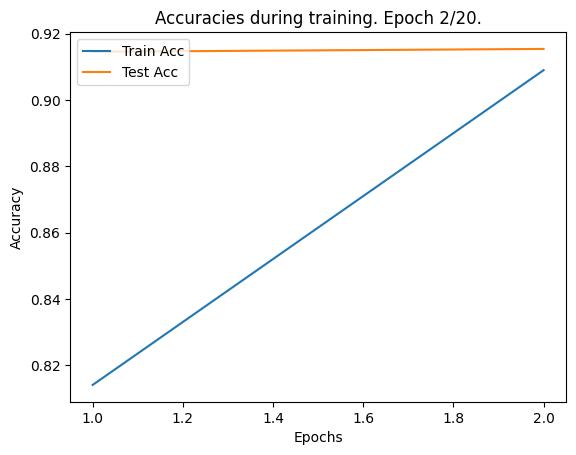

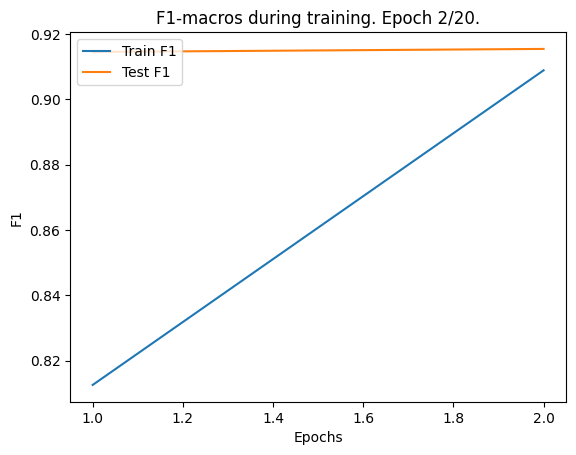

----------
Epoch Time: 0:13
Epoch 3/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  6.89it/s, Loss=0.243010, Corrects=234/256, Accuracy=91.406%]


Calculating metrics...
train loss: 0.216296, acc: 0.914786, f05_macro: 0.915128, f1_macro: 0.914674
Confusion matrix:
[[4582  562   21   27]
 [ 899 4181   10   90]
 [  52   21 5103    7]
 [  27   46    5 5103]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.80it/s, Loss=0.189847, Corrects=13/13, Accuracy=100.000%]


Calculating metrics...
test loss: 0.194769, acc: 0.921019, f05_macro: 0.921149, f1_macro: 0.921052
Confusion matrix:
[[504  70   1   4]
 [ 86 487   0   6]
 [  3   5 571   1]
 [  0   6   1 572]]


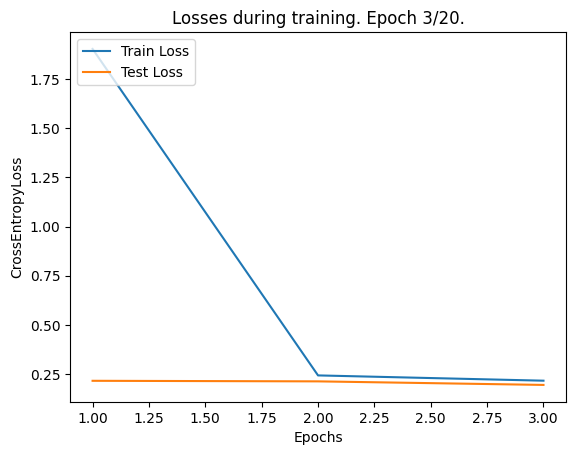

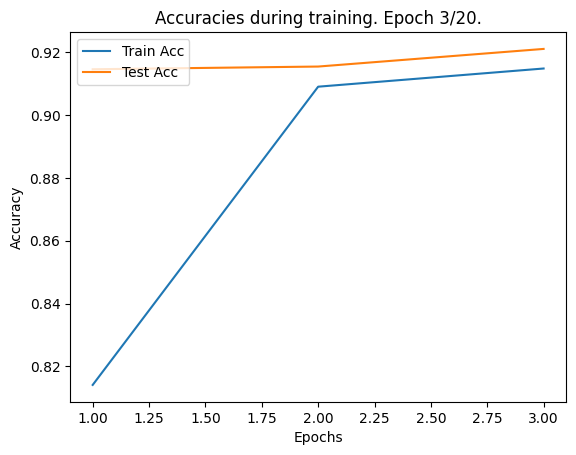

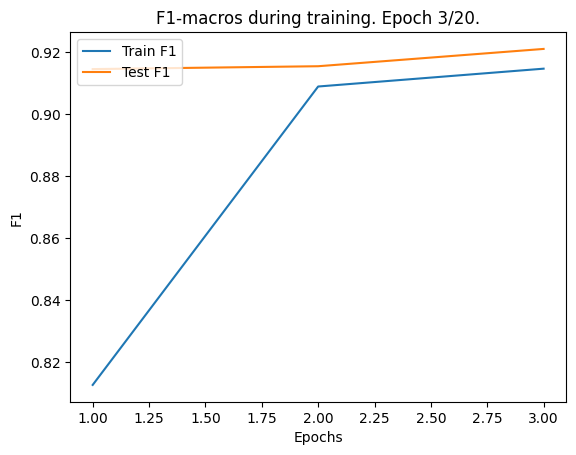

----------
Epoch Time: 0:13
Epoch 4/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  6.95it/s, Loss=0.197248, Corrects=237/256, Accuracy=92.578%]


Calculating metrics...
train loss: 0.216978, acc: 0.916763, f05_macro: 0.917121, f1_macro: 0.916551
Confusion matrix:
[[4630  497   25   33]
 [ 902 4177   18   89]
 [  48   32 5098    8]
 [  24   43    7 5105]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.95it/s, Loss=0.218094, Corrects=12/13, Accuracy=92.308%]


Calculating metrics...
test loss: 0.218976, acc: 0.916271, f05_macro: 0.917432, f1_macro: 0.916002
Confusion matrix:
[[456 117   1   5]
 [ 47 523   1   8]
 [  4   6 569   1]
 [  0   3   1 575]]


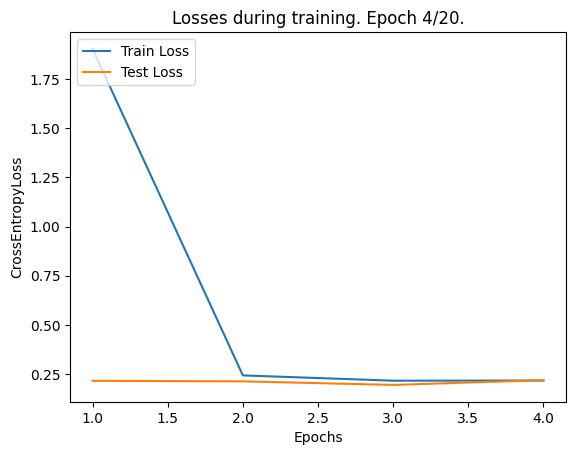

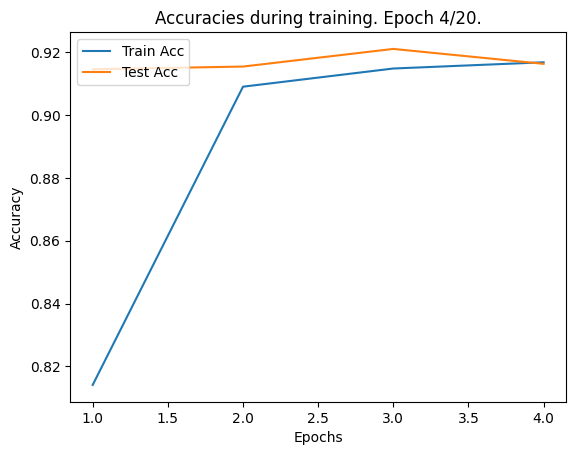

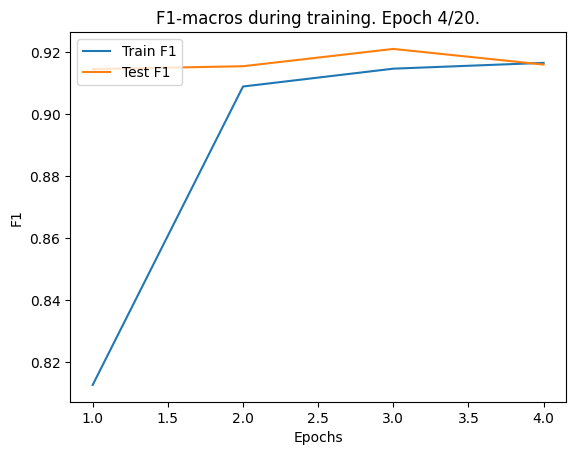

----------
Epoch Time: 0:13
Epoch 5/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  6.90it/s, Loss=0.261013, Corrects=230/256, Accuracy=89.844%]


Calculating metrics...
train loss: 0.203487, acc: 0.921682, f05_macro: 0.921910, f1_macro: 0.921592
Confusion matrix:
[[4614  520   24   27]
 [ 815 4279   17   77]
 [  47   23 5100    7]
 [  21   44    2 5119]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.77it/s, Loss=0.218387, Corrects=13/13, Accuracy=100.000%]


Calculating metrics...
test loss: 0.232521, acc: 0.920587, f05_macro: 0.919649, f1_macro: 0.919890
Confusion matrix:
[[495  77   1   6]
 [ 71 485   4  19]
 [  4   0 575   1]
 [  0   1   0 578]]


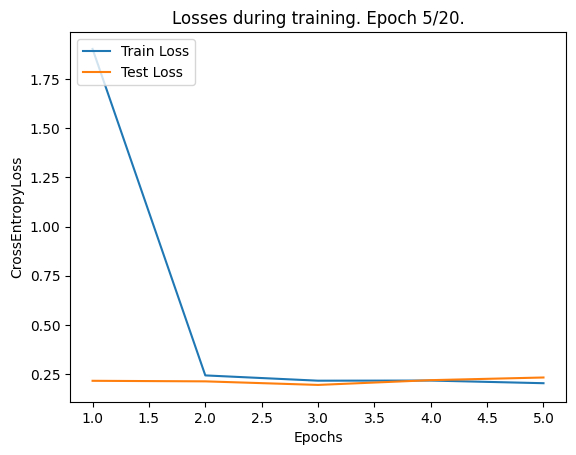

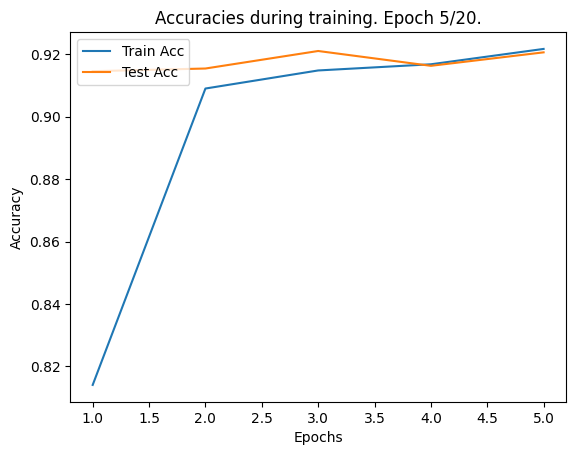

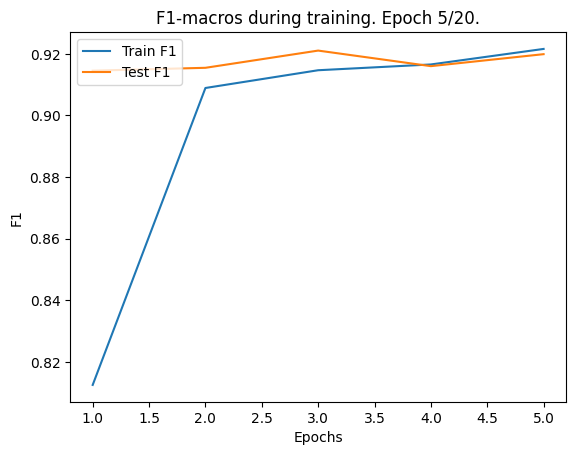

----------
Epoch Time: 0:13
Epoch 6/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  7.05it/s, Loss=0.325956, Corrects=222/256, Accuracy=86.719%]


Calculating metrics...
train loss: 0.208187, acc: 0.917824, f05_macro: 0.918069, f1_macro: 0.917616
Confusion matrix:
[[4612  513   28   37]
 [ 888 4197   18   80]
 [  36   23 5115    6]
 [  28   44    3 5108]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.16it/s, Loss=0.214617, Corrects=12/13, Accuracy=92.308%]


Calculating metrics...
test loss: 0.216405, acc: 0.914113, f05_macro: 0.915484, f1_macro: 0.913814
Confusion matrix:
[[450 125   1   3]
 [ 48 522   0   9]
 [  3   5 571   1]
 [  0   3   1 575]]


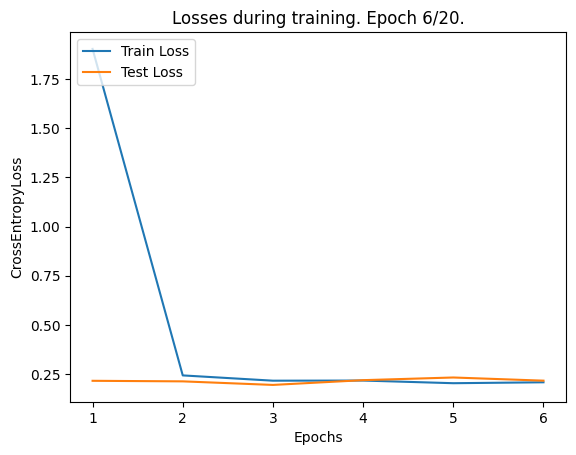

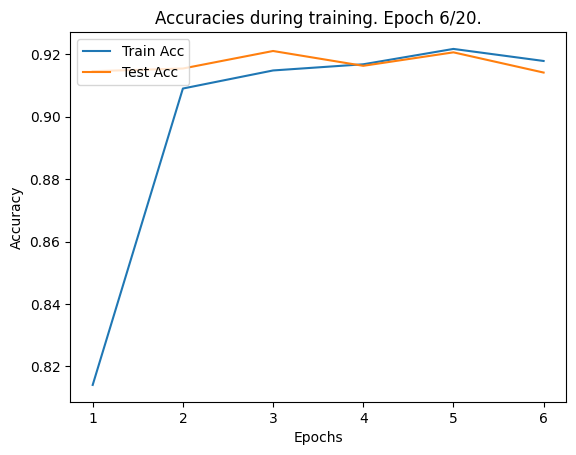

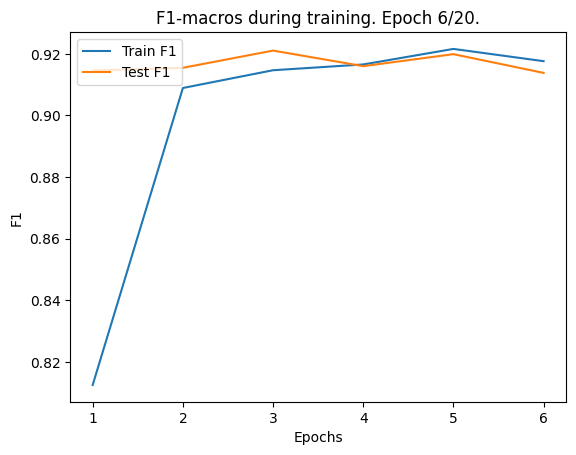

----------
Epoch Time: 0:13
Epoch 7/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  7.10it/s, Loss=0.277318, Corrects=231/256, Accuracy=90.234%]


Calculating metrics...
train loss: 0.197614, acc: 0.922984, f05_macro: 0.923220, f1_macro: 0.922793
Confusion matrix:
[[4666  478   22   25]
 [ 827 4250   23   82]
 [  39   23 5113    7]
 [  22   44    5 5110]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.79it/s, Loss=0.152296, Corrects=13/13, Accuracy=100.000%]


Calculating metrics...
test loss: 0.201794, acc: 0.921882, f05_macro: 0.922371, f1_macro: 0.922112
Confusion matrix:
[[491  87   0   1]
 [ 71 502   0   6]
 [  3   4 572   1]
 [  1   7   0 571]]


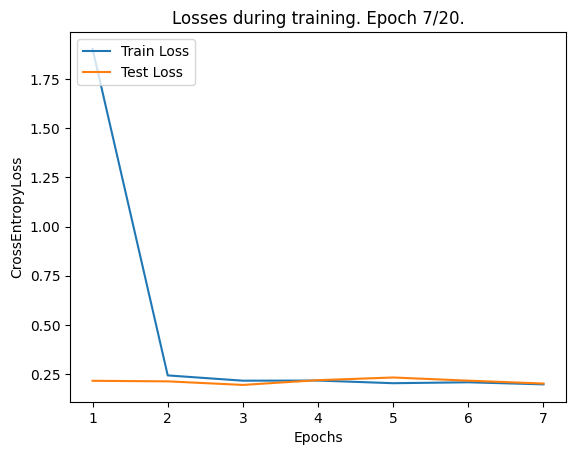

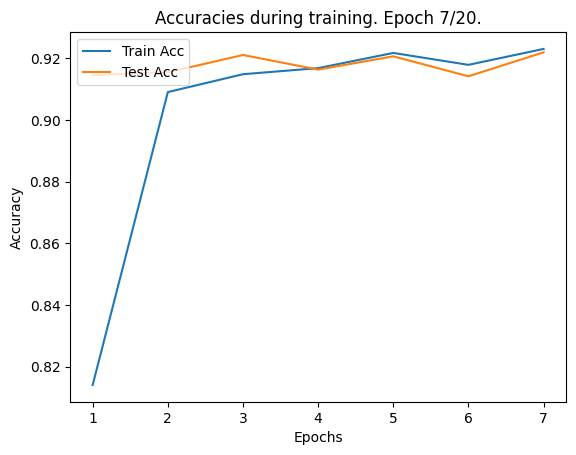

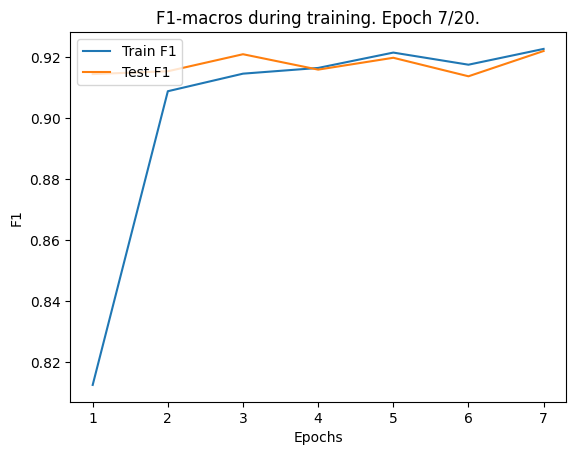

----------
Epoch Time: 0:13
Epoch 8/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  7.00it/s, Loss=0.281841, Corrects=226/256, Accuracy=88.281%]


Calculating metrics...
train loss: 0.185862, acc: 0.928868, f05_macro: 0.928923, f1_macro: 0.928673
Confusion matrix:
[[4686  443   28   31]
 [ 743 4340   16   86]
 [  30   25 5118    5]
 [  15   47    6 5117]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.02it/s, Loss=0.184536, Corrects=12/13, Accuracy=92.308%]


Calculating metrics...
test loss: 0.196101, acc: 0.923177, f05_macro: 0.923566, f1_macro: 0.923232
Confusion matrix:
[[485  90   0   4]
 [ 63 509   1   6]
 [  2   4 573   1]
 [  0   7   0 572]]


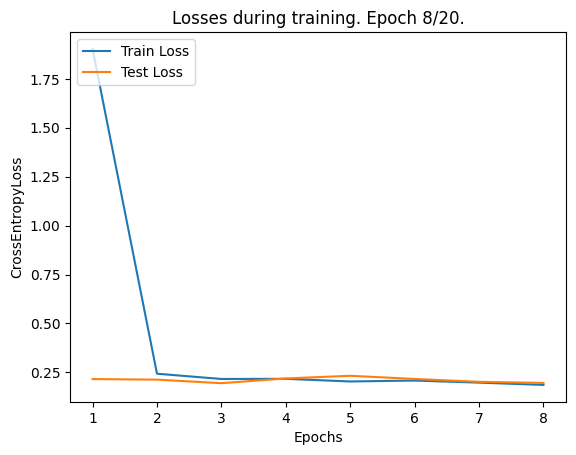

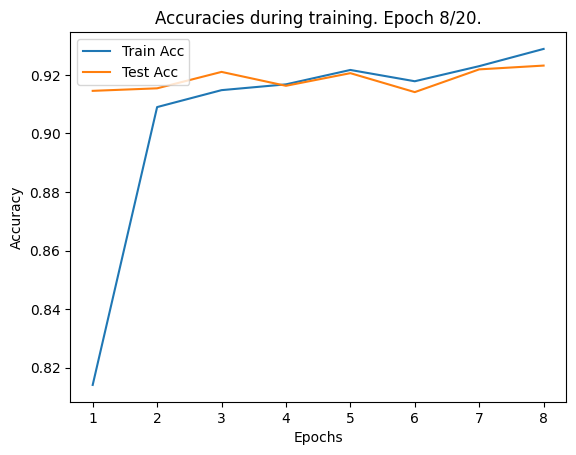

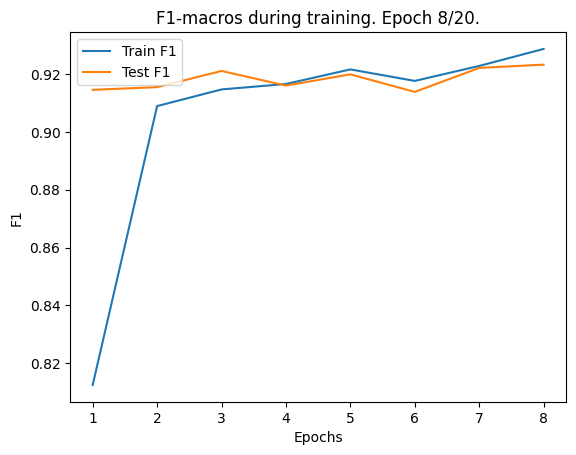

----------
Epoch Time: 0:13
Epoch 9/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  7.07it/s, Loss=0.166091, Corrects=238/256, Accuracy=92.969%]


Calculating metrics...
train loss: 0.188991, acc: 0.924142, f05_macro: 0.924225, f1_macro: 0.923991
Confusion matrix:
[[4620  515   21   34]
 [ 768 4312   17   81]
 [  40   15 5123    7]
 [  30   40    5 5108]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.46it/s, Loss=0.193926, Corrects=13/13, Accuracy=100.000%]


Calculating metrics...
test loss: 0.211755, acc: 0.921882, f05_macro: 0.922664, f1_macro: 0.922239
Confusion matrix:
[[490  85   0   4]
 [ 68 508   0   3]
 [  2   5 572   1]
 [  2  11   0 566]]


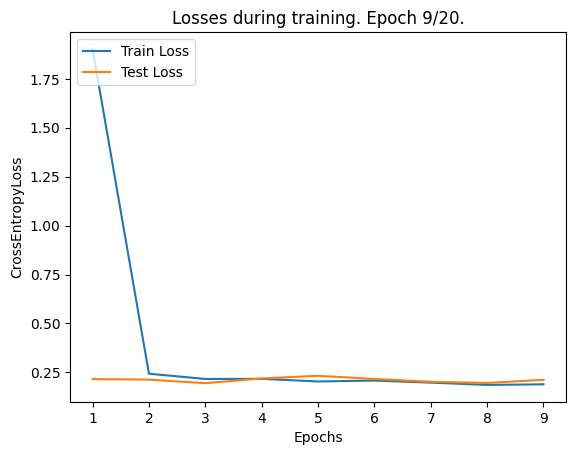

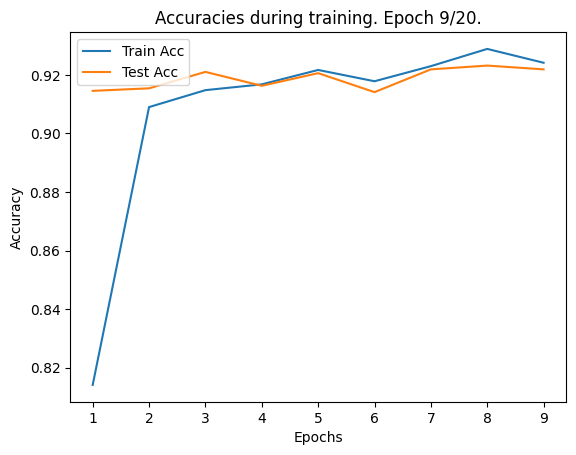

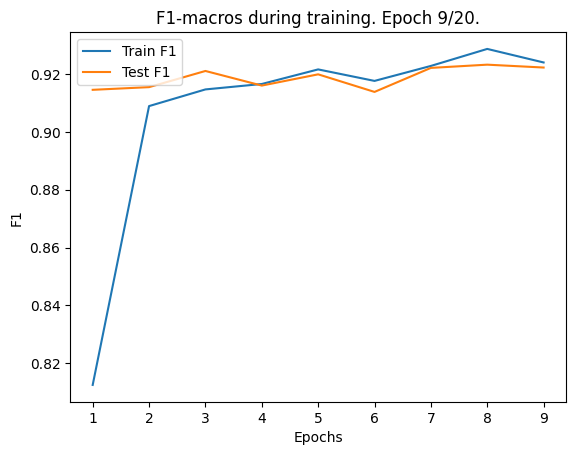

----------
Epoch Time: 0:13
Epoch 10/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  7.23it/s, Loss=0.158371, Corrects=239/256, Accuracy=93.359%]


Calculating metrics...
train loss: 0.174758, acc: 0.930411, f05_macro: 0.930608, f1_macro: 0.930269
Confusion matrix:
[[4687  449   23   26]
 [ 766 4345   11   58]
 [  32   20 5123    5]
 [  14   37    2 5138]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.32it/s, Loss=0.276913, Corrects=11/13, Accuracy=84.615%]


Calculating metrics...
test loss: 0.242362, acc: 0.895986, f05_macro: 0.900832, f1_macro: 0.894326
Confusion matrix:
[[388 186   0   5]
 [ 30 542   1   6]
 [  3   5 571   1]
 [  0   4   0 575]]


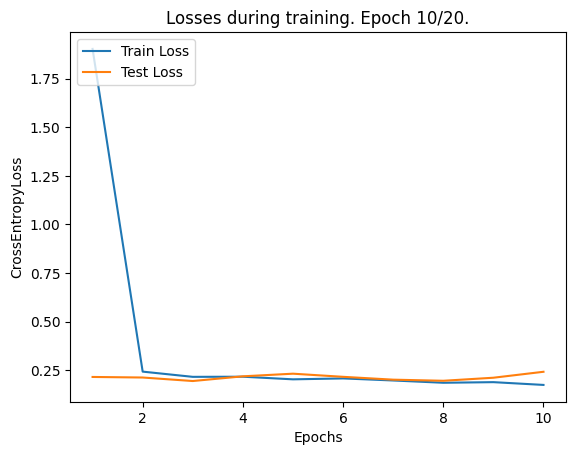

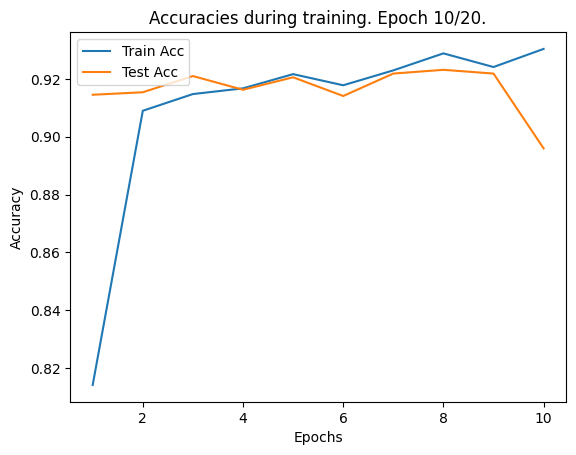

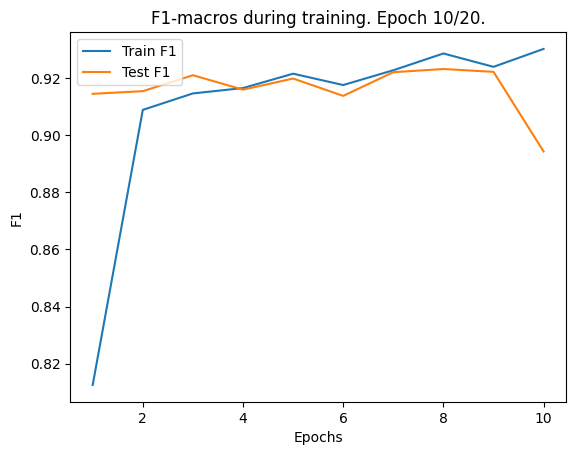

----------
Epoch Time: 0:13
Epoch 11/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:10<00:00,  7.40it/s, Loss=0.181791, Corrects=231/256, Accuracy=90.234%]


Calculating metrics...
train loss: 0.180257, acc: 0.931472, f05_macro: 0.931573, f1_macro: 0.931347
Confusion matrix:
[[4680  459   17   26]
 [ 724 4381   14   63]
 [  31   26 5119    6]
 [  10   43    2 5135]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.27it/s, Loss=0.196821, Corrects=12/13, Accuracy=92.308%]


Calculating metrics...
test loss: 0.206173, acc: 0.923177, f05_macro: 0.923973, f1_macro: 0.923172
Confusion matrix:
[[473 102   0   4]
 [ 53 521   0   5]
 [  4   5 570   1]
 [  1   3   0 575]]


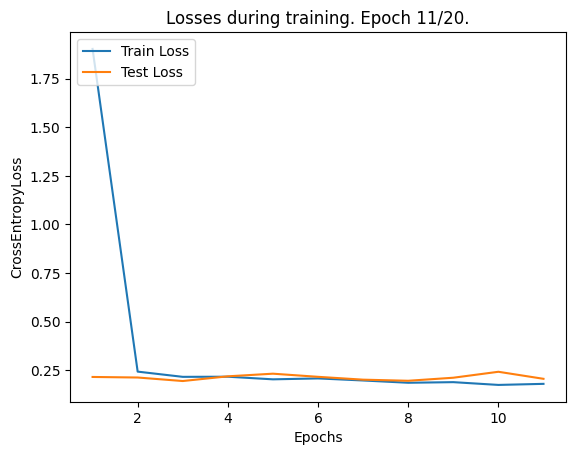

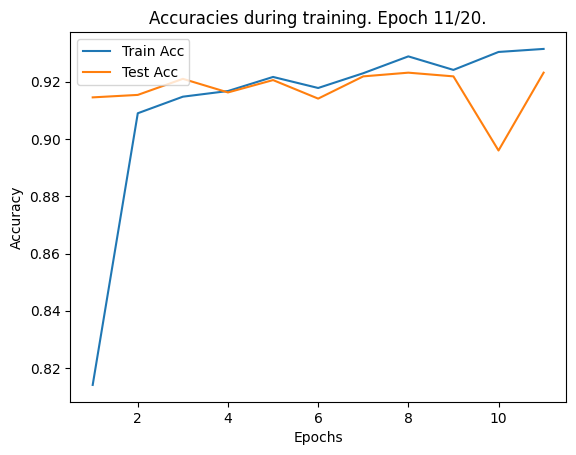

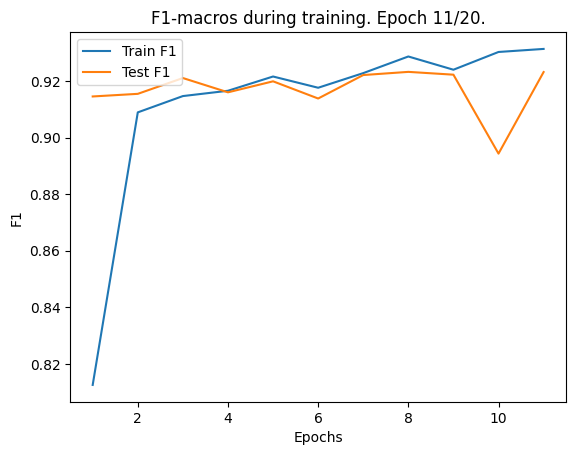

----------
Epoch Time: 0:12
Epoch 12/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  6.88it/s, Loss=0.148819, Corrects=240/256, Accuracy=93.750%]


Calculating metrics...
train loss: 0.181829, acc: 0.929929, f05_macro: 0.930052, f1_macro: 0.929774
Confusion matrix:
[[4687  447   25   26]
 [ 759 4348   15   69]
 [  29   19 5125    9]
 [   9   40    6 5123]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.93it/s, Loss=0.195771, Corrects=12/13, Accuracy=92.308%]


Calculating metrics...
test loss: 0.195346, acc: 0.927924, f05_macro: 0.927851, f1_macro: 0.927831
Confusion matrix:
[[497  76   4   2]
 [ 65 507   1   6]
 [  2   3 573   2]
 [  0   5   1 573]]


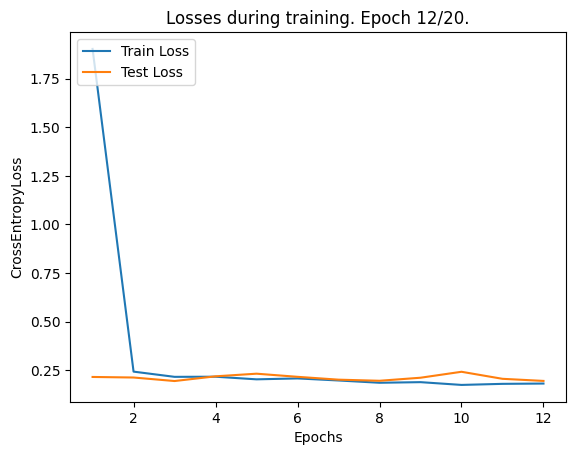

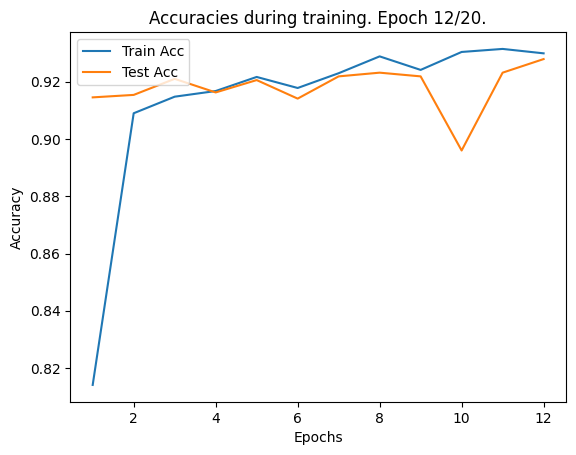

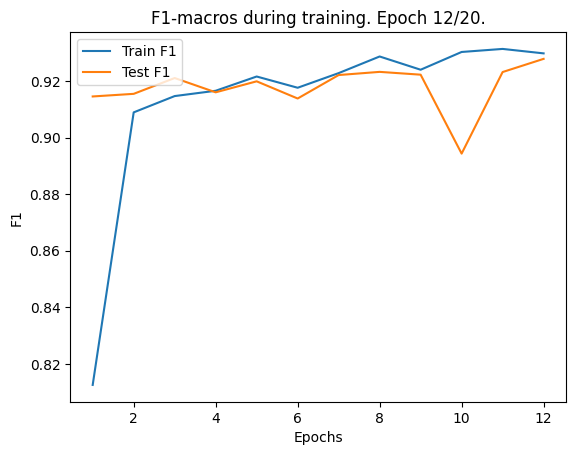

----------
Epoch Time: 0:13
Epoch 13/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  6.99it/s, Loss=0.192493, Corrects=236/256, Accuracy=92.188%]


Calculating metrics...
train loss: 0.177902, acc: 0.929398, f05_macro: 0.929671, f1_macro: 0.929287
Confusion matrix:
[[4702  451   18   19]
 [ 779 4324   12   74]
 [  32   15 5120    8]
 [  17   37    2 5126]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.80it/s, Loss=0.194842, Corrects=12/13, Accuracy=92.308%]


Calculating metrics...
test loss: 0.206091, acc: 0.923177, f05_macro: 0.923098, f1_macro: 0.923103
Confusion matrix:
[[496  78   1   4]
 [ 75 496   1   7]
 [  3   4 572   1]
 [  0   4   0 575]]


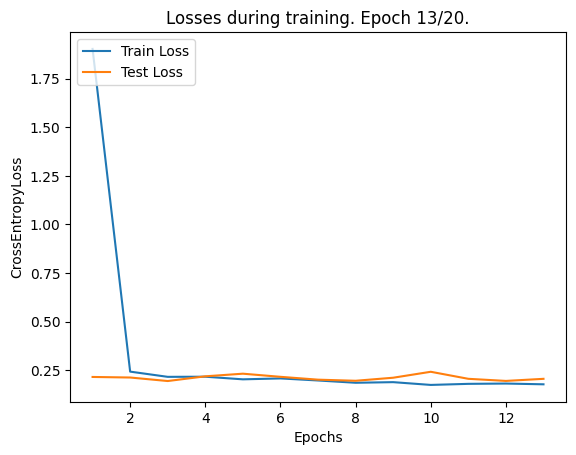

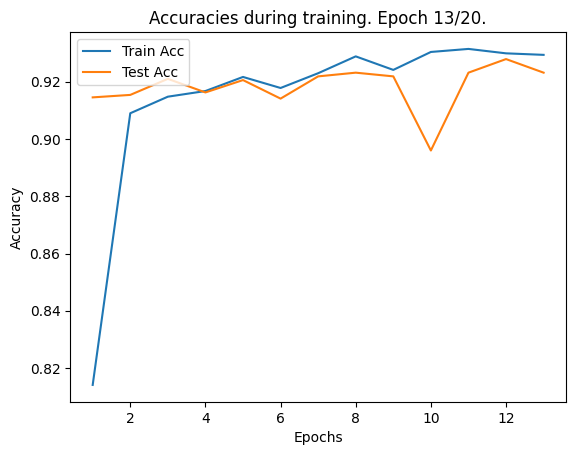

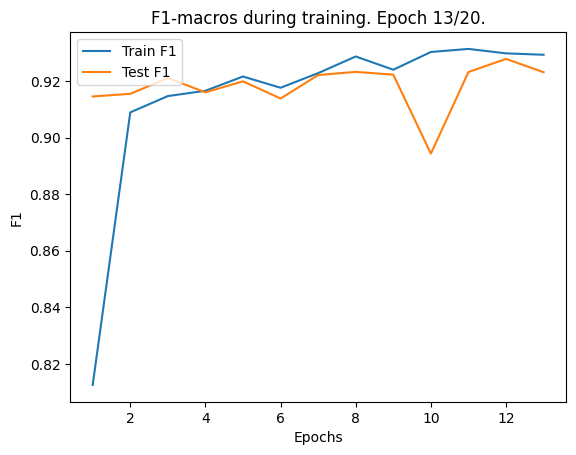

----------
Epoch Time: 0:13
Epoch 14/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  6.98it/s, Loss=0.185842, Corrects=236/256, Accuracy=92.188%]


Calculating metrics...
train loss: 0.172601, acc: 0.933449, f05_macro: 0.933647, f1_macro: 0.933345
Confusion matrix:
[[4706  443    9   27]
 [ 718 4389    8   68]
 [  36   18 5122    6]
 [  17   27    3 5139]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.91it/s, Loss=0.134477, Corrects=12/13, Accuracy=92.308%]


Calculating metrics...
test loss: 0.194392, acc: 0.927924, f05_macro: 0.927849, f1_macro: 0.927804
Confusion matrix:
[[513  60   5   1]
 [ 81 491   2   5]
 [  2   4 573   1]
 [  0   5   1 573]]


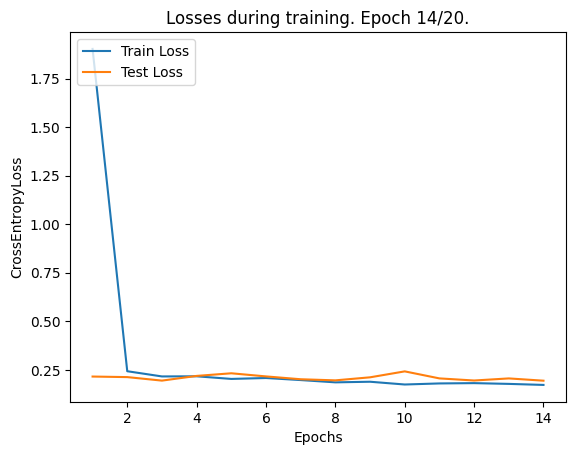

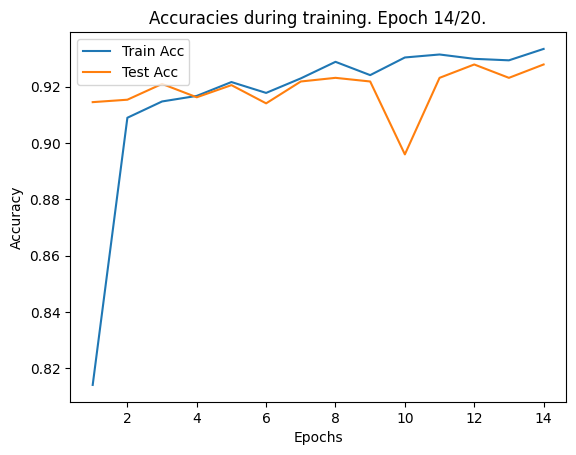

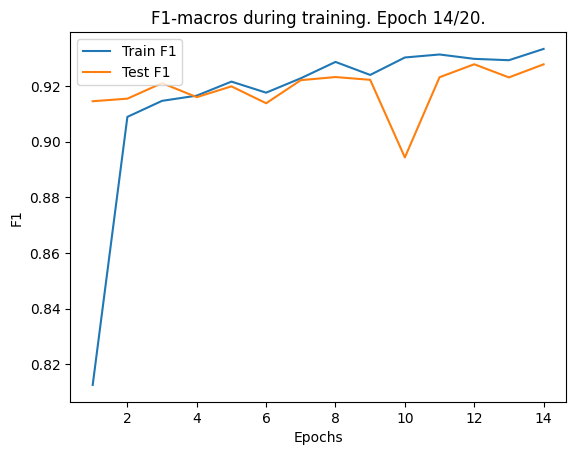

----------
Epoch Time: 0:13
Epoch 15/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  6.84it/s, Loss=0.286138, Corrects=236/256, Accuracy=92.188%]


Calculating metrics...
train loss: 0.176669, acc: 0.932292, f05_macro: 0.932421, f1_macro: 0.932109
Confusion matrix:
[[4707  434   19   20]
 [ 725 4367   21   66]
 [  35   22 5127    4]
 [  19   34    5 5131]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.04it/s, Loss=0.202711, Corrects=12/13, Accuracy=92.308%]


Calculating metrics...
test loss: 0.206335, acc: 0.926198, f05_macro: 0.927018, f1_macro: 0.926029
Confusion matrix:
[[532  42   1   4]
 [101 471   1   6]
 [  5   4 570   1]
 [  1   5   0 573]]


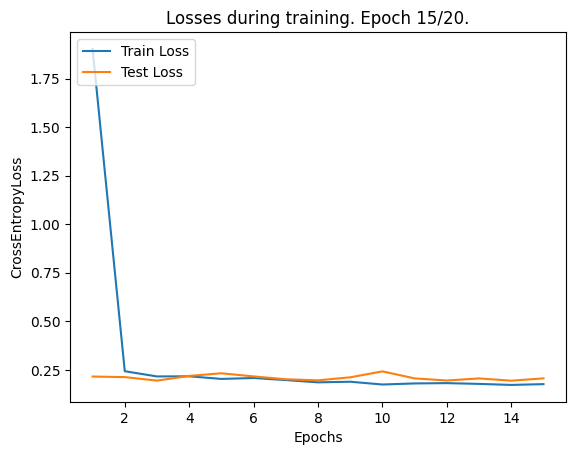

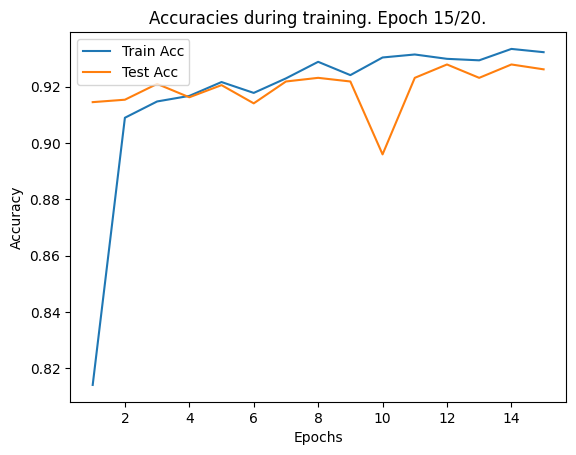

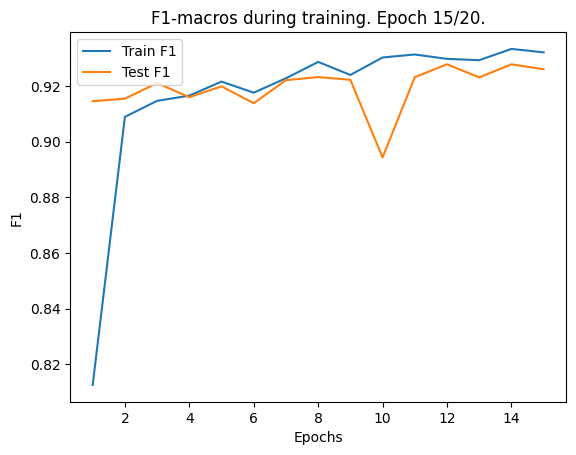

----------
Epoch Time: 0:13
Epoch 16/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  6.91it/s, Loss=0.175045, Corrects=238/256, Accuracy=92.969%]


Calculating metrics...
train loss: 0.170541, acc: 0.934414, f05_macro: 0.934539, f1_macro: 0.934298
Confusion matrix:
[[4702  433   21   23]
 [ 707 4409   13   63]
 [  27   23 5127    4]
 [  17   27    2 5138]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.90it/s, Loss=0.110966, Corrects=13/13, Accuracy=100.000%]


Calculating metrics...
test loss: 0.186087, acc: 0.930945, f05_macro: 0.931328, f1_macro: 0.930813
Confusion matrix:
[[527  48   0   4]
 [ 89 483   0   7]
 [  4   4 571   1]
 [  1   2   0 576]]


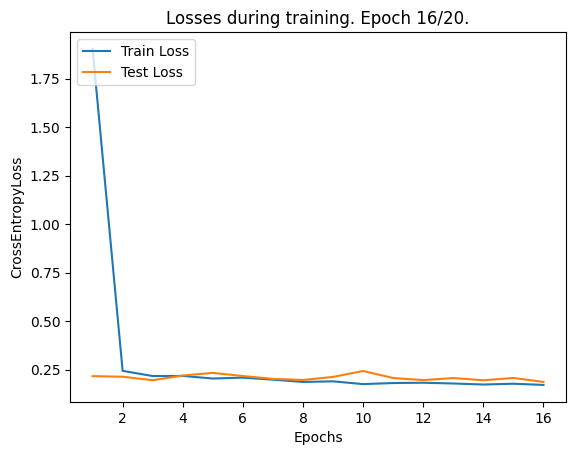

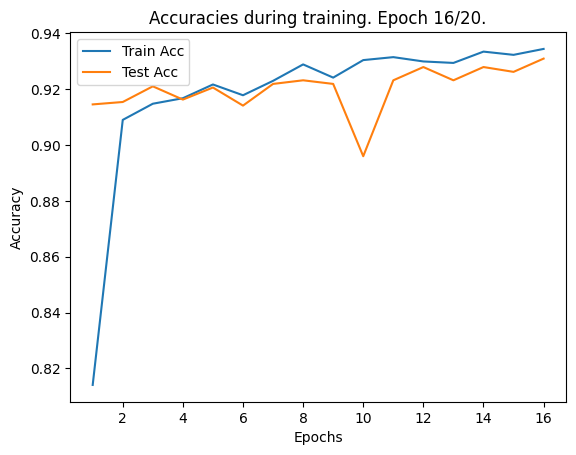

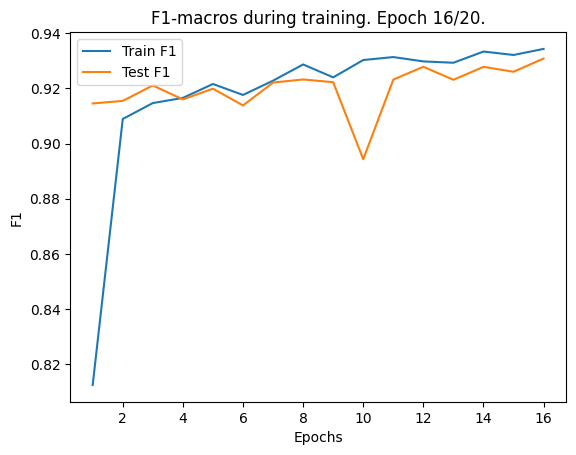

----------
Epoch Time: 0:13
Epoch 17/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  7.01it/s, Loss=0.157970, Corrects=236/256, Accuracy=92.188%]


Calculating metrics...
train loss: 0.170511, acc: 0.932340, f05_macro: 0.932719, f1_macro: 0.932192
Confusion matrix:
[[4744  411   15   14]
 [ 784 4325   16   63]
 [  30   23 5121    3]
 [  19   22    3 5143]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.16it/s, Loss=0.108061, Corrects=13/13, Accuracy=100.000%]


Calculating metrics...
test loss: 0.187068, acc: 0.928356, f05_macro: 0.929578, f1_macro: 0.928084
Confusion matrix:
[[542  34   0   3]
 [108 465   1   5]
 [  3   4 572   1]
 [  1   6   0 572]]


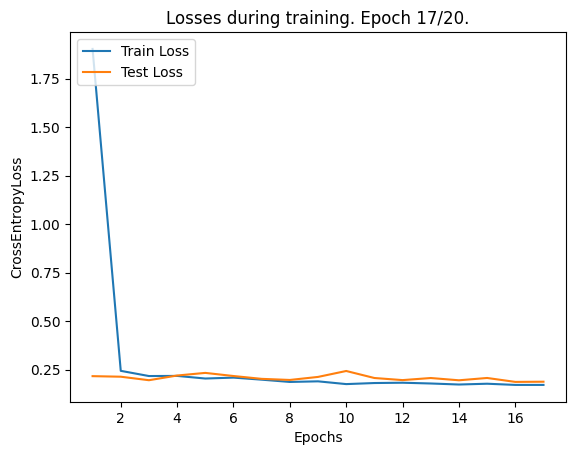

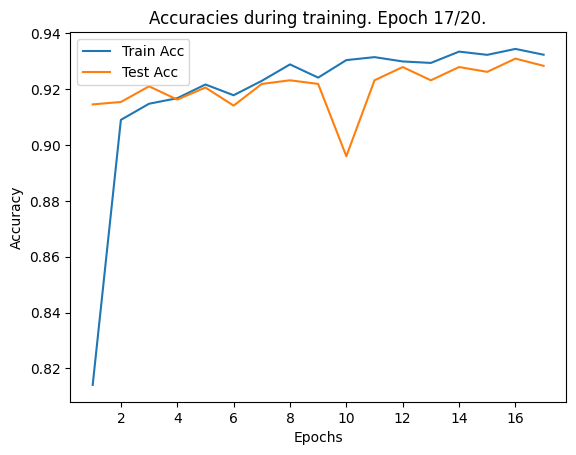

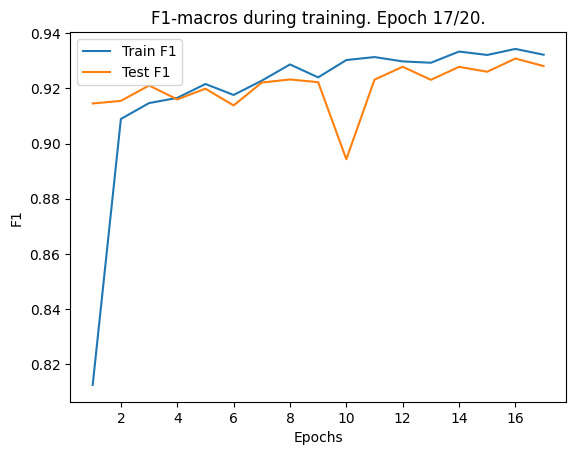

----------
Epoch Time: 0:13
Epoch 18/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  7.04it/s, Loss=0.116793, Corrects=243/256, Accuracy=94.922%]


Calculating metrics...
train loss: 0.162940, acc: 0.937886, f05_macro: 0.938012, f1_macro: 0.937760
Confusion matrix:
[[4736  396   13   27]
 [ 668 4446    9   69]
 [  33   16 5137    4]
 [  12   39    2 5129]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.06it/s, Loss=0.168120, Corrects=13/13, Accuracy=100.000%]


Calculating metrics...
test loss: 0.204813, acc: 0.927924, f05_macro: 0.927730, f1_macro: 0.927725
Confusion matrix:
[[512  63   1   3]
 [ 78 490   2   9]
 [  3   4 572   1]
 [  0   3   0 576]]


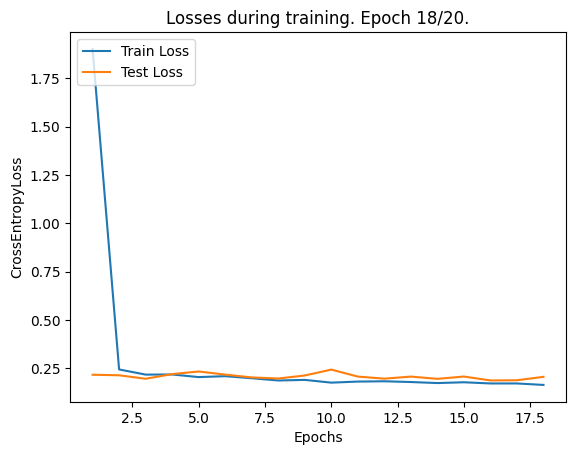

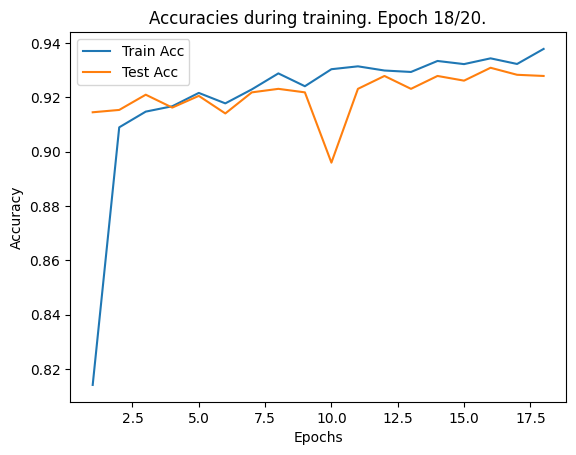

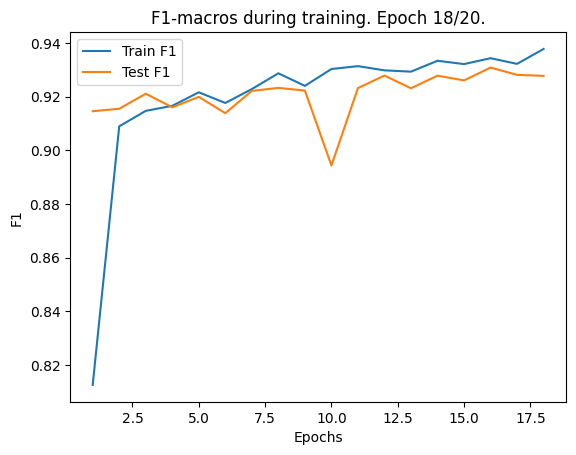

----------
Epoch Time: 0:13
Epoch 19/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  7.12it/s, Loss=0.180049, Corrects=236/256, Accuracy=92.188%]


Calculating metrics...
train loss: 0.166733, acc: 0.934076, f05_macro: 0.934141, f1_macro: 0.933981
Confusion matrix:
[[4676  461   21   26]
 [ 677 4433   12   61]
 [  35   17 5132    3]
 [  17   32    5 5128]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.03it/s, Loss=0.159980, Corrects=12/13, Accuracy=92.308%]


Calculating metrics...
test loss: 0.202702, acc: 0.923608, f05_macro: 0.923927, f1_macro: 0.923590
Confusion matrix:
[[485  87   4   3]
 [ 59 512   0   8]
 [  3   7 569   1]
 [  0   5   0 574]]


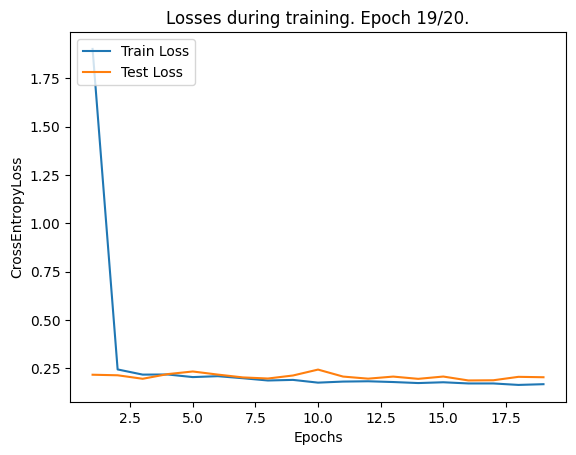

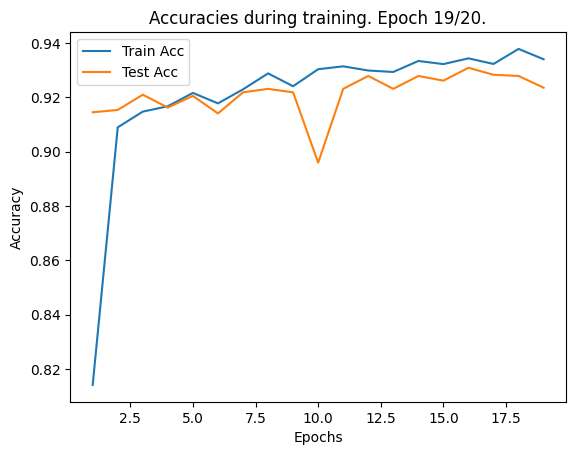

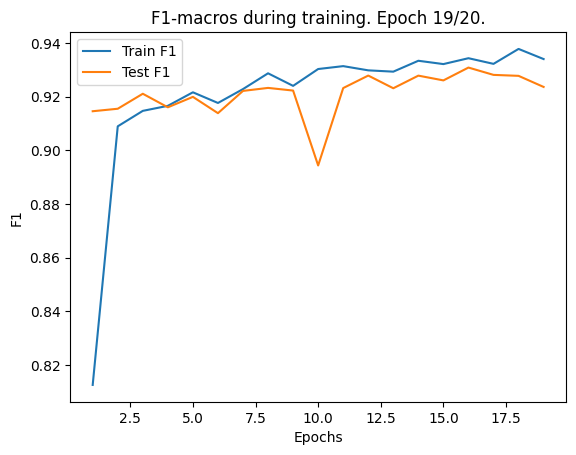

----------
Epoch Time: 0:13
Epoch 20/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  7.13it/s, Loss=0.156893, Corrects=240/256, Accuracy=93.750%]


Calculating metrics...
train loss: 0.162060, acc: 0.939091, f05_macro: 0.939343, f1_macro: 0.939061
Confusion matrix:
[[4760  391   16   23]
 [ 657 4462    9   59]
 [  36   19 5119    5]
 [  16   28    4 5132]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.88it/s, Loss=0.215662, Corrects=11/13, Accuracy=84.615%]


Calculating metrics...
test loss: 0.208195, acc: 0.919292, f05_macro: 0.920613, f1_macro: 0.919391
Confusion matrix:
[[466 108   0   5]
 [ 52 523   0   4]
 [  4   5 570   1]
 [  0   8   0 571]]


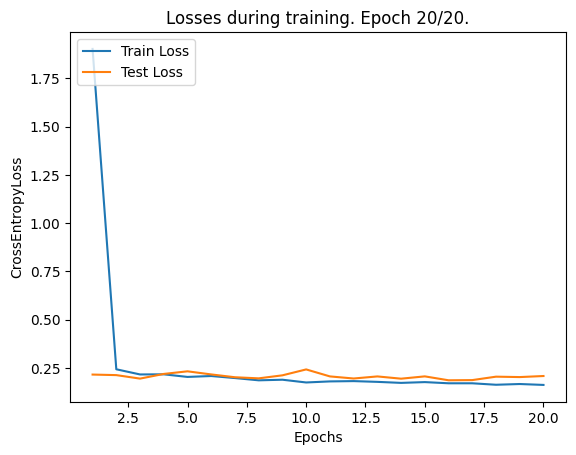

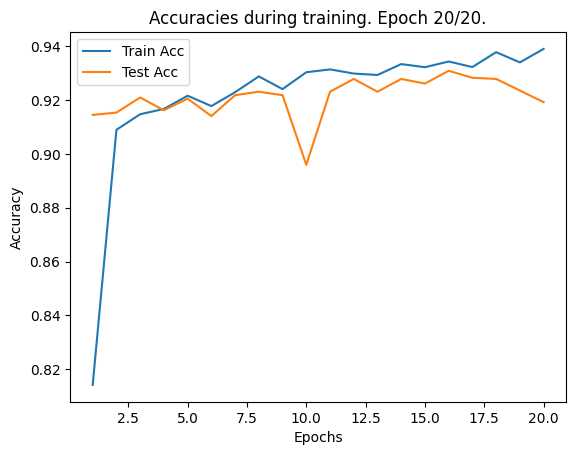

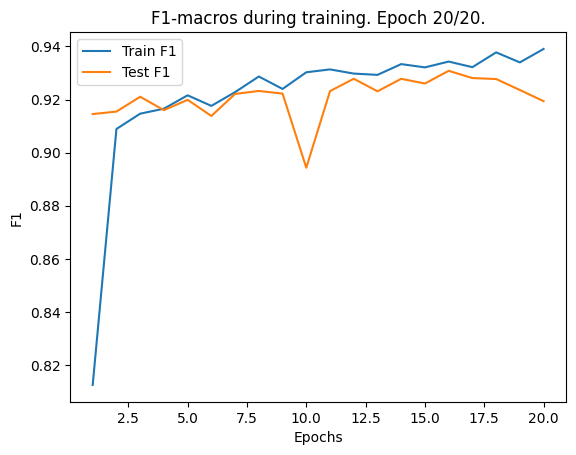

----------
Epoch Time: 0:13
*** Training Completed ***
Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:36<00:00,  2.24it/s, Loss=0.421412, Corrects=215/256, Accuracy=83.984%]


Calculating metrics...
train loss: 1.969691, acc: 0.751254, f05_macro: 0.752430, f1_macro: 0.751393
Confusion matrix:
[[3675 1135  131  253]
 [1485 3011  281  414]
 [ 288  194 4587  104]
 [ 421  315  137 4305]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.08it/s, Loss=0.226512, Corrects=12/13, Accuracy=92.308%]


Calculating metrics...
test loss: 0.260513, acc: 0.902892, f05_macro: 0.903376, f1_macro: 0.902569
Confusion matrix:
[[512  63   1   3]
 [124 443   3   9]
 [  3   9 568   0]
 [  0   9   1 569]]
----------
Epoch Time: 0:40
Epoch 2/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:36<00:00,  2.21it/s, Loss=0.233962, Corrects=239/256, Accuracy=93.359%]


Calculating metrics...
train loss: 0.282669, acc: 0.893133, f05_macro: 0.893590, f1_macro: 0.892972
Confusion matrix:
[[4497  644   14   20]
 [1092 3931   45  124]
 [  47   98 5036    3]
 [  20  106    3 5056]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.02it/s, Loss=0.236453, Corrects=12/13, Accuracy=92.308%]

Calculating metrics...
test loss: 0.233474, acc: 0.914113, f05_macro: 0.914569, f1_macro: 0.914053
Confusion matrix:
[[515  59   4   1]
 [104 466   3   6]
 [  4   7 569   0]
 [  1   8   2 568]]


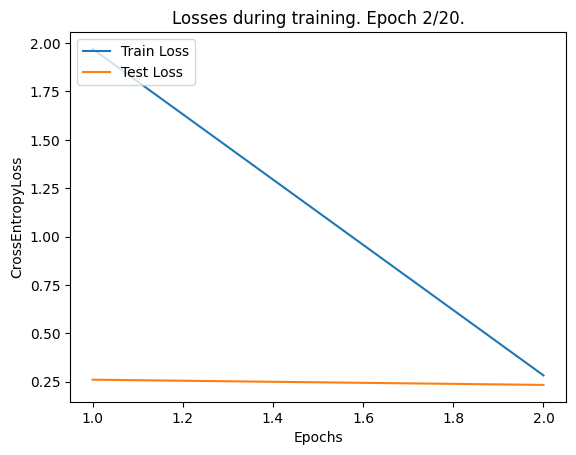

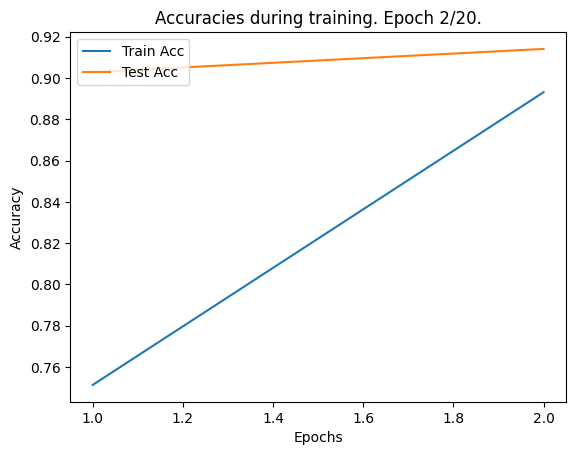

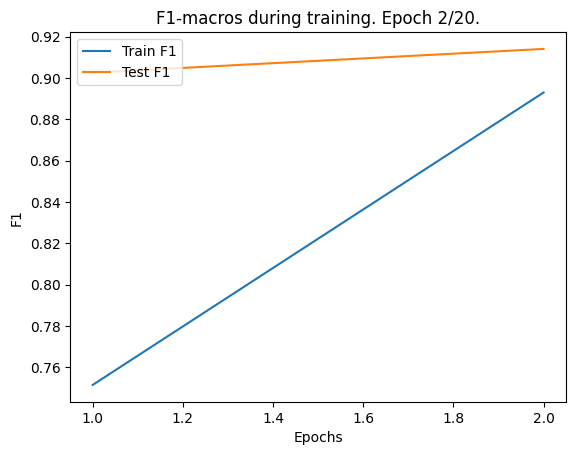

----------
Epoch Time: 0:41
Epoch 3/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:36<00:00,  2.22it/s, Loss=0.171287, Corrects=239/256, Accuracy=93.359%]


Calculating metrics...
train loss: 0.244204, acc: 0.907070, f05_macro: 0.907405, f1_macro: 0.906907
Confusion matrix:
[[4585  558   18   22]
 [ 950 4088   46  105]
 [  48   75 5056    4]
 [  21   78    2 5080]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.07it/s, Loss=0.117534, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.219254, acc: 0.919292, f05_macro: 0.920137, f1_macro: 0.919596
Confusion matrix:
[[518  58   0   3]
 [ 97 478   1   3]
 [  4   8 568   0]
 [  0  12   1 566]]


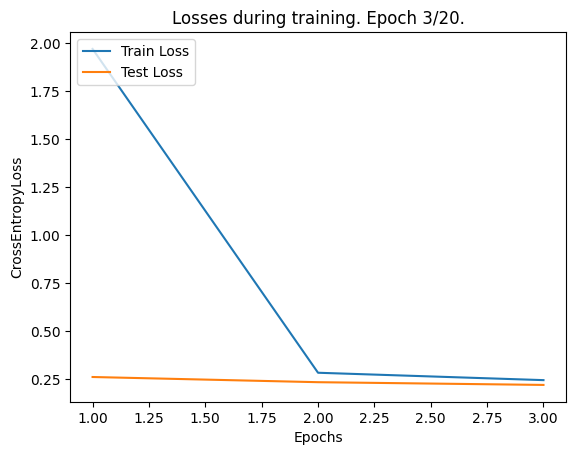

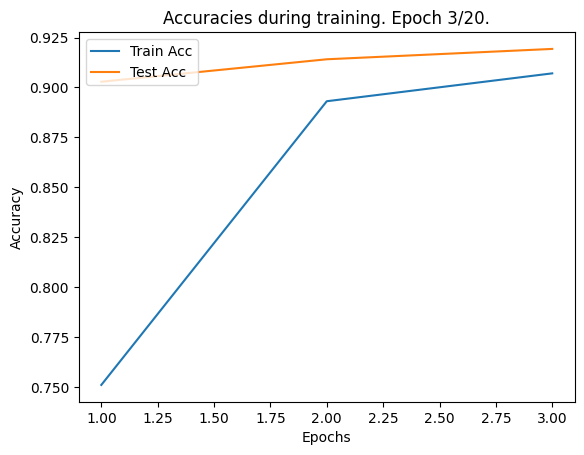

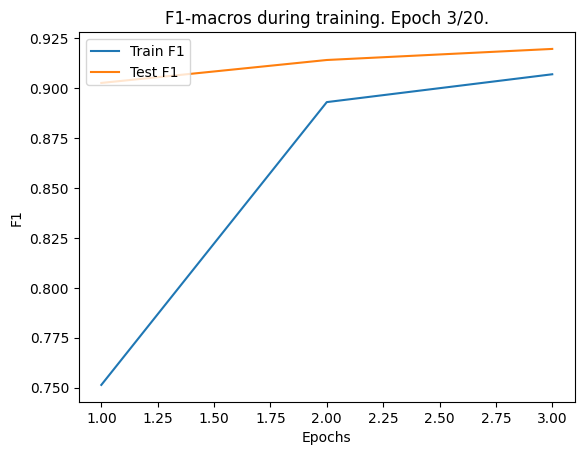

----------
Epoch Time: 0:41
Epoch 4/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:36<00:00,  2.23it/s, Loss=0.194145, Corrects=234/256, Accuracy=91.406%]


Calculating metrics...
train loss: 0.221510, acc: 0.916522, f05_macro: 0.916765, f1_macro: 0.916360
Confusion matrix:
[[4669  485   13   22]
 [ 847 4189   50   99]
 [  38   60 5077    4]
 [  16   95    2 5070]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.05it/s, Loss=0.039395, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.227757, acc: 0.912387, f05_macro: 0.914674, f1_macro: 0.911132
Confusion matrix:
[[549  27   0   3]
 [142 423   0  14]
 [  5   6 569   0]
 [  0   5   1 573]]


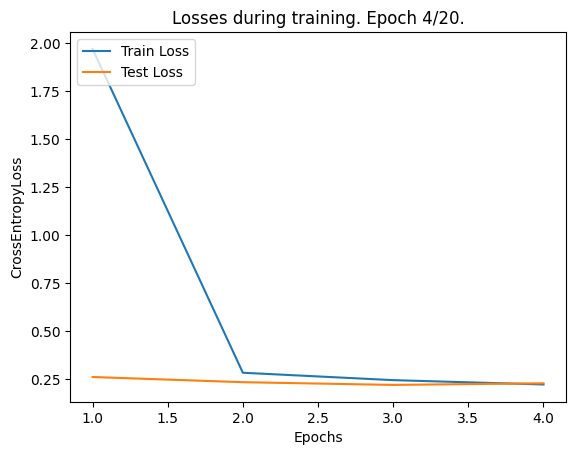

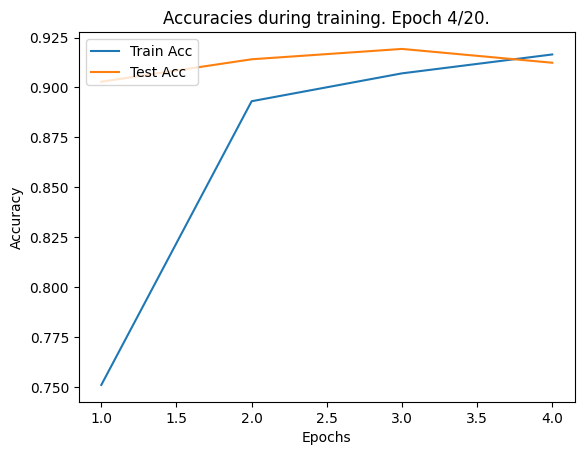

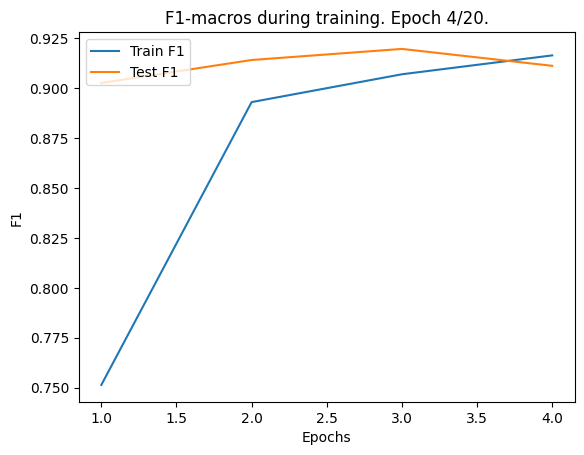

----------
Epoch Time: 0:41
Epoch 5/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:36<00:00,  2.19it/s, Loss=0.185816, Corrects=241/256, Accuracy=94.141%]


Calculating metrics...
train loss: 0.201725, acc: 0.922936, f05_macro: 0.923273, f1_macro: 0.922971
Confusion matrix:
[[4662  499   15   17]
 [ 790 4296   37   65]
 [  31   60 5074    4]
 [  16   64    0 5106]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.01it/s, Loss=0.074679, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.216320, acc: 0.916703, f05_macro: 0.918040, f1_macro: 0.916214
Confusion matrix:
[[536  40   0   3]
 [122 447   4   6]
 [  4   7 569   0]
 [  2   4   1 572]]


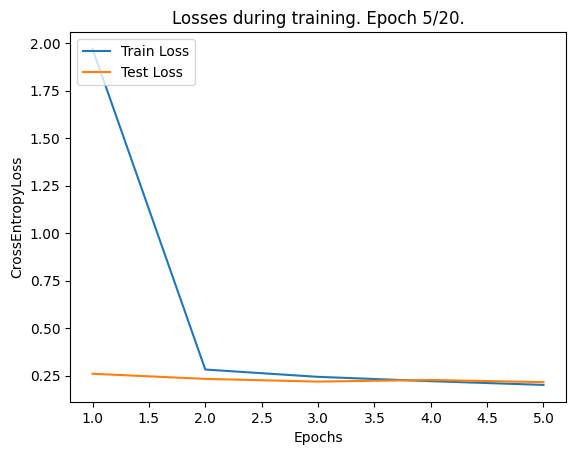

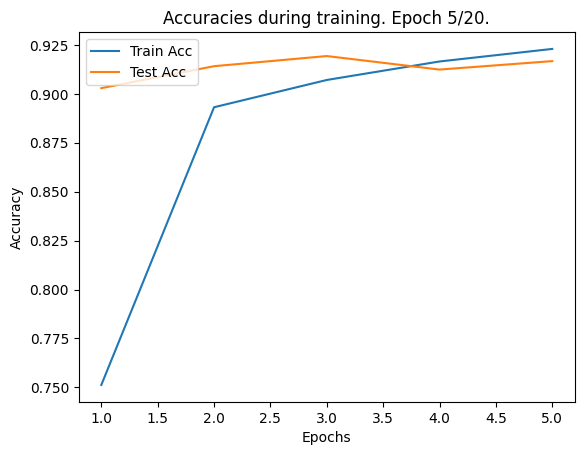

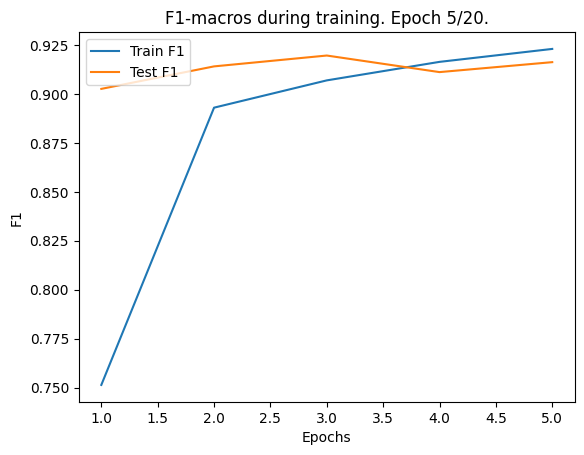

----------
Epoch Time: 0:42
Epoch 6/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:37<00:00,  2.17it/s, Loss=0.218027, Corrects=233/256, Accuracy=91.016%]


Calculating metrics...
train loss: 0.204477, acc: 0.920187, f05_macro: 0.920378, f1_macro: 0.920115
Confusion matrix:
[[4636  503   21   20]
 [ 778 4281   40   83]
 [  35   62 5086    3]
 [  23   83    4 5078]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.03it/s, Loss=0.111127, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.225223, acc: 0.922745, f05_macro: 0.923722, f1_macro: 0.922701
Confusion matrix:
[[530  45   0   4]
 [106 468   0   5]
 [  5   7 568   0]
 [  0   6   1 572]]


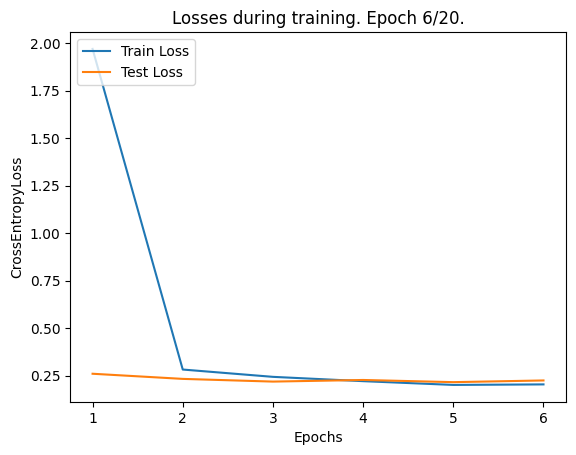

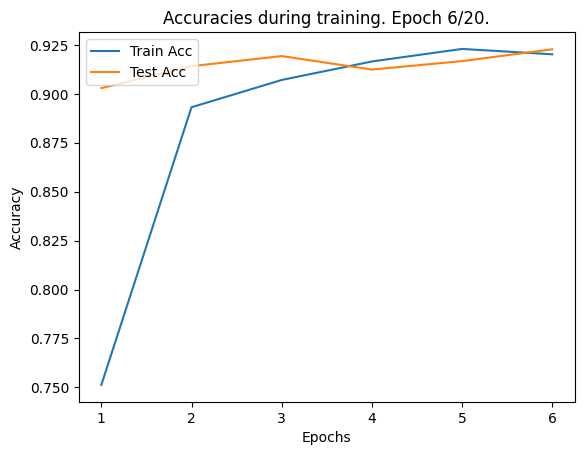

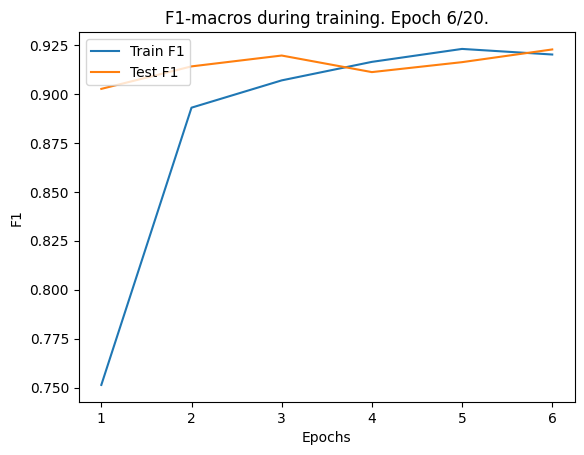

----------
Epoch Time: 0:42
Epoch 7/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:37<00:00,  2.19it/s, Loss=0.208170, Corrects=239/256, Accuracy=93.359%]


Calculating metrics...
train loss: 0.204311, acc: 0.923177, f05_macro: 0.923365, f1_macro: 0.923210
Confusion matrix:
[[4611  543   11   18]
 [ 724 4351   34   70]
 [  28   55 5099    4]
 [  13   90    3 5082]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.02it/s, Loss=0.117897, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.213869, acc: 0.918861, f05_macro: 0.919520, f1_macro: 0.919232
Confusion matrix:
[[502  74   0   3]
 [ 86 489   0   4]
 [  3   9 568   0]
 [  0   9   0 570]]


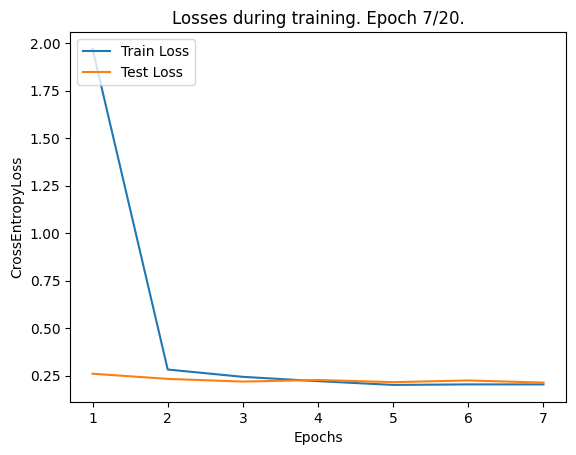

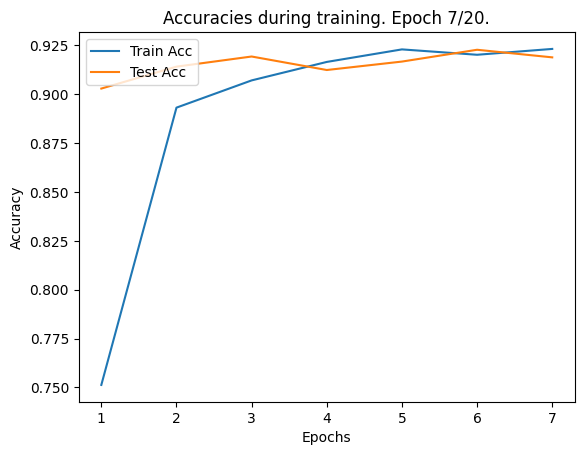

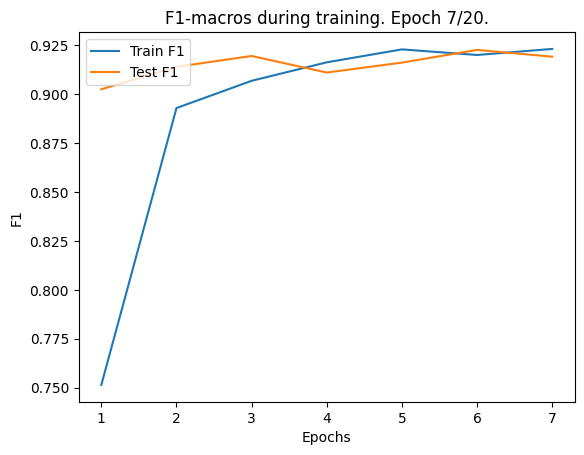

----------
Epoch Time: 0:42
Epoch 8/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:37<00:00,  2.17it/s, Loss=0.204216, Corrects=233/256, Accuracy=91.016%]


Calculating metrics...
train loss: 0.185189, acc: 0.927566, f05_macro: 0.927586, f1_macro: 0.927442
Confusion matrix:
[[4700  450   15   14]
 [ 675 4361   33  107]
 [  25   59 5104    3]
 [   6  114    1 5069]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.04it/s, Loss=0.103227, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.208805, acc: 0.921882, f05_macro: 0.922492, f1_macro: 0.921995
Confusion matrix:
[[518  58   0   3]
 [ 99 476   1   3]
 [  3   7 570   0]
 [  0   7   0 572]]


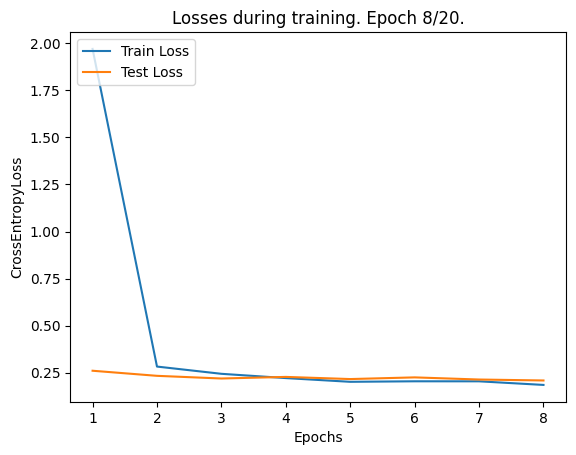

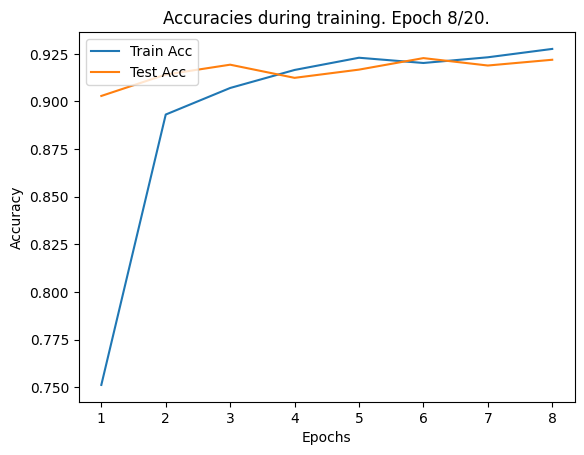

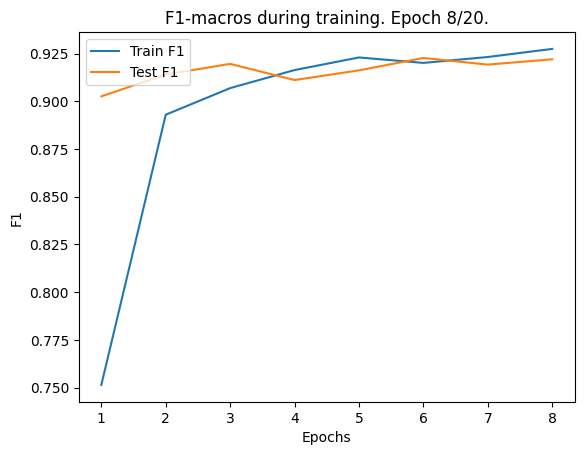

----------
Epoch Time: 0:42
Epoch 9/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:37<00:00,  2.15it/s, Loss=0.191575, Corrects=236/256, Accuracy=92.188%]


Calculating metrics...
train loss: 0.186219, acc: 0.927373, f05_macro: 0.927412, f1_macro: 0.927328
Confusion matrix:
[[4659  491   14   18]
 [ 652 4396   47   88]
 [  26   74 5082    3]
 [  15   75    3 5093]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.06it/s, Loss=0.168160, Corrects=12/13, Accuracy=92.308%]

Calculating metrics...
test loss: 0.228342, acc: 0.913681, f05_macro: 0.914202, f1_macro: 0.913923
Confusion matrix:
[[485  90   0   4]
 [ 78 493   2   6]
 [  1  10 569   0]
 [  0   8   1 570]]


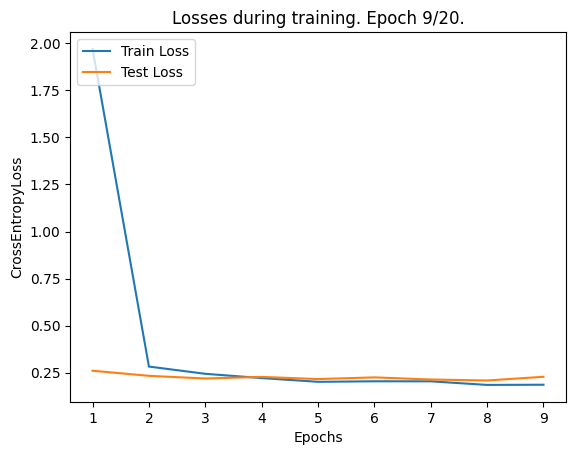

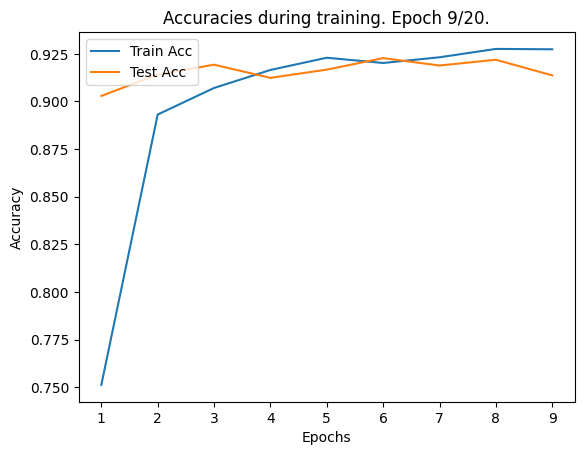

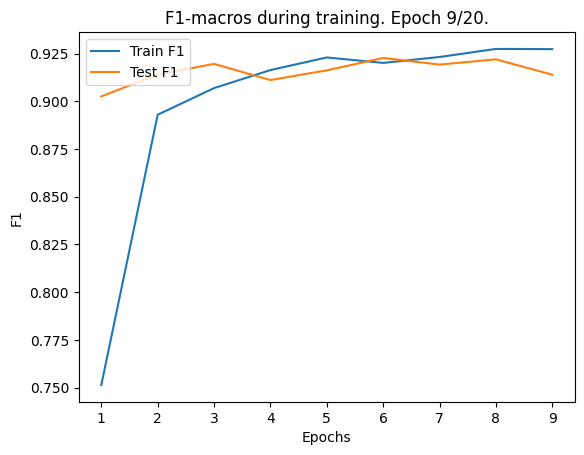

----------
Epoch Time: 0:42
Epoch 10/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:37<00:00,  2.18it/s, Loss=0.279077, Corrects=229/256, Accuracy=89.453%]


Calculating metrics...
train loss: 0.185185, acc: 0.924142, f05_macro: 0.924548, f1_macro: 0.924374
Confusion matrix:
[[4611  552   12   16]
 [ 663 4415   31   73]
 [  30   73 5076    2]
 [  17  102    2 5061]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.00it/s, Loss=0.088673, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.225565, acc: 0.919292, f05_macro: 0.919437, f1_macro: 0.919106
Confusion matrix:
[[516  59   0   4]
 [ 97 471   3   8]
 [  3   8 569   0]
 [  0   5   0 574]]


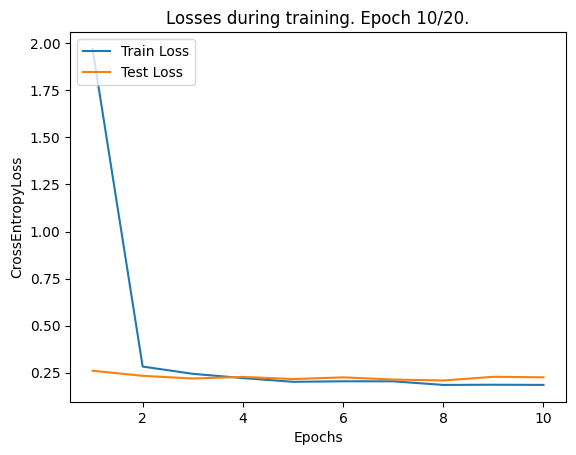

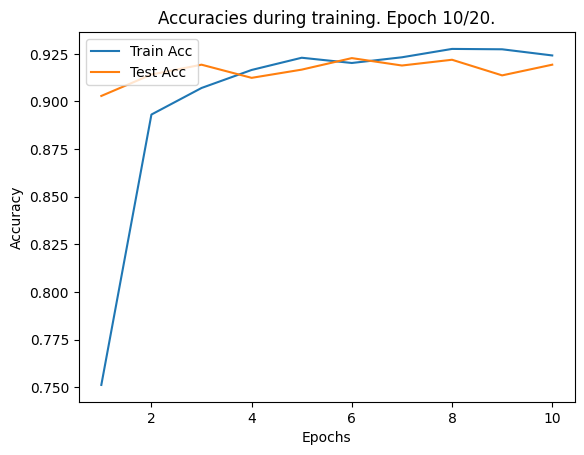

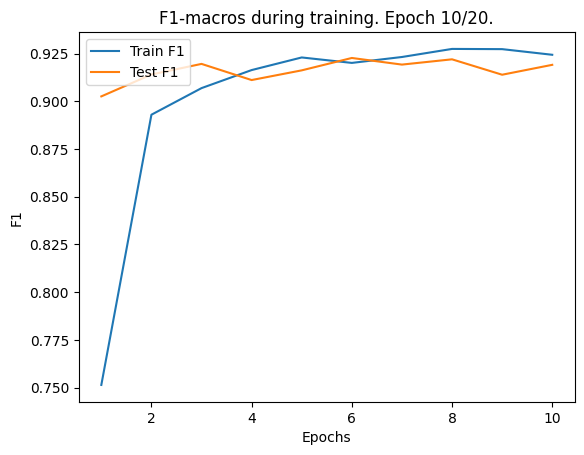

----------
Epoch Time: 0:42
Epoch 11/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:37<00:00,  2.18it/s, Loss=0.253204, Corrects=233/256, Accuracy=91.016%]


Calculating metrics...
train loss: 0.174455, acc: 0.928000, f05_macro: 0.928273, f1_macro: 0.928162
Confusion matrix:
[[4617  543   11   21]
 [ 629 4457   34   60]
 [  18   57 5106    4]
 [  16   99    1 5063]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.97it/s, Loss=0.082657, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.219178, acc: 0.917134, f05_macro: 0.917393, f1_macro: 0.917188
Confusion matrix:
[[507  71   0   1]
 [ 93 476   1   9]
 [  3   8 569   0]
 [  0   6   0 573]]


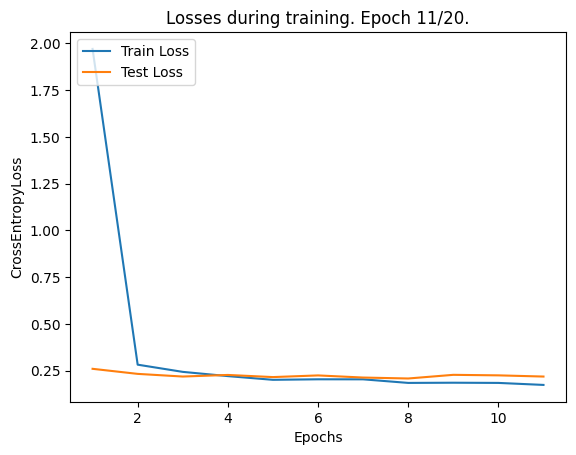

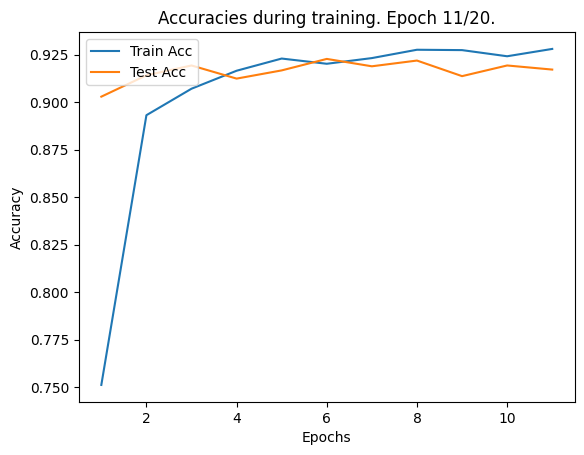

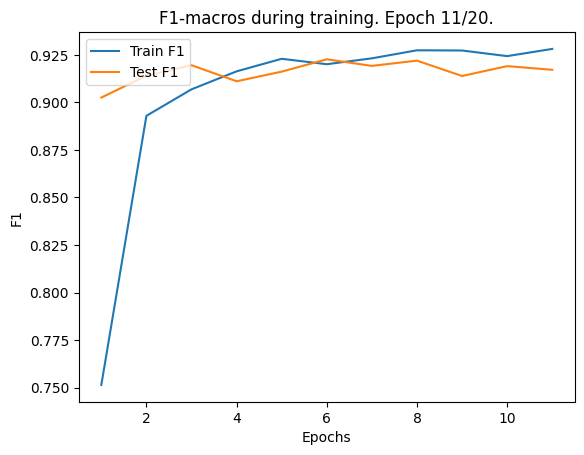

----------
Epoch Time: 0:42
Epoch 12/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:37<00:00,  2.16it/s, Loss=0.133438, Corrects=243/256, Accuracy=94.922%]


Calculating metrics...
train loss: 0.161734, acc: 0.933449, f05_macro: 0.933735, f1_macro: 0.933603
Confusion matrix:
[[4643  504    8   23]
 [ 581 4528   26   49]
 [  25   60 5097    4]
 [  21   79    0 5088]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.06it/s, Loss=0.097063, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.230135, acc: 0.919292, f05_macro: 0.919279, f1_macro: 0.919227
Confusion matrix:
[[503  71   0   5]
 [ 87 483   1   8]
 [  2   8 570   0]
 [  0   4   1 574]]


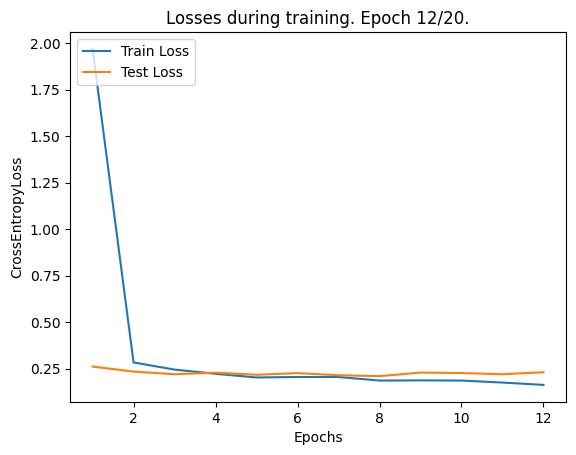

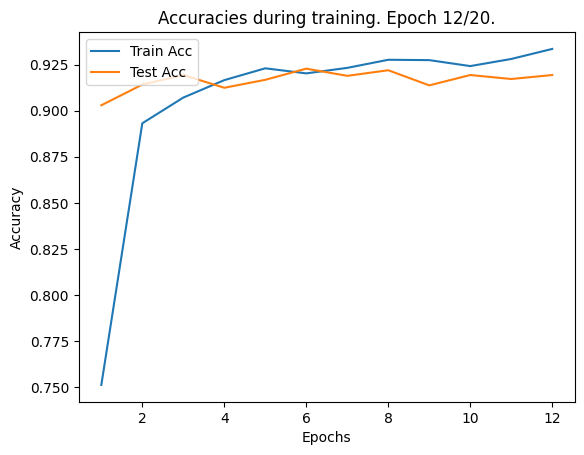

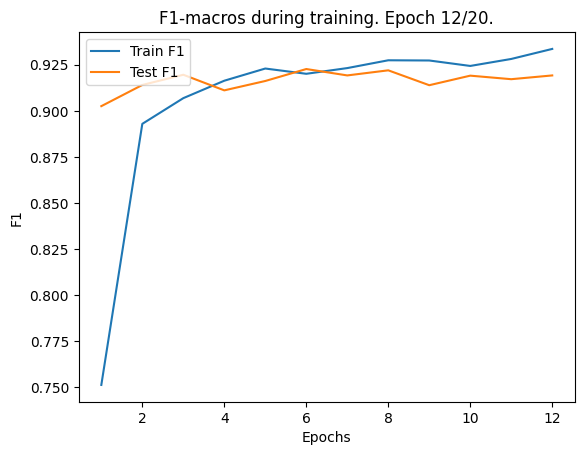

----------
Epoch Time: 0:42
Epoch 13/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:37<00:00,  2.16it/s, Loss=0.146875, Corrects=245/256, Accuracy=95.703%]


Calculating metrics...
train loss: 0.162574, acc: 0.934221, f05_macro: 0.934408, f1_macro: 0.934322
Confusion matrix:
[[4657  495   11   16]
 [ 565 4526   31   63]
 [  13   53 5114    3]
 [  24   88    2 5075]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.07it/s, Loss=0.079713, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.252385, acc: 0.917134, f05_macro: 0.918202, f1_macro: 0.916936
Confusion matrix:
[[530  49   0   0]
 [117 454   0   8]
 [  3   7 570   0]
 [  1   7   0 571]]


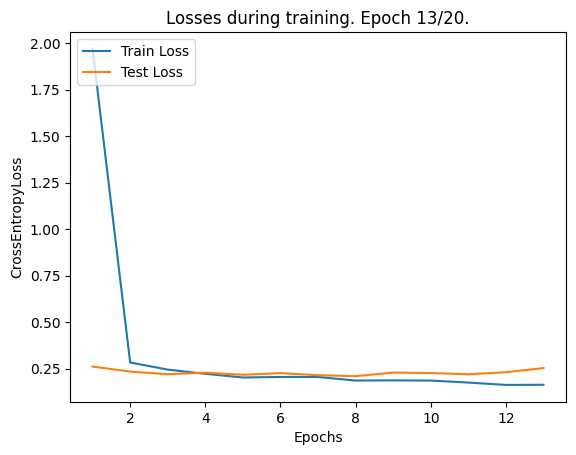

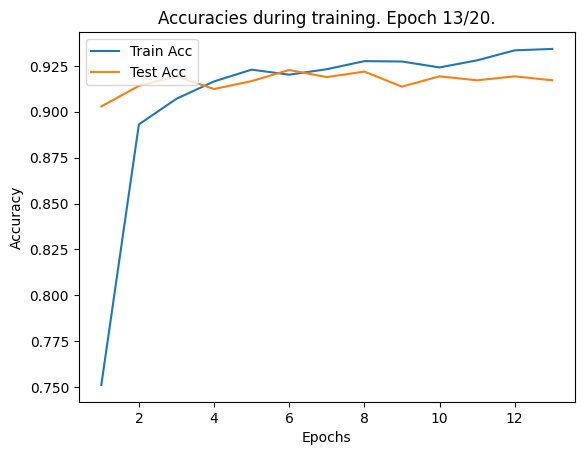

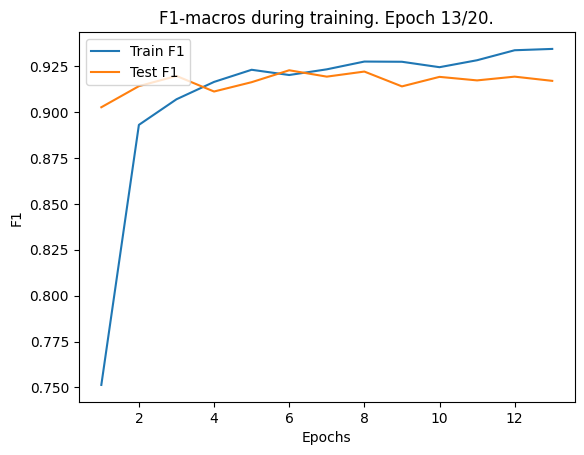

----------
Epoch Time: 0:42
Epoch 14/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:36<00:00,  2.22it/s, Loss=0.263272, Corrects=232/256, Accuracy=90.625%]


Calculating metrics...
train loss: 0.155545, acc: 0.938320, f05_macro: 0.938725, f1_macro: 0.938553
Confusion matrix:
[[4672  486    6   16]
 [ 487 4619   31   49]
 [  19   65 5106    1]
 [  16  103    0 5060]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.98it/s, Loss=0.123308, Corrects=12/13, Accuracy=92.308%]

Calculating metrics...
test loss: 0.232211, acc: 0.921019, f05_macro: 0.921532, f1_macro: 0.921161
Confusion matrix:
[[517  59   0   3]
 [ 94 479   0   6]
 [  2   8 570   0]
 [  0  10   1 568]]


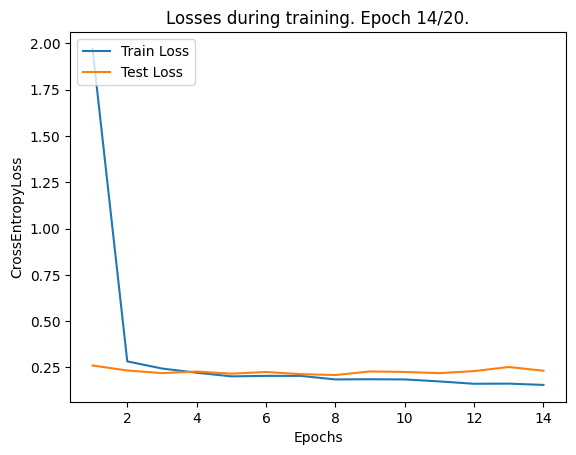

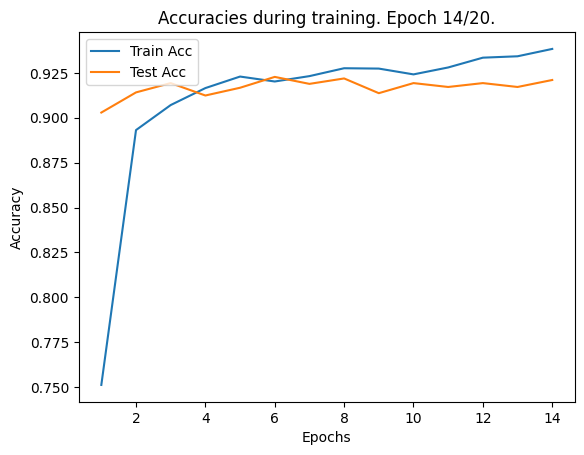

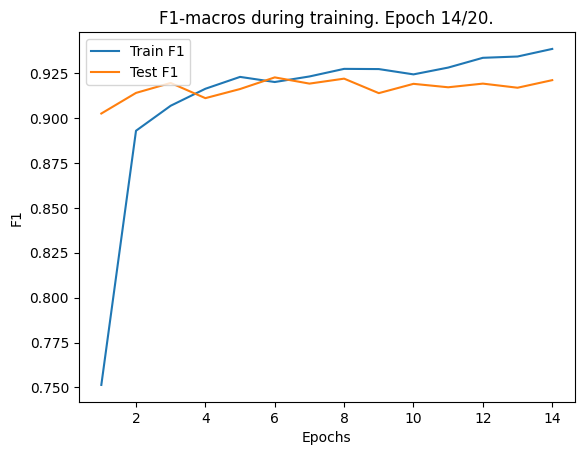

----------
Epoch Time: 0:41
Epoch 15/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:36<00:00,  2.20it/s, Loss=0.161133, Corrects=247/256, Accuracy=96.484%]


Calculating metrics...
train loss: 0.143840, acc: 0.943866, f05_macro: 0.944107, f1_macro: 0.944011
Confusion matrix:
[[4742  417   11   11]
 [ 472 4637   28   51]
 [  13   66 5100    1]
 [  17   77    0 5093]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.03it/s, Loss=0.054689, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.231619, acc: 0.919292, f05_macro: 0.920246, f1_macro: 0.918808
Confusion matrix:
[[534  44   0   1]
 [118 451   1   9]
 [  3   7 570   0]
 [  0   4   0 575]]


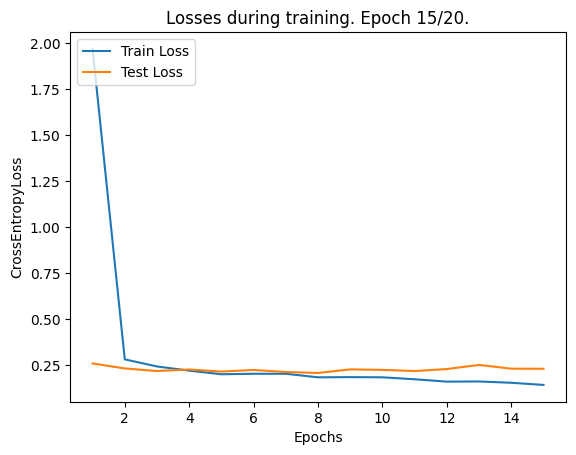

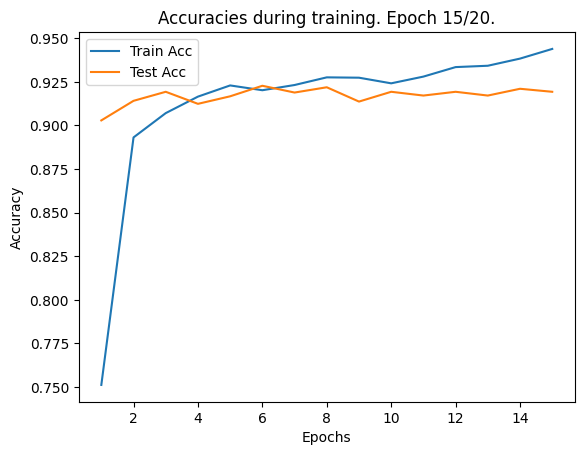

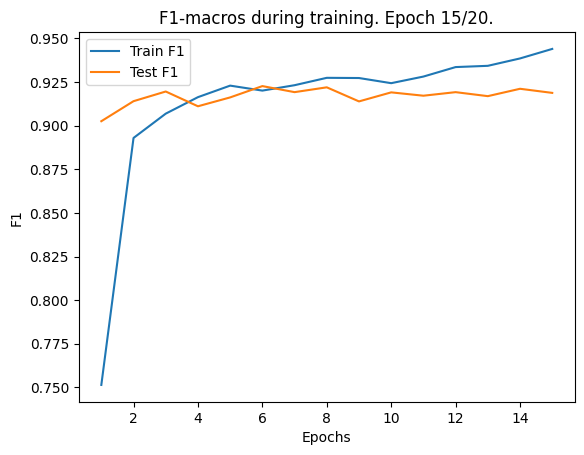

----------
Epoch Time: 0:42
Epoch 16/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:36<00:00,  2.23it/s, Loss=0.160045, Corrects=237/256, Accuracy=92.578%]


Calculating metrics...
train loss: 0.147370, acc: 0.942853, f05_macro: 0.943153, f1_macro: 0.943034
Confusion matrix:
[[4749  416   13    9]
 [ 489 4626   28   43]
 [  23   69 5090    5]
 [   8   78    4 5086]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.08it/s, Loss=0.065896, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.249999, acc: 0.923608, f05_macro: 0.924406, f1_macro: 0.923841
Confusion matrix:
[[523  56   0   0]
 [ 97 478   0   4]
 [  2   8 570   0]
 [  0  10   0 569]]


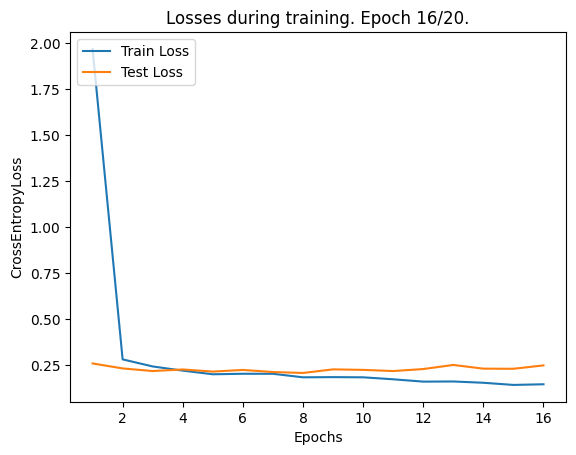

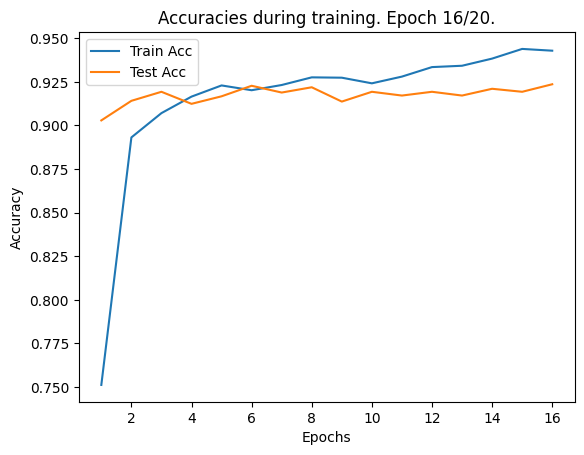

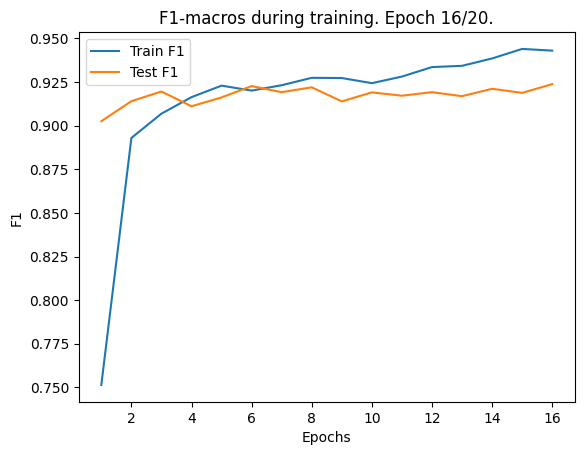

----------
Epoch Time: 0:41
Epoch 17/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:37<00:00,  2.17it/s, Loss=0.158343, Corrects=243/256, Accuracy=94.922%]


Calculating metrics...
train loss: 0.135452, acc: 0.948640, f05_macro: 0.948858, f1_macro: 0.948773
Confusion matrix:
[[4776  382    8   19]
 [ 430 4692   15   49]
 [  13   51 5116    3]
 [  15   79    1 5087]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.98it/s, Loss=0.095218, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.214425, acc: 0.921019, f05_macro: 0.921407, f1_macro: 0.921237
Confusion matrix:
[[503  75   1   0]
 [ 83 489   1   6]
 [  2   8 570   0]
 [  0   7   0 572]]


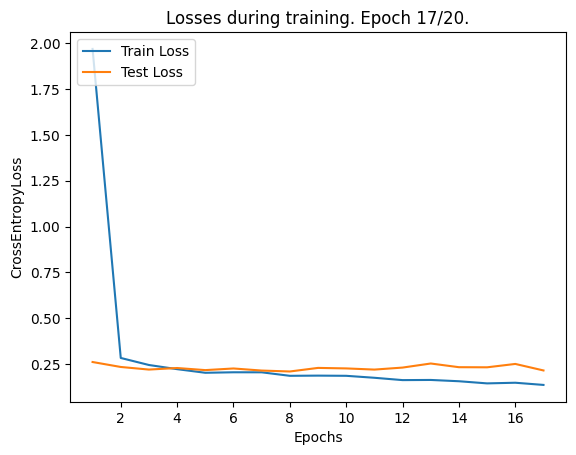

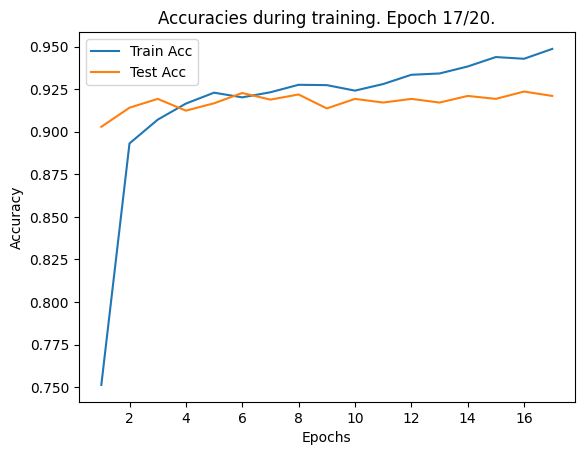

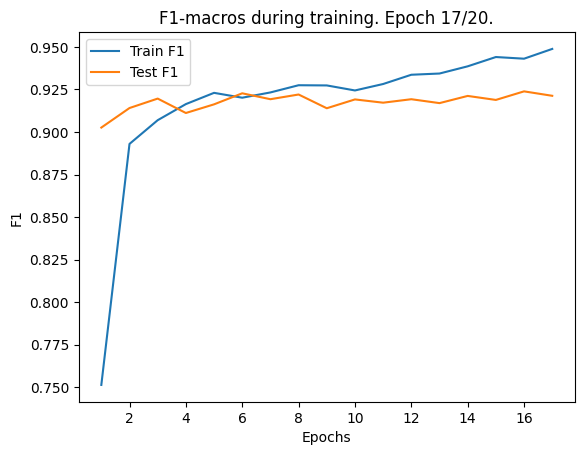

----------
Epoch Time: 0:42
Epoch 18/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:37<00:00,  2.16it/s, Loss=0.087024, Corrects=246/256, Accuracy=96.094%]


Calculating metrics...
train loss: 0.126105, acc: 0.947338, f05_macro: 0.947567, f1_macro: 0.947457
Confusion matrix:
[[4703  471    5    5]
 [ 386 4715   25   58]
 [  15   51 5115    3]
 [  10   61    2 5111]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.08it/s, Loss=0.039562, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.256537, acc: 0.921019, f05_macro: 0.921891, f1_macro: 0.921386
Confusion matrix:
[[518  61   0   0]
 [ 95 480   1   3]
 [  2   8 570   0]
 [  0  13   0 566]]


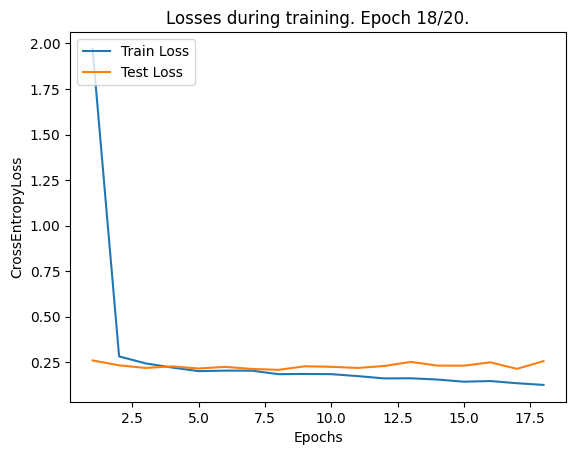

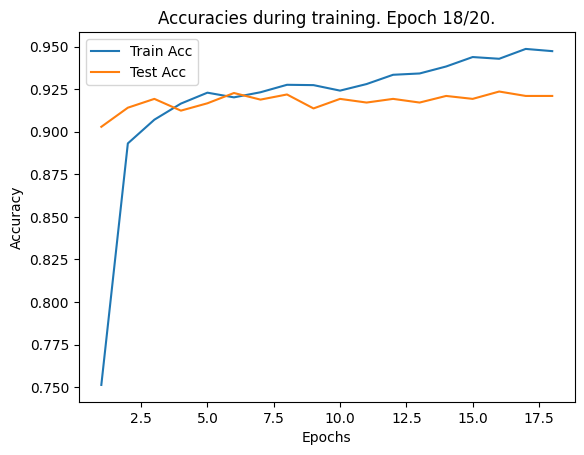

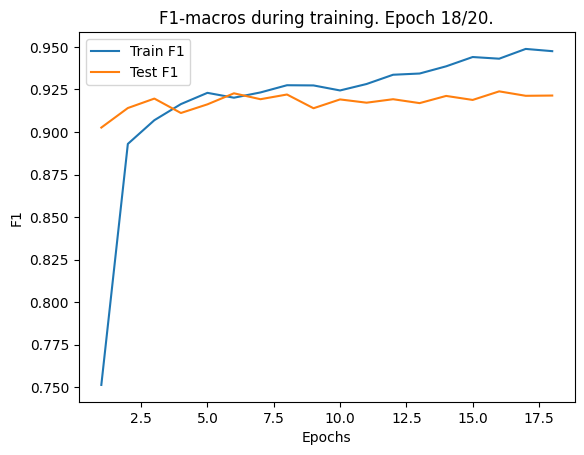

----------
Epoch Time: 0:42
Epoch 19/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:37<00:00,  2.18it/s, Loss=0.103537, Corrects=239/256, Accuracy=93.359%]


Calculating metrics...
train loss: 0.125317, acc: 0.947290, f05_macro: 0.947559, f1_macro: 0.947446
Confusion matrix:
[[4699  468    5   10]
 [ 411 4720   17   41]
 [  21   36 5126    3]
 [  18   62    1 5098]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.05it/s, Loss=0.070611, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.245608, acc: 0.921450, f05_macro: 0.922048, f1_macro: 0.921711
Confusion matrix:
[[510  67   0   2]
 [ 91 484   0   4]
 [  4   7 569   0]
 [  1   6   0 572]]


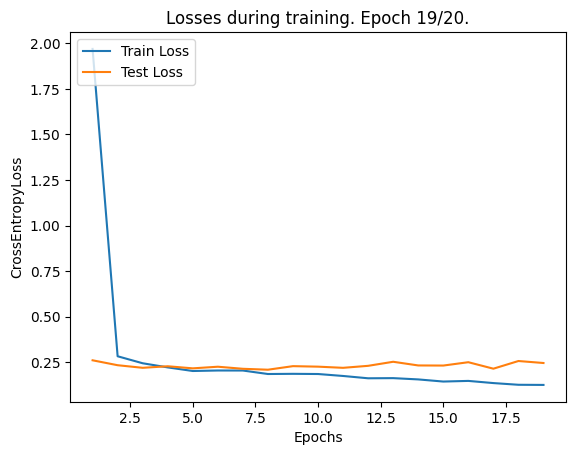

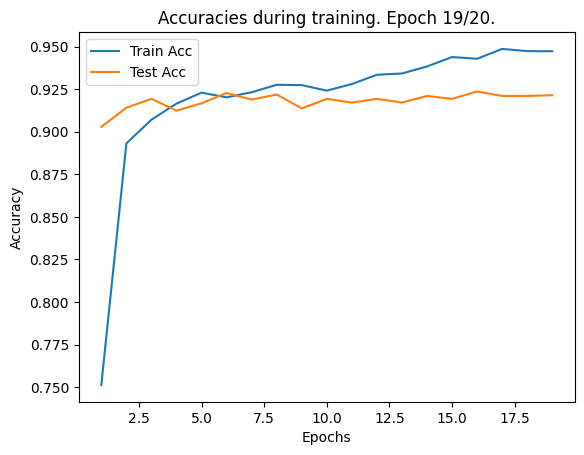

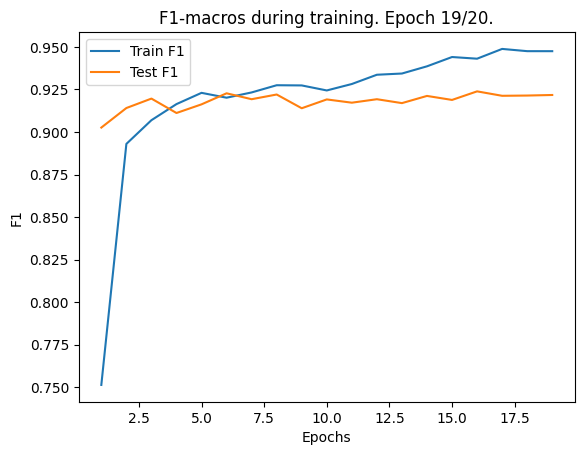

----------
Epoch Time: 0:42
Epoch 20/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:36<00:00,  2.20it/s, Loss=0.129510, Corrects=244/256, Accuracy=95.312%]


Calculating metrics...
train loss: 0.119758, acc: 0.953029, f05_macro: 0.953159, f1_macro: 0.953073
Confusion matrix:
[[4833  320   14   13]
 [ 411 4704   24   38]
 [  28   53 5103    2]
 [  23   45    3 5122]]
--- Cur phase: test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.01it/s, Loss=0.079981, Corrects=13/13, Accuracy=100.000%]

Calculating metrics...
test loss: 0.239597, acc: 0.920155, f05_macro: 0.920690, f1_macro: 0.920460
Confusion matrix:
[[495  82   2   0]
 [ 78 496   0   5]
 [  4   6 570   0]
 [  2   6   0 571]]


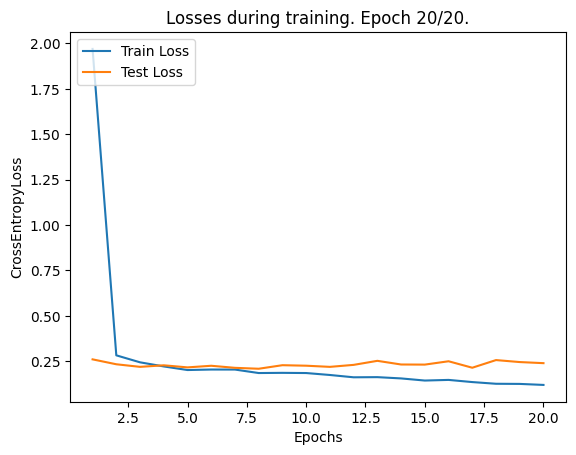

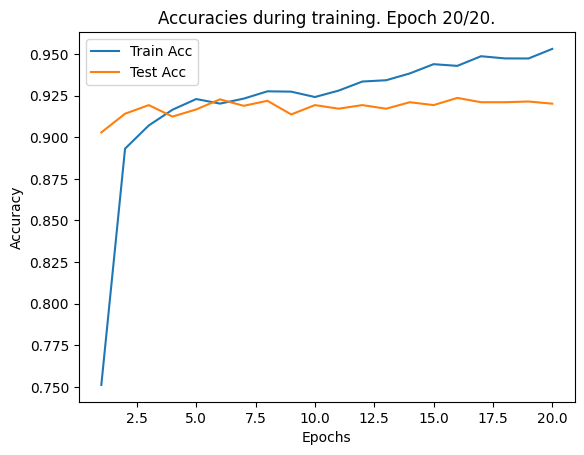

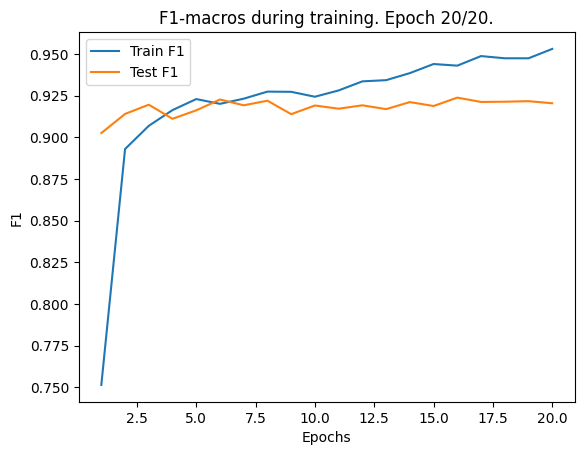

----------
Epoch Time: 0:42
*** Training Completed ***


In [28]:
from torch import optim

for name in list(net_models.keys()):
    model = net_models[name]

    learning_rate = 1e-3
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    num_epochs = 20

    saved_epoch_losses, saved_epoch_accuracies, saved_epoch_f1_macros = train_model(name, dataloaders, num_epochs)

    model_ckpt_path = f"{name}_trained.pth"
    torch.save(model.state_dict(), model_ckpt_path)

### Тестируем обученные модели

In [29]:
def load_random_image(image_dir):
    all_images = os.listdir(image_dir)
    random_image = random.choice(all_images)
    image_path = os.path.join(image_dir, random_image)
    image = Image.open(image_path)
    return image, random_image


def predict_cls(image, model):
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Добавляем дополнительную размерность для batch

    with torch.no_grad():
        output = model(input_batch)

    _, predicted_idx = torch.max(output, 1)

    return predicted_idx.item()

In [30]:
# Трансформации для тестового изображения
preprocess = T.Compose([
    T.Resize(224),  # Изменение размера изображения
    T.ToTensor(),  # Преобразование в тензор
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

In [31]:
def test_one_image(name, model):
    image_dir = './dataset/test'

    image, image_name = load_random_image(image_dir)

    plt.imshow(image)
    plt.title(f"Model: {name}, image: {image_name}")
    plt.axis('off')
    plt.show()

    model_ckpt_path = f"{name}_trained.pth"
    model.load_state_dict(torch.load(model_ckpt_path, map_location=torch.device('cpu')))
    predicted_class_idx = predict_cls(image, model)
    print(f'Predicted class: {classes[predicted_class_idx]}')

In [32]:
net_models = {}
net_models['resnet'] = get_resnet(num_classes=len(classes))
net_models['alexnet'] = get_alexnet(num_classes=len(classes))
net_models['vgg'] = get_vgg(num_classes=len(classes))

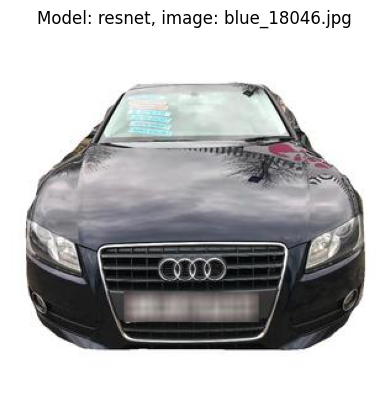

Predicted class: blue


/tmp/ipykernel_28822/3584983014.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_ckpt_path, map_location=torch.device('cpu')))


In [33]:
test_one_image('resnet', net_models['resnet'])

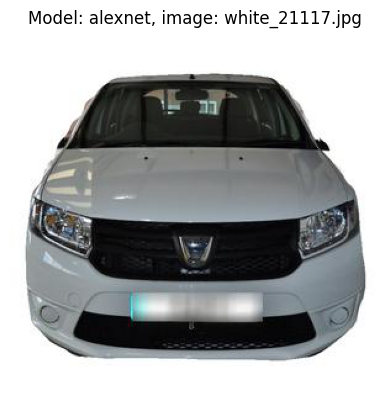

/tmp/ipykernel_28822/3584983014.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_ckpt_path, map_location=torch.device('cpu')))


Predicted class: white


In [34]:
test_one_image('alexnet', net_models['alexnet'])

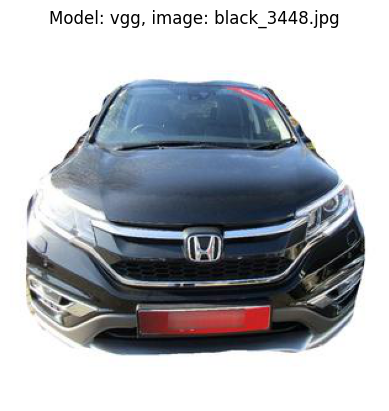

/tmp/ipykernel_28822/3584983014.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_ckpt_path, map_location=torch.device('cpu')))


Predicted class: black


In [35]:
test_one_image('vgg', net_models['vgg'])

### Результаты

### Метрики

In [36]:
qualities = []
for name in list(net_models.keys()):
    quality_data = pd.DataFrame(
        columns=['Loss (Train)', 'Accuracy (Train)', 'F05_macro (Train)', 'F1_macro (Train)', 'Loss (Test)',
                 'Accuracy (Test)', 'F05_macro (Test)', 'F1_macro (Test)'], index=[name])

    epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix = results[name]['train']
    quality_data['Loss (Train)'] = round(float(epoch_loss), 3)
    quality_data['Accuracy (Train)'] = round(float(epoch_acc), 3)
    quality_data['F05_macro (Train)'] = round(float(f05_macro), 3)
    quality_data['F1_macro (Train)'] = round(float(f1_macro), 3)

    epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix = results[name]['test']
    quality_data['Loss (Test)'] = round(float(epoch_loss), 3)
    quality_data['Accuracy (Test)'] = round(float(epoch_acc), 3)
    quality_data['F05_macro (Test)'] = round(float(f05_macro), 3)
    quality_data['F1_macro (Test)'] = round(float(f1_macro), 3)

    qualities.append(quality_data)

models_report = pd.concat(qualities)
models_report

Loss (Train)  Accuracy (Train)  F05_macro (Train)  F1_macro (Train)  \
resnet          0.021             0.993              0.993             0.993   
alexnet         0.162             0.939              0.939             0.939   
vgg             0.120             0.953              0.953             0.953   

         Loss (Test)  Accuracy (Test)  F05_macro (Test)  F1_macro (Test)  
resnet         0.389            0.905             0.907            0.906  
alexnet        0.208            0.919             0.921            0.919  
vgg            0.240            0.920             0.921            0.920

### Графики

resnet


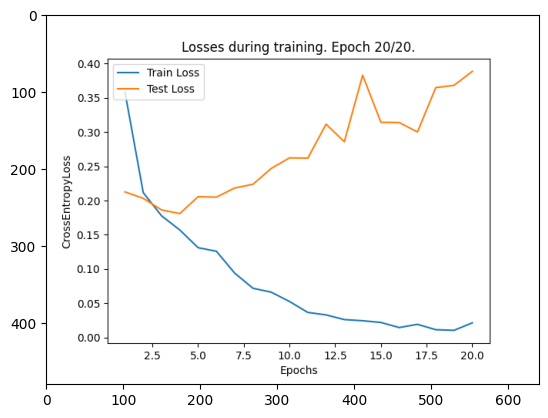

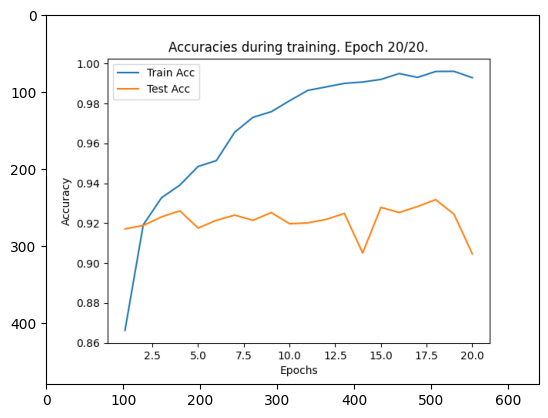

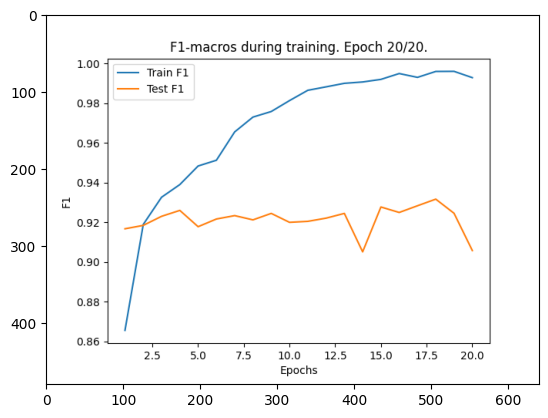

alexnet


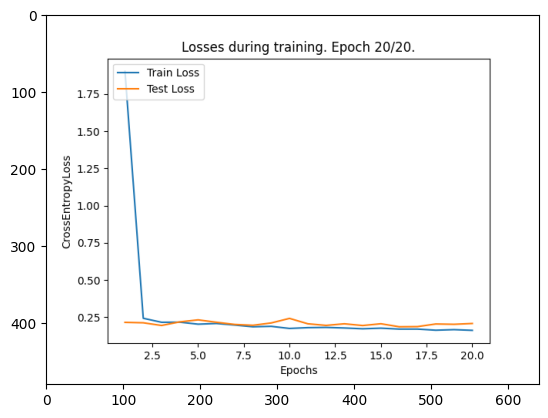

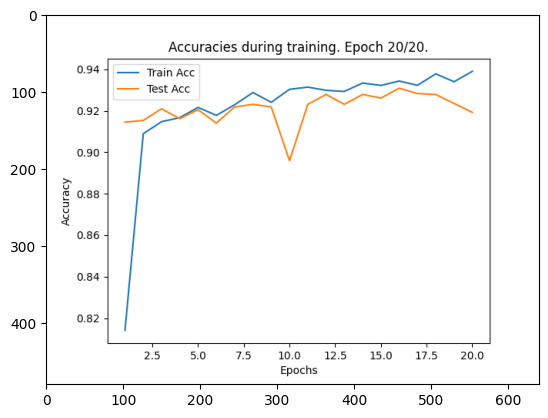

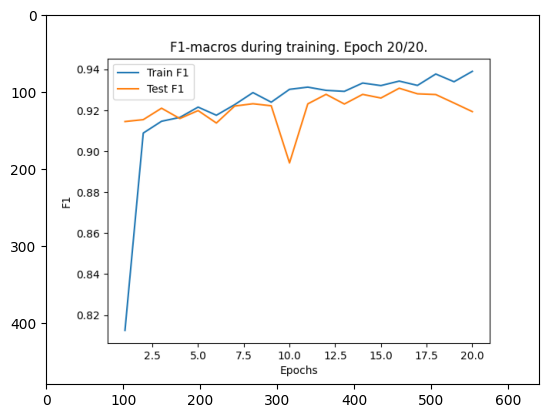

vgg


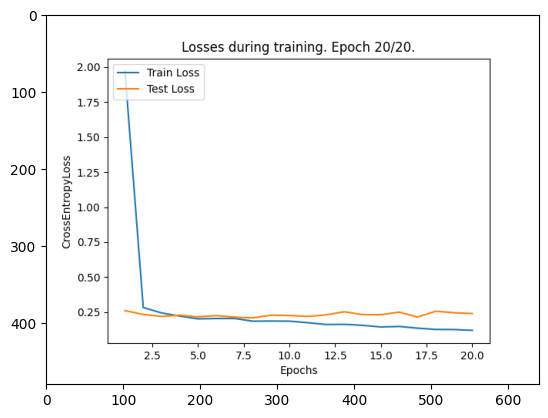

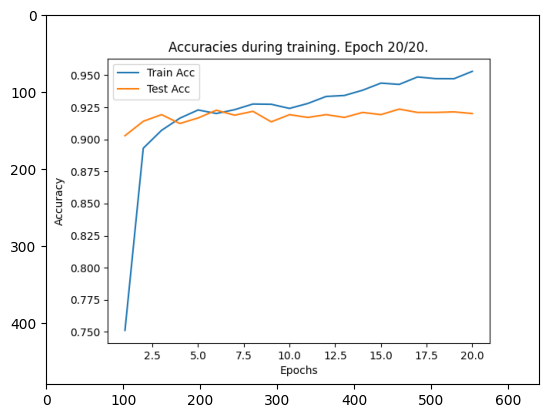

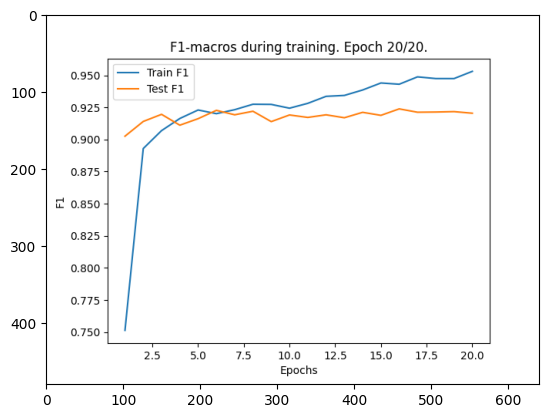

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for name in list(net_models.keys()):
    print(name)
    img = mpimg.imread(f'{log_folder}/loss_graph_{name}_epoch{num_epochs + 1}.png')
    plt.imshow(img)
    plt.show()
    
    img = mpimg.imread(f'{log_folder}/acc_graph_{name}_epoch{num_epochs + 1}.png')
    plt.imshow(img)
    plt.show()
    
    img = mpimg.imread(f'{log_folder}/f1_graph_{name}_epoch{num_epochs + 1}.png')
    plt.imshow(img)
    plt.show()    

### Confusion Matrix

In [38]:
qualities = []
for name in list(net_models.keys()):
    _, _, _, _, conf_matrix_train = results[name]['train']
    _, _, _, _, conf_matrix_test = results[name]['test']

    print(f"{name} train: {conf_matrix_train} \n")
    print(f"{name} test: {conf_matrix_test} \n")

resnet train: [[5138   29    5   10]
 [  33 5128    3   26]
 [   7    2 5170    2]
 [   8   20    1 5154]] 

resnet test: [[508  67   2   2]
 [ 76 499   2   2]
 [  5   4 571   0]
 [ 21  39   1 518]] 

alexnet train: [[4760  391   16   23]
 [ 657 4462    9   59]
 [  36   19 5119    5]
 [  16   28    4 5132]] 

alexnet test: [[466 108   0   5]
 [ 52 523   0   4]
 [  4   5 570   1]
 [  0   8   0 571]] 

vgg train: [[4833  320   14   13]
 [ 411 4704   24   38]
 [  28   53 5103    2]
 [  23   45    3 5122]] 

vgg test: [[495  82   2   0]
 [ 78 496   0   5]
 [  4   6 570   0]
 [  2   6   0 571]] 



### Выводы

- обучение проводил на видеокарте nvidia rtx 3090
- попробовал различные предобученные сети, наилучших результатов по качеству обучения удалось достигнуть с:
    - ResNet50
    - AlexNet
    - VGG
- выбрал по 2м причинам: удобно использовать прямо из пакета torchvision и они лучше всего обучились
- попробовал различные гиперпараметры, наилучших результатов по качеству и скорости обучения удалось достигнуть с:
    - 20 эпох
    - размер батча 256
    - 16 воркеров
    - оптимизатор Адам
    - шаг обучения 1e-3
    - функция ошибки CrossEntropyLoss
- Лучший результат по Loss на тесте показала AlexNet (0.208)
- Лучший результат по Accuracy на тесте показала VGG (0.920)
- Лучший результат по F1 Macro на тесте показала VGG (0.920)